## This analysis is based on data from trading economics

In [1]:
import sys
sys.path.insert(0,'..') if '..' not in sys.path else _;
%load_ext autoreload
%autoreload 2

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from itertools import product 


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score,TimeSeriesSplit
from xgboost import XGBRegressor 
from sklearn.linear_model import LassoCV, RidgeCV
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.stats.diagnostic import kstest_normal
import statsmodels.api as sm

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error,\
    mean_squared_error, mean_squared_log_error

import Helpers.TS as ts

import tradingeconomics as te

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from secret import enable_te

In [4]:
data_file = os.path.join('..','Data','USD_GDP_YOY.csv')

In [83]:
def getchFromTE(initData = '1960-01-01'):
    """
        Logs into TradingEconomics and fetches gdo YoY data
    """
    enable_te()
    tmp = te.getHistoricalData(country='United States', \
                     indicator='GDP Growth Rate', \
                     initDate=initData)   
    tmp.columns = ['gdp']
    tmp.index.freq = 'Q-Dec'
    return tmp
def fetchGDP(datafile=data_file):
    """
        First checks if the data is already downloaded
        If the data files exists, then it avoids loggin into TE
    """
    file_exists = os.path.isfile(datafile) 
    gdp = pd.read_csv('../Data/USD_GDP_YOY.csv',parse_dates=['date']).set_index('date')\
        if file_exists else getchFromTE()
    gdp.index.freq = 'Q'
    return gdp

In [84]:
df = fetchGDP(data_file)
df.head()

gdp
date           
1960-03-31  9.3
1960-06-30 -2.1
1960-09-30  2.0
1960-12-31 -5.0
1961-03-31  2.7

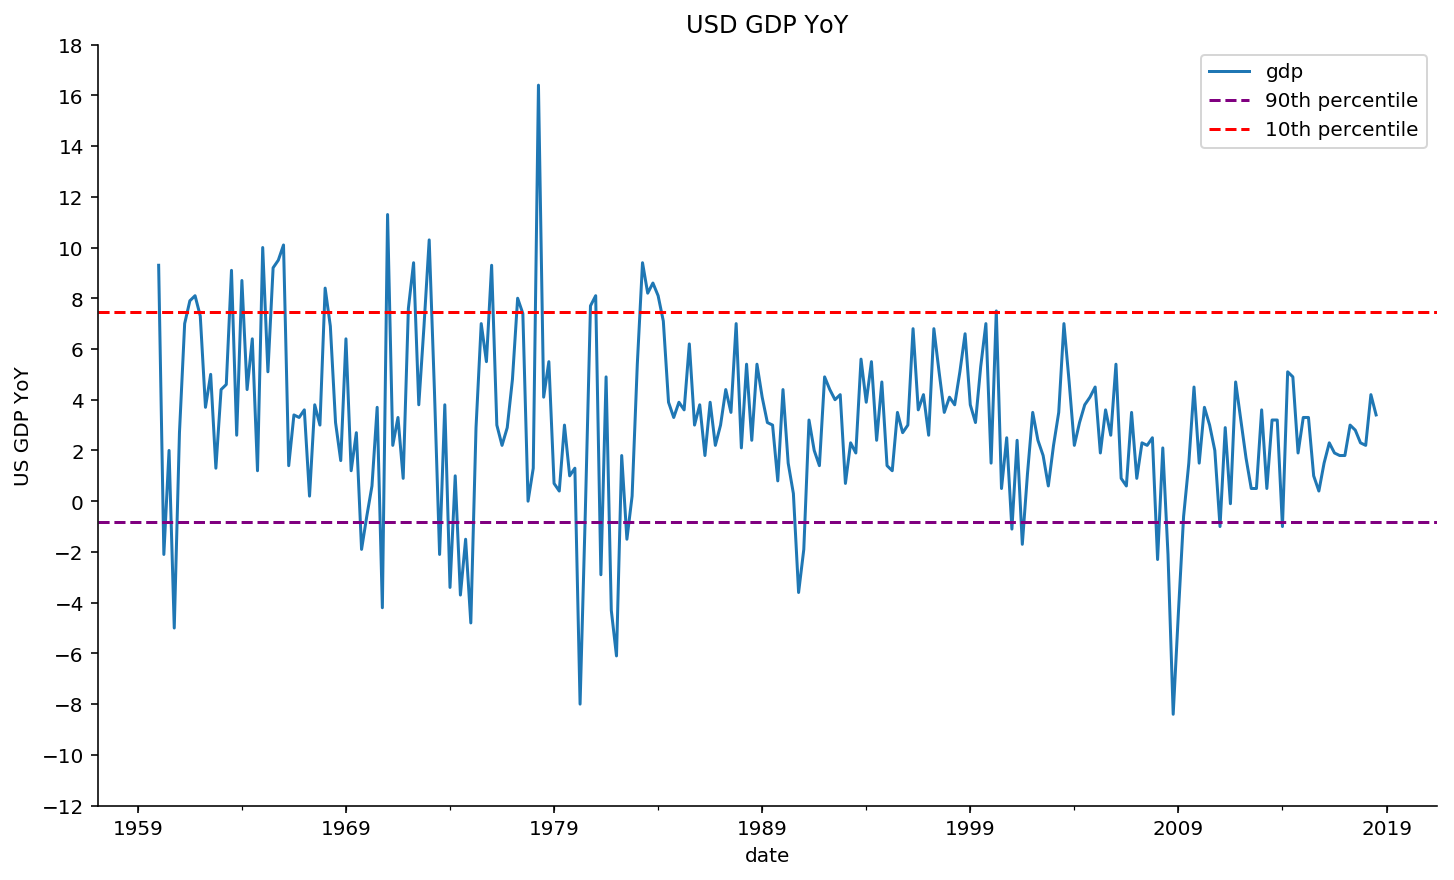

In [7]:
df.plot(figsize = [12,7],title = 'USD GDP YoY')
upper,lower = np.percentile(df.gdp,q=[10,90])
plt.axhline(upper,linestyle='--',color = 'purple', label = '90th percentile')
plt.axhline(lower,linestyle='--',color = 'red', label = '10th percentile')
plt.yticks(ticks = np.arange(start = -12,stop = 20, step = 2))
plt.ylabel('US GDP YoY')
plt.legend()
#plt.text(x = -3, y = upper + 5, s = '90 Percentile', fontsize = 14)
sns.despine()

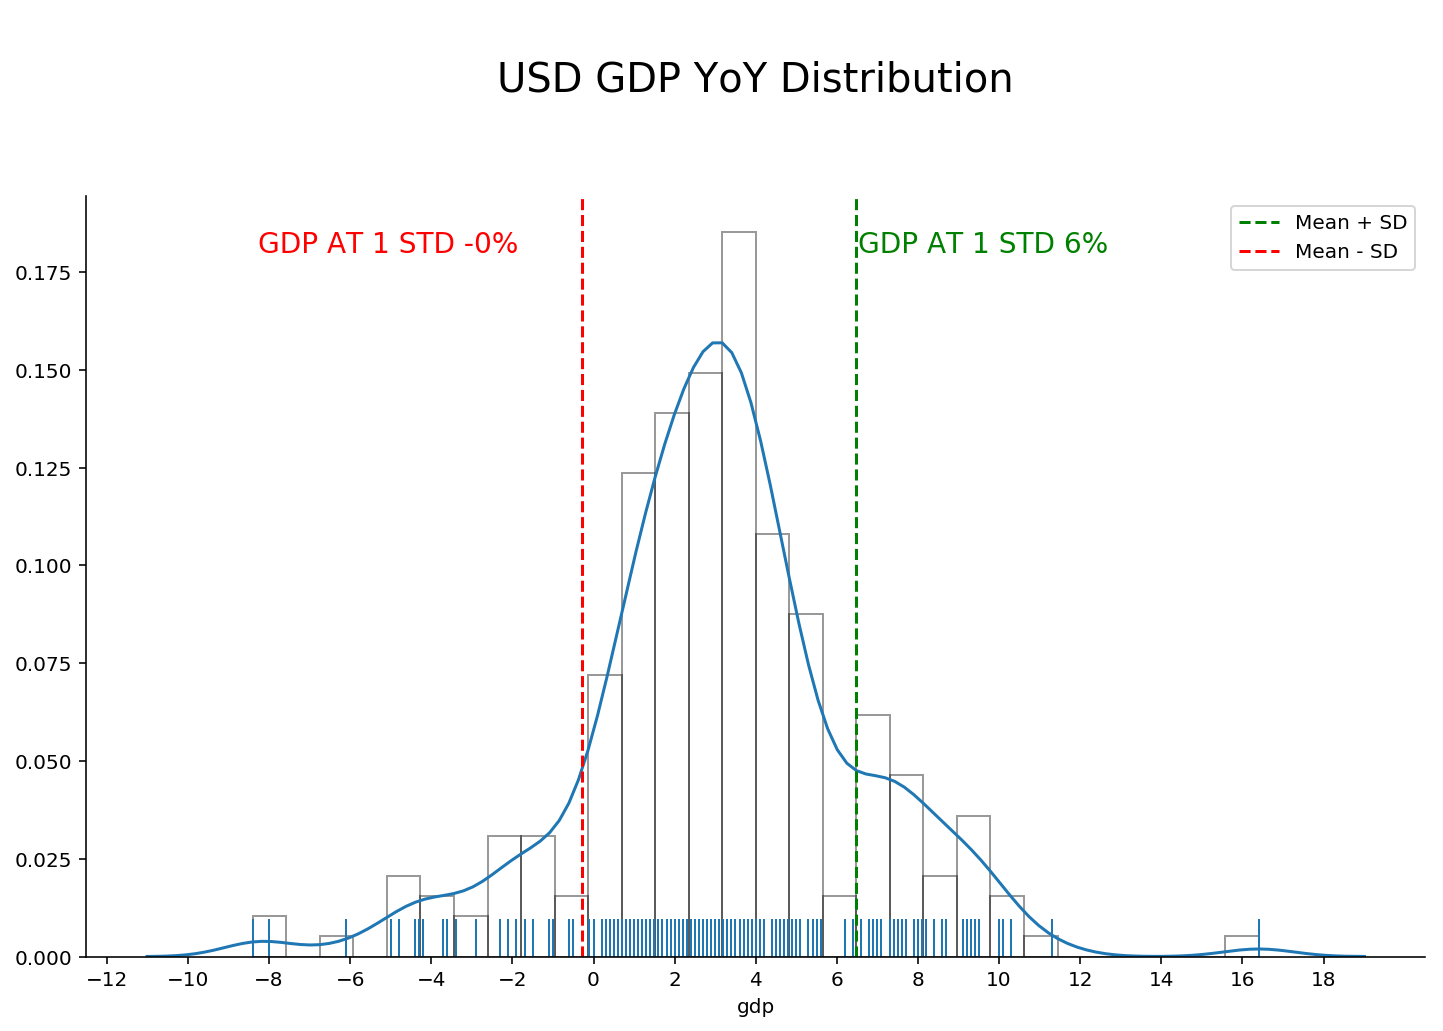

In [8]:
plt.figure(figsize=[12,7])
mean_gdp , std_gdp = (df.mean()[0], df.std()[0])
sns.distplot(df.gdp,rug=True,bins = 30, hist_kws = {'fill' : False})
plt.axvline(x= mean_gdp + std_gdp, label = 'Mean + SD', linestyle = '--', color = 'green')
plt.axvline(x= mean_gdp - std_gdp, label = 'Mean - SD', linestyle = '--', color = 'red')
plt.title('\nUSD GDP YoY Distribution\n\n', fontsize = 20)
plt.text(x = mean_gdp + std_gdp + 0.05, y = 0.18 ,\
         s = "GDP AT 1 STD {0:.00f}%".format(mean_gdp + std_gdp), \
         fontsize = 14, color = 'green' )
plt.text(x = mean_gdp - std_gdp - 8, y = 0.18 ,\
         s = "GDP AT 1 STD {0:.00f}%".format(mean_gdp - std_gdp), fontsize = 14,\
        horizontalalignment = 'left', color = 'red')
plt.legend()
plt.xticks(ticks = np.arange(start = -12,stop = 20, step = 2))
sns.despine()

In [9]:
mean_gdp , std_gdp

(3.0987234042553187, 3.374419618993493)

## Normality Test

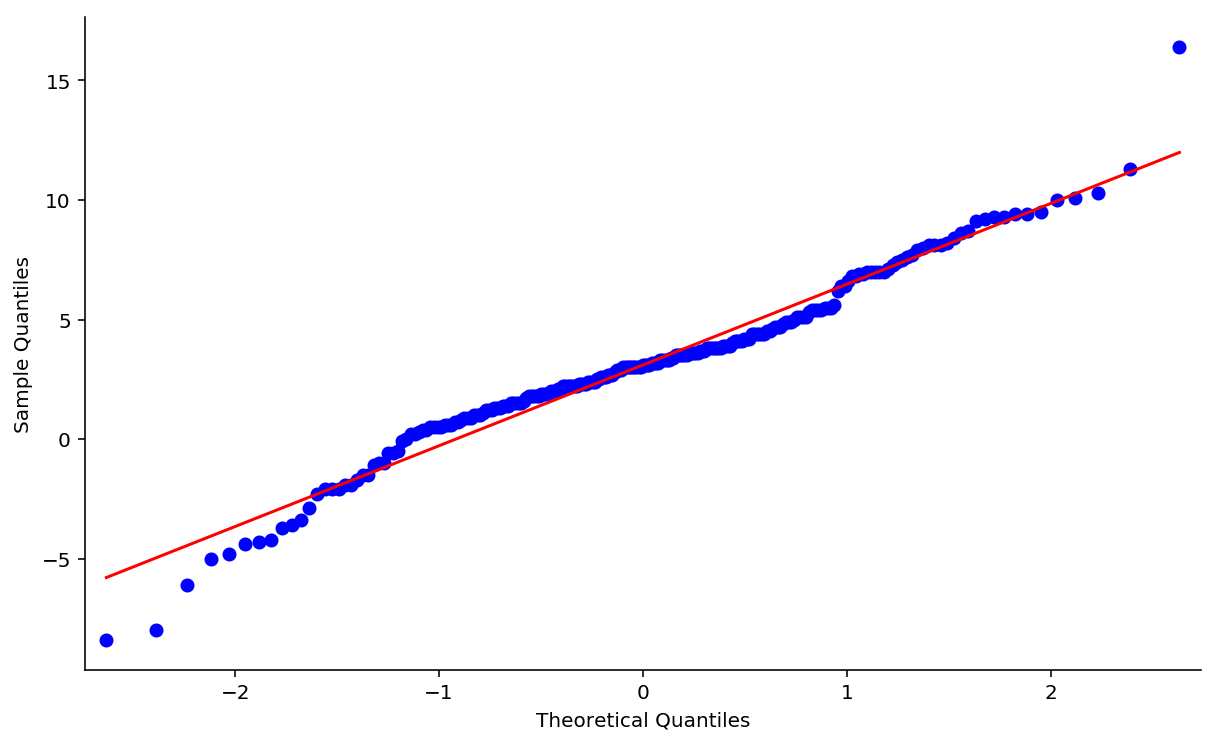

In [10]:
fig = sm.qqplot(df.values.squeeze(),line='r')
fig.set_size_inches(10,6)
sns.despine()

In [11]:
stat, pval = kstest_normal(df.values.squeeze())
print('The p-val is {}'.format(pval))
s = 'The distribution is Not Normal ' if pval <= 0.05 else 'The distribution is normal'
print(s)

The p-val is 0.0015955418301277261
The distribution is Not Normal 


## Rolling statisitcs

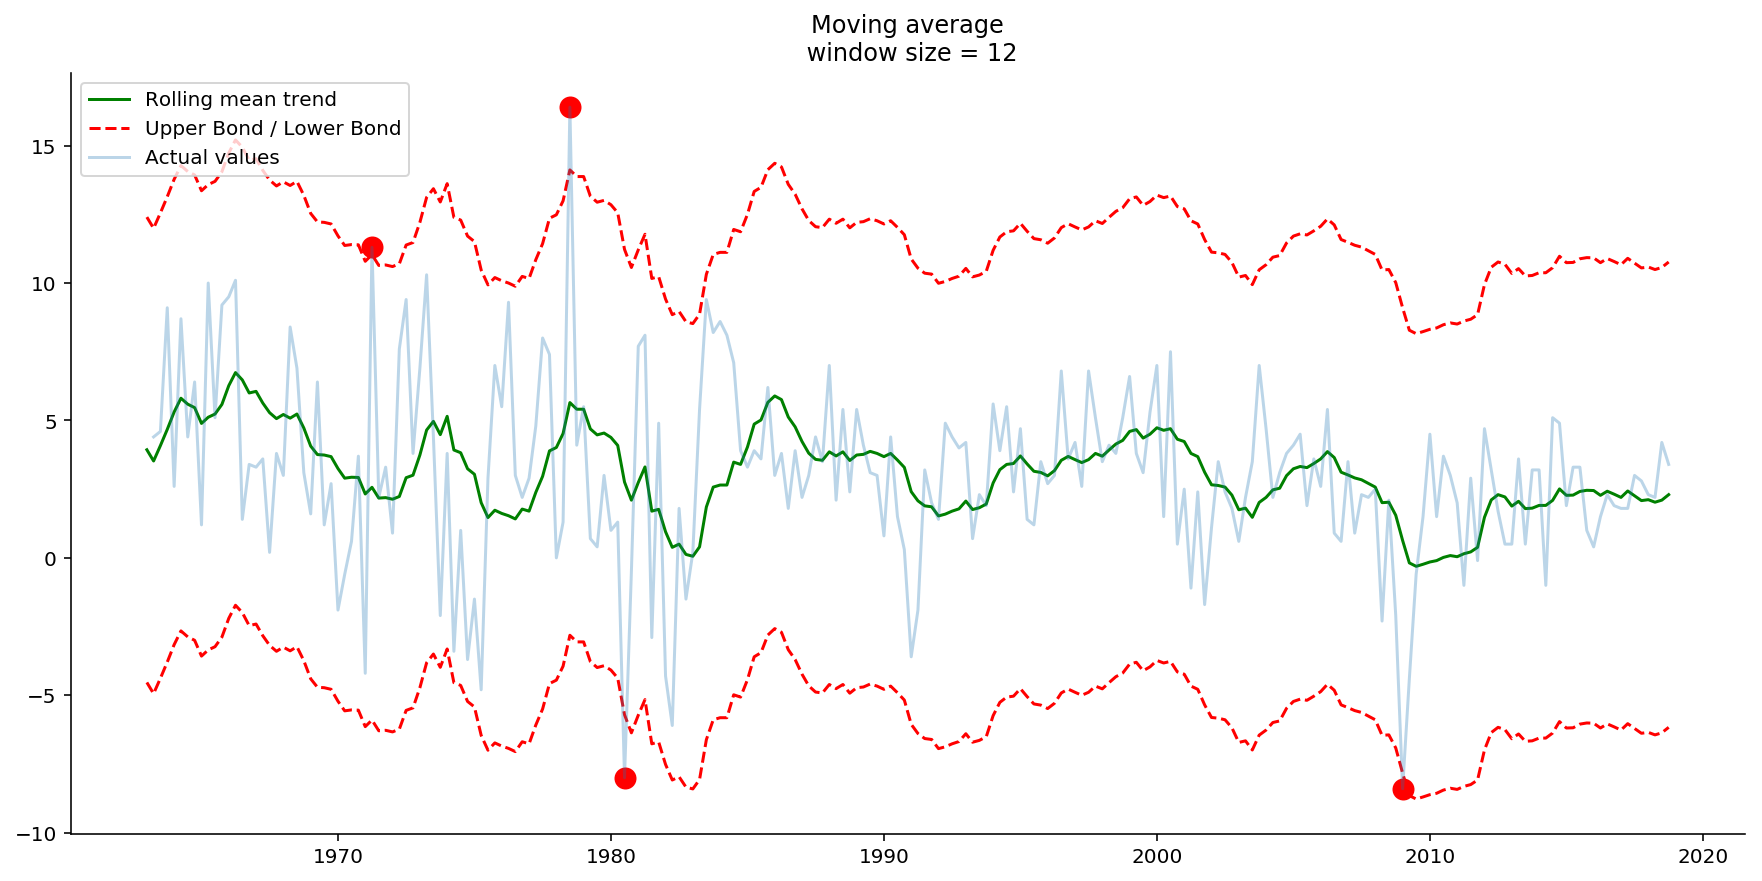

In [12]:
ts.plotMovingAverage(df, window = 12, plot_intervals=True,\
                      scale=1.96, plot_anomalies=True,\
                     figsize = [15,7])

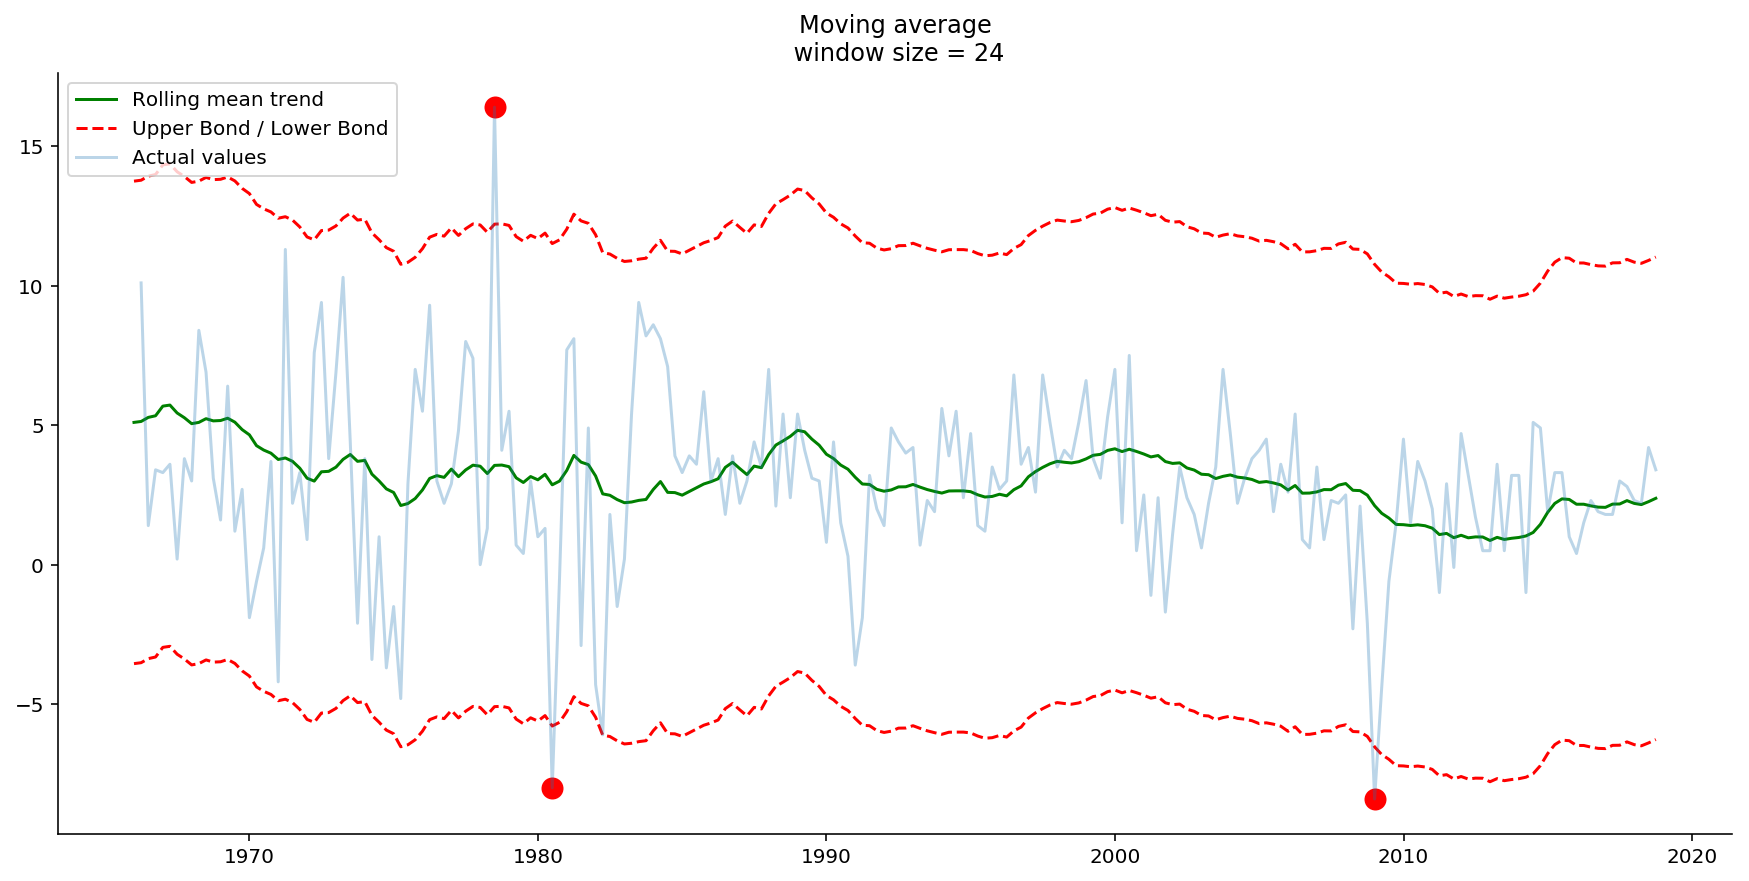

In [13]:
ts.plotMovingAverage(df, window = 24, plot_intervals=True,\
                      scale=1.96, plot_anomalies=True,\
                     figsize = [15,7])

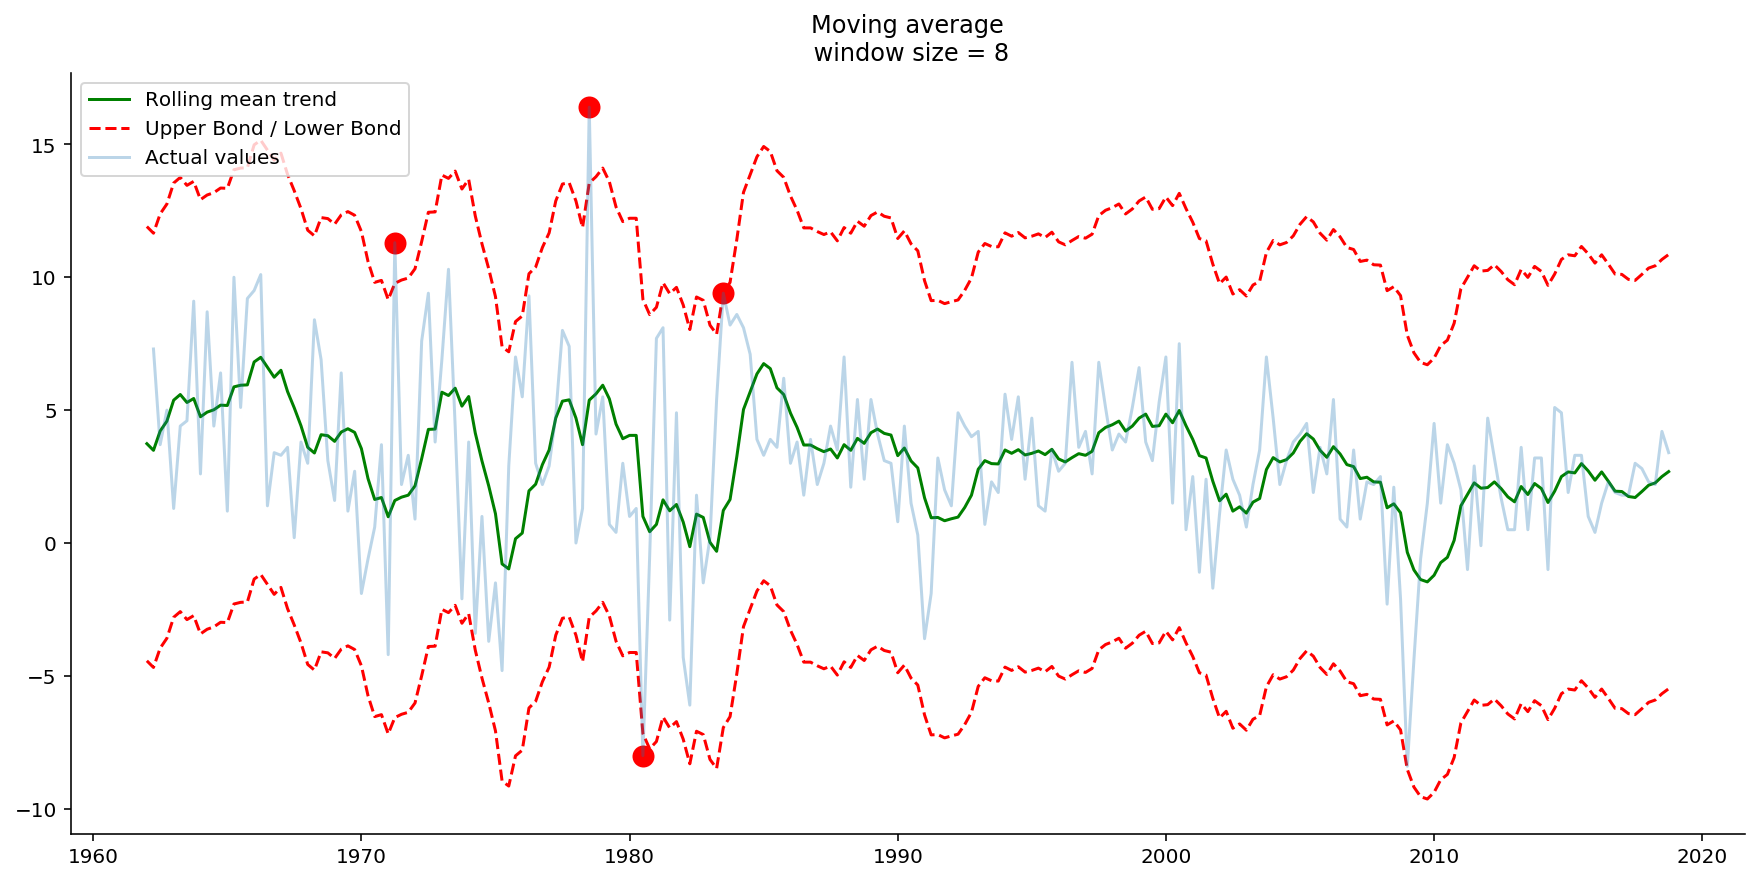

In [14]:
ts.plotMovingAverage(df, window = 8, plot_intervals=True,\
                      scale=1.96, plot_anomalies=True,\
                     figsize = [15,7])

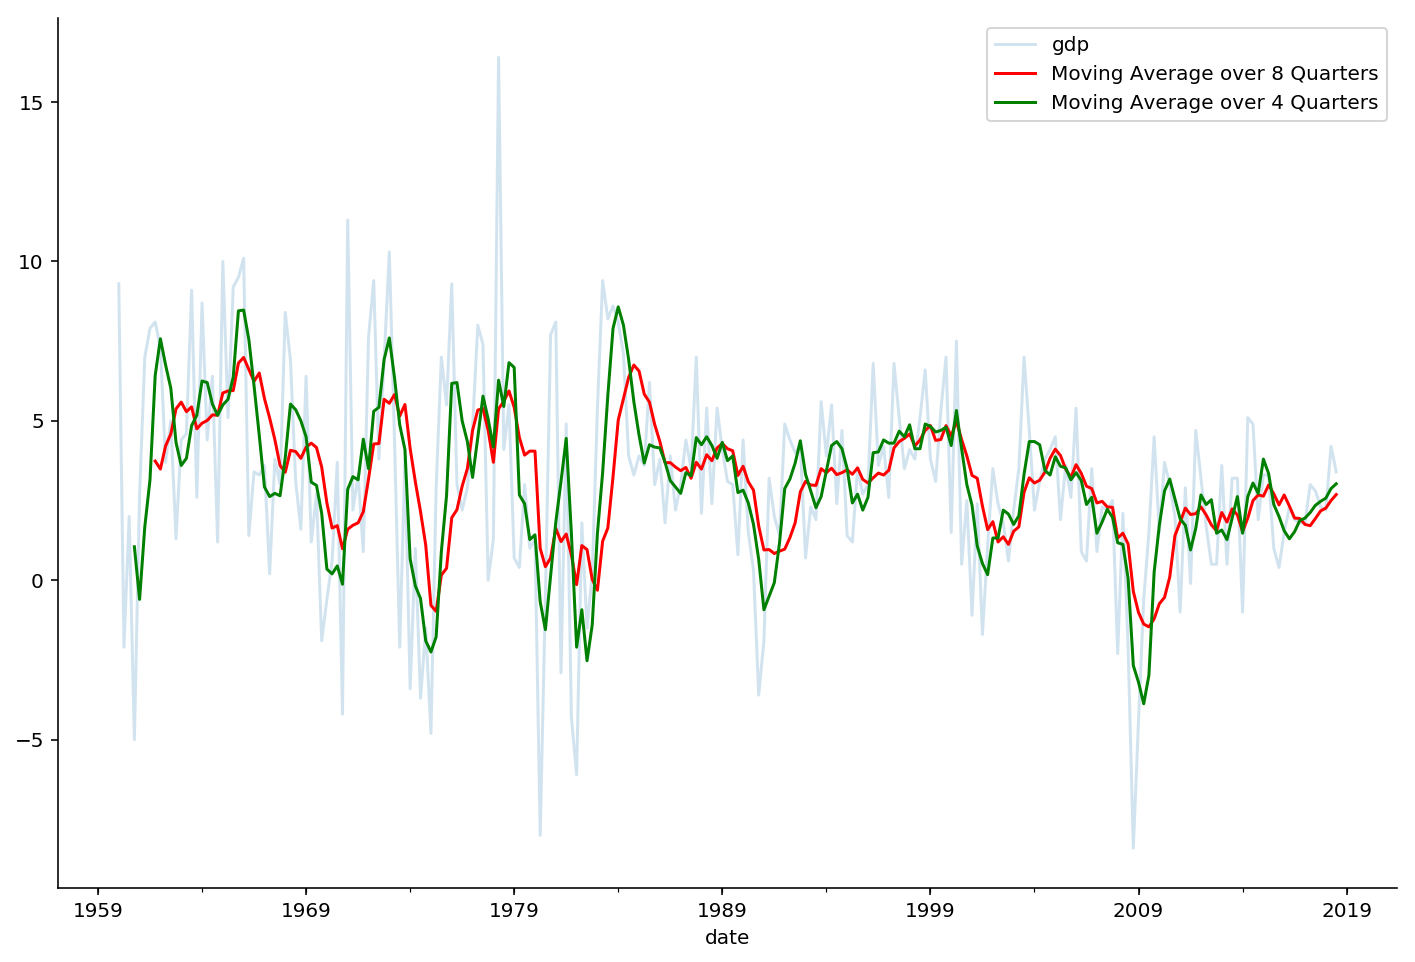

In [15]:
ts.compareMAs(df,window_1 = 8, window_2 = 4)

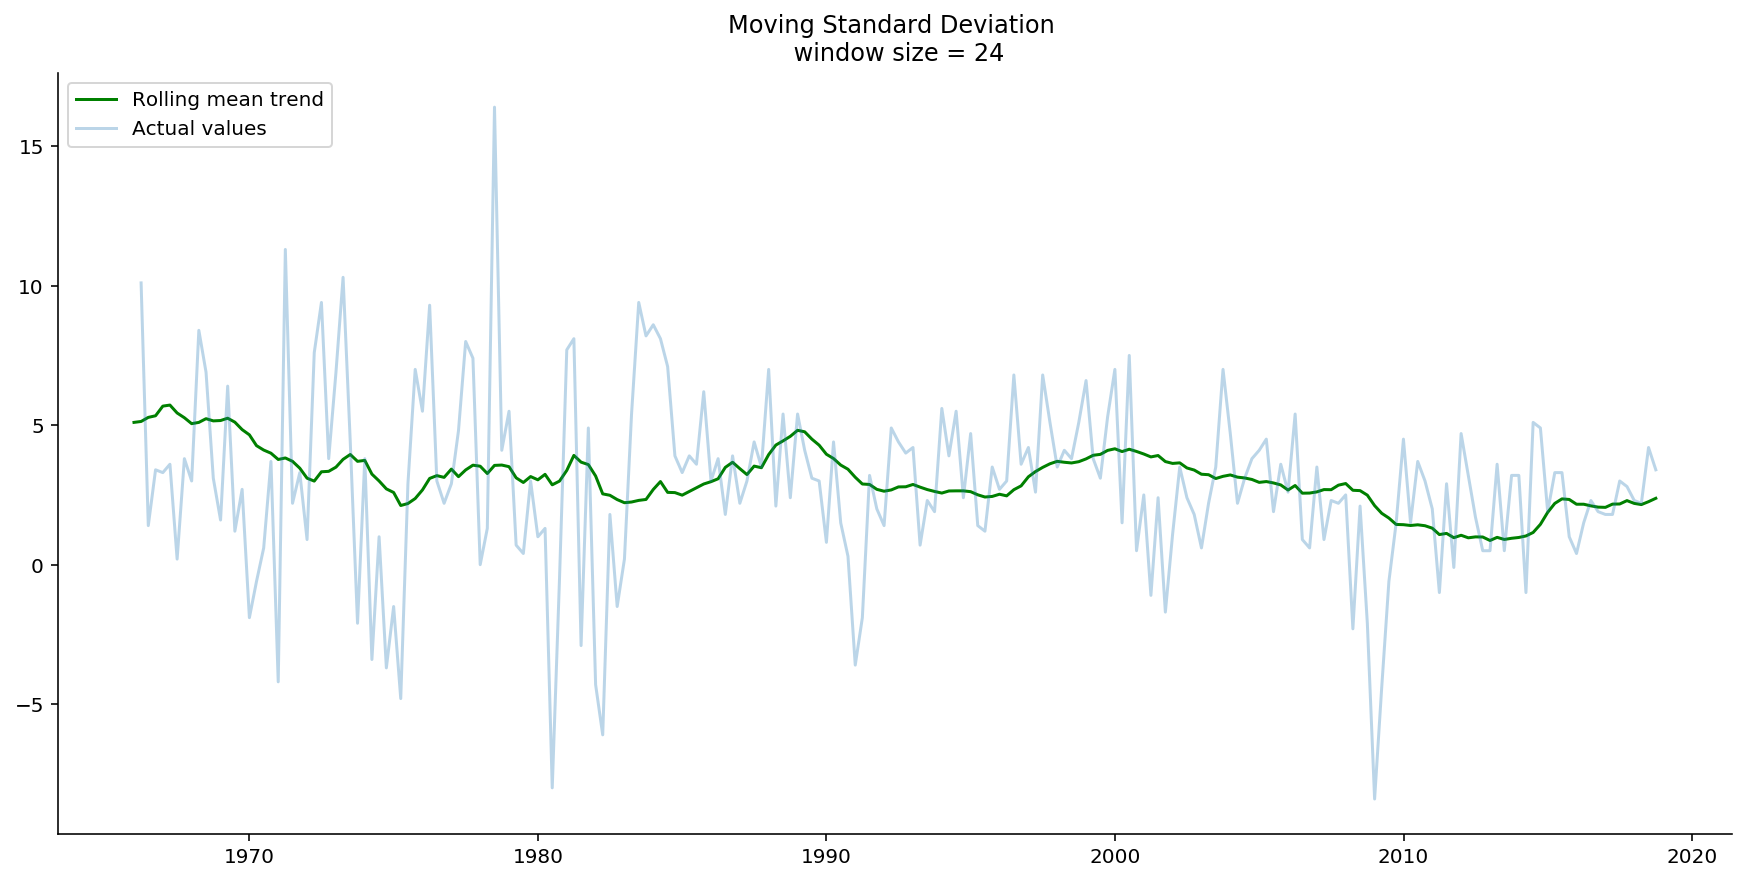

In [16]:
ts.plotMovingSDs(df,24)

## Trend and  Seasonal Decomposition

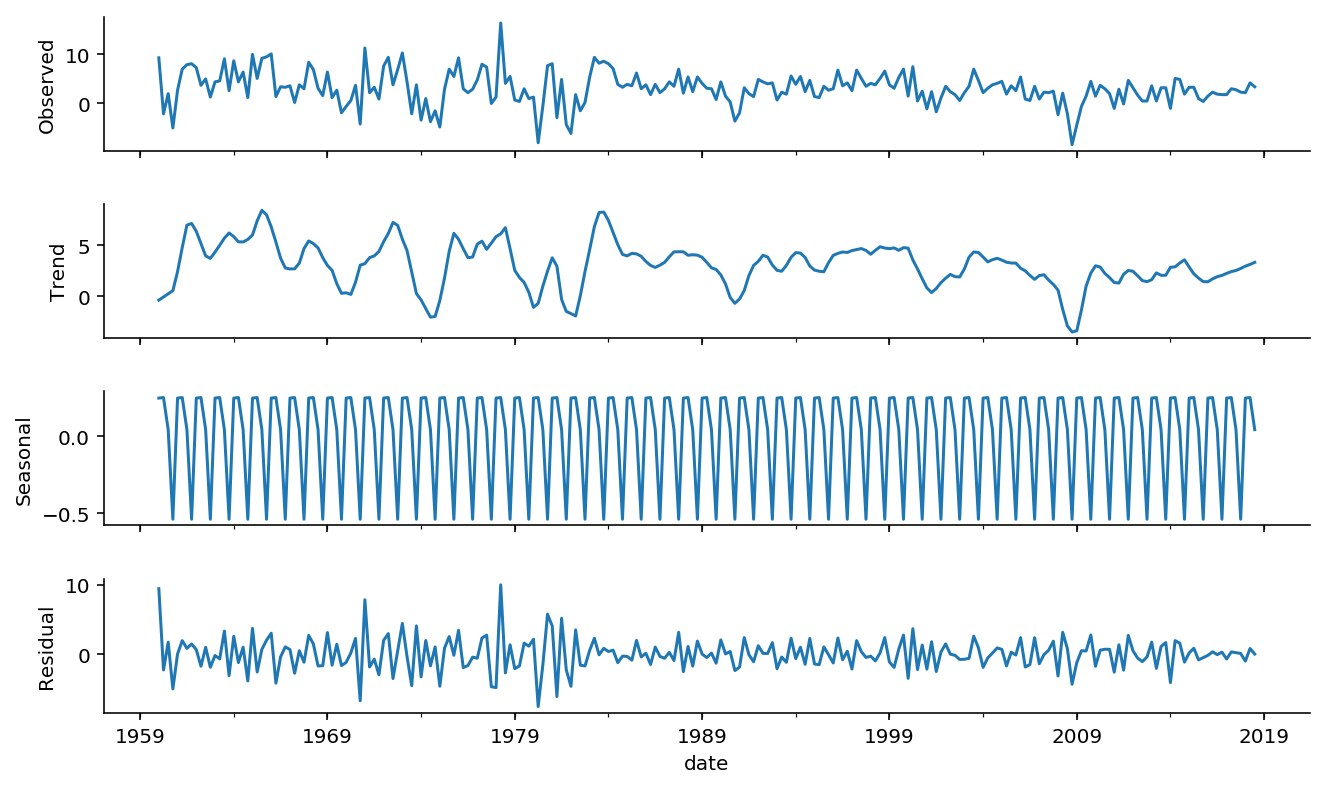

In [134]:
results = seasonal_decompose(df,extrapolate_trend=1)
fig = results.plot()
fig.set_size_inches(10,6)
sns.despine()

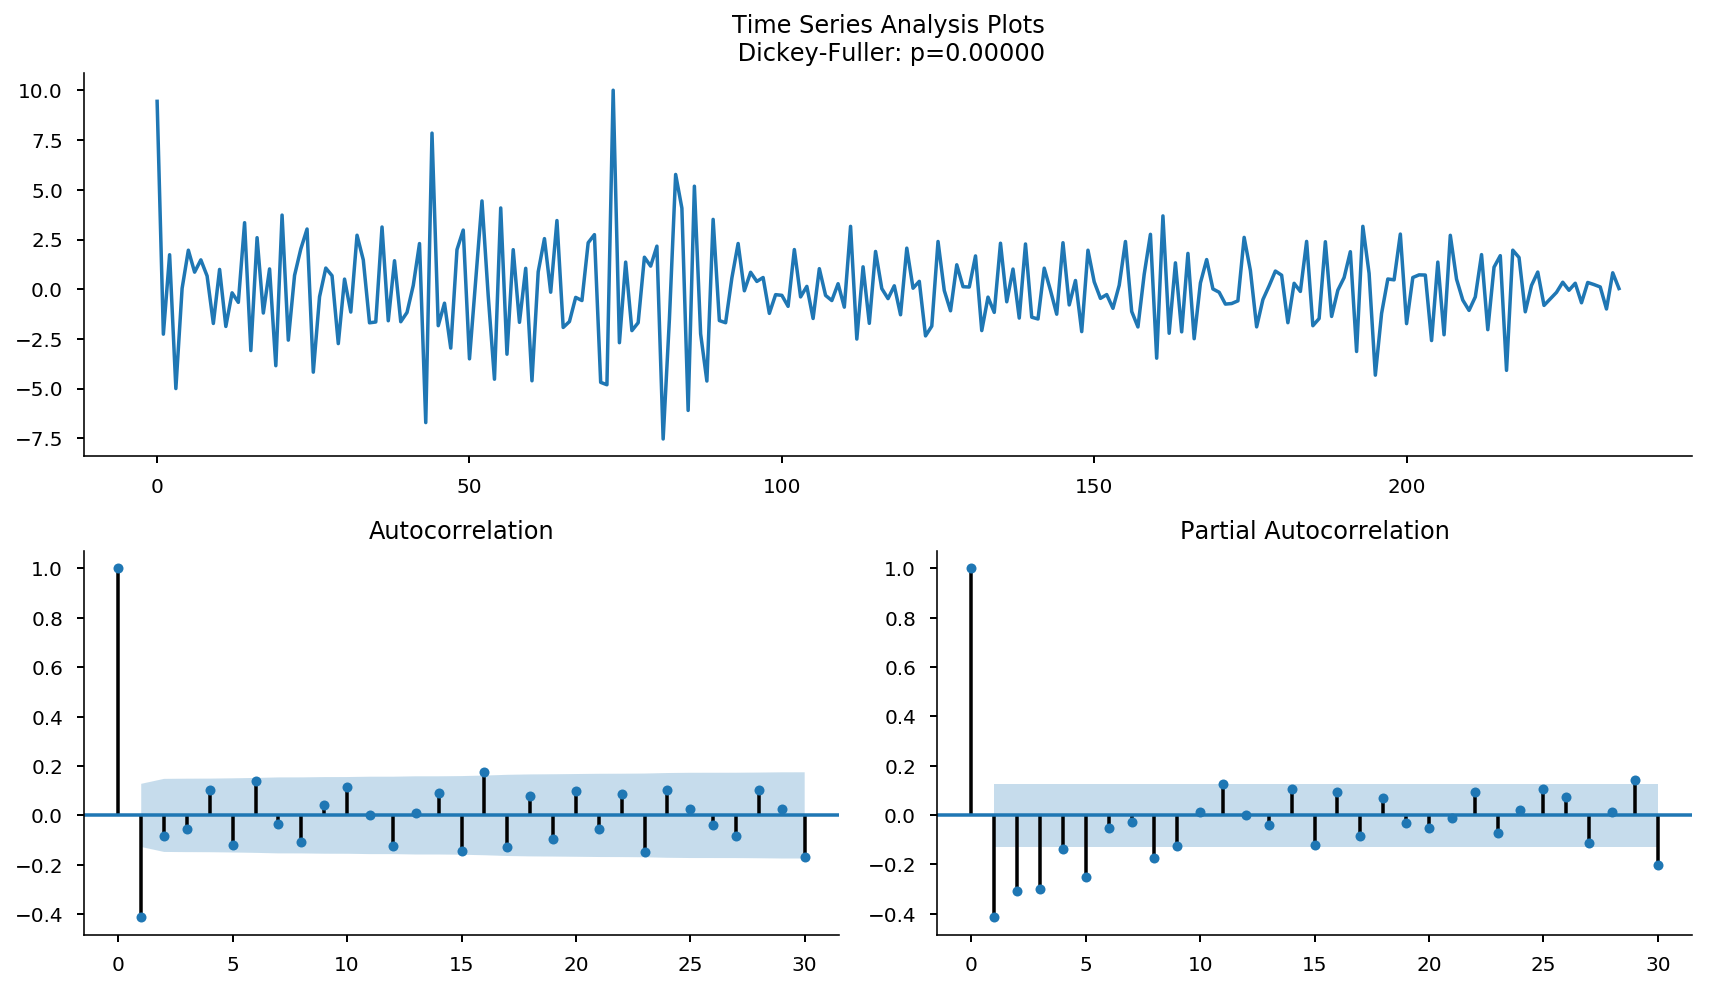

In [140]:
ts.tsplot(results.resid.values.squeeze(), lags=30)

### Residuals are at least AR(3) and MA1 pricess.. There seems to long term seasonality too

##  Test for Stationarity, Auto correlation Study

[Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)

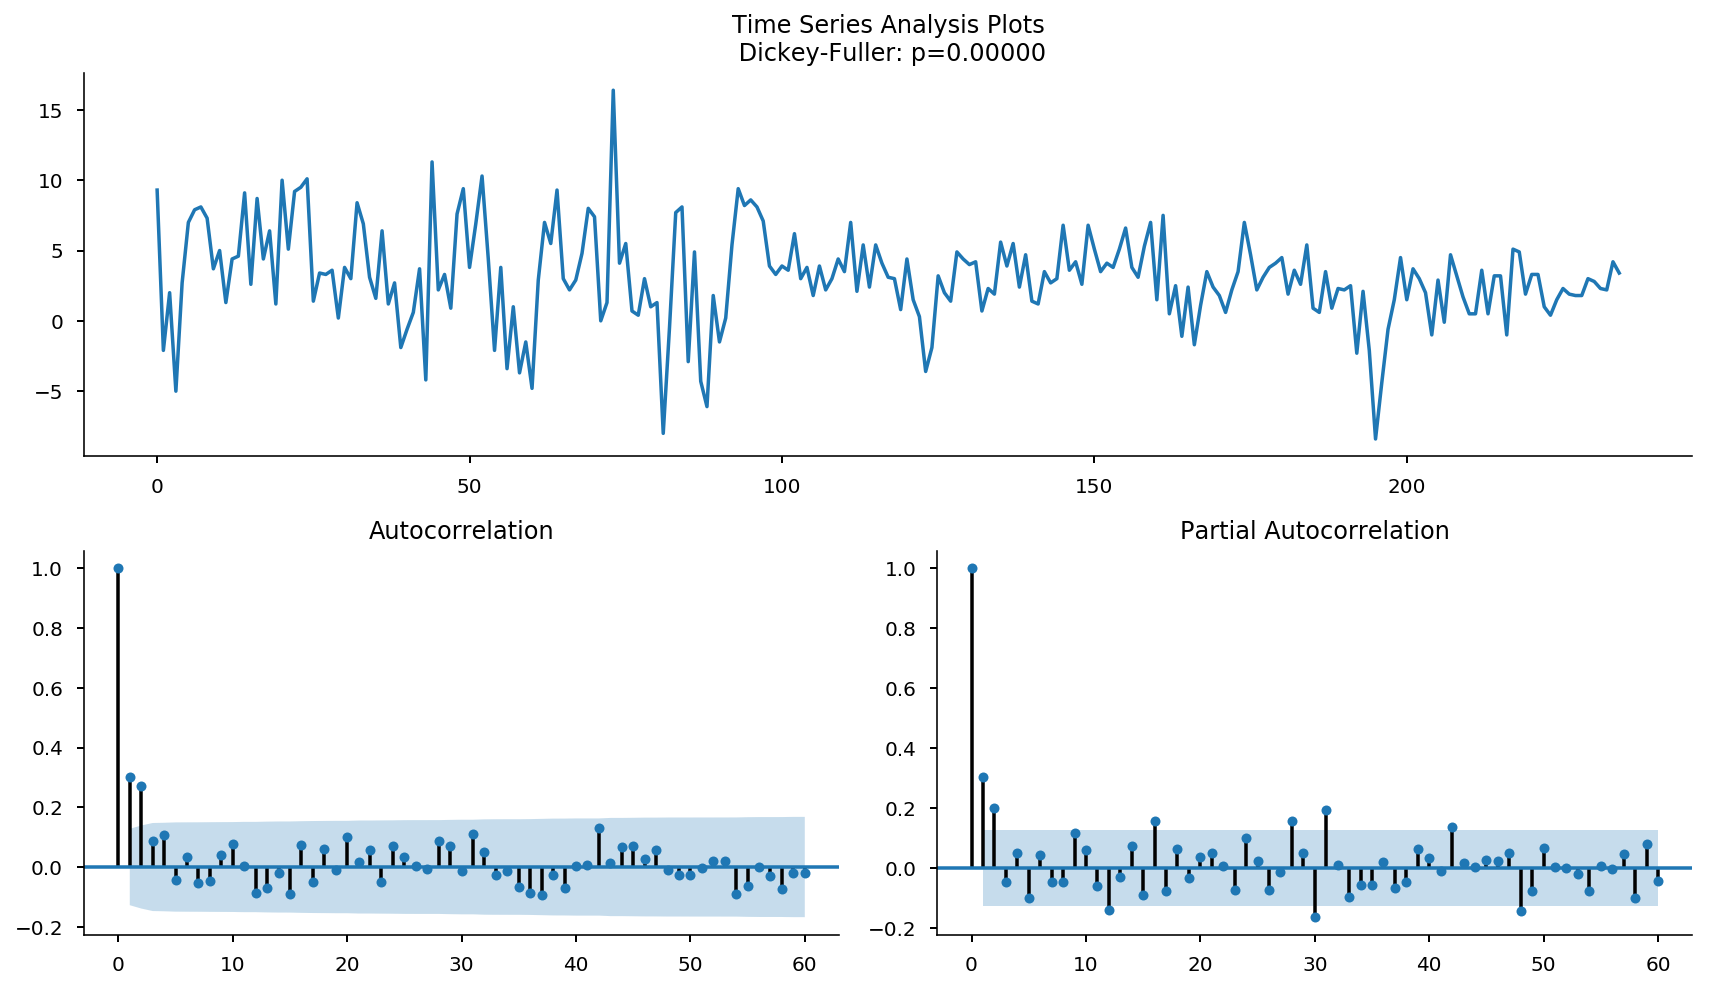

In [18]:
ts.tsplot(df.values.squeeze(), lags=60)

In [19]:
pacfs, confint = pacf(df.values.squeeze(),nlags = 60, alpha = 0.05)
np.where(np.abs(pacfs) > 0.10)

(array([ 0,  1,  2,  5,  9, 12, 16, 24, 28, 30, 31, 42, 48, 58]),)

It is surprising that initial series itself is stationary. The Dicky Fuller Test has rejected null hypothesis that unit root is present. Although, we did get the hint looking at moving averages and standard deviation. Interestingly, PACF shows long term auto-correlations hinting seasonality can be present.

## SARIMA

In [20]:
ps = range(1,3)
d = 1
qs = range(1,3)
Ps = range(0,3)
D = 1
Qs = range(0,3)
s = 12 # season length of 4 quaerters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [23]:
%%time
result_table = ts.optimizeSARIMA(df,parameters_list, d, D, s)

/Users/amiteshsinha/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/amiteshsinha/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



CPU times: user 2min 13s, sys: 32.6 s, total: 2min 45s
Wall time: 44.5 s


In [24]:
result_table.head()

parameters          aic
0  (2, 1, 0, 2)  1193.329435
1  (2, 1, 1, 1)  1194.162678
2  (2, 1, 2, 1)  1194.465068
3  (2, 1, 1, 2)  1194.571952
4  (2, 1, 0, 1)  1194.768359

In [25]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                gdp   No. Observations:                  235
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood                -590.665
Date:                            Sat, 26 Jan 2019   AIC                           1193.329
Time:                                    10:42:25   BIC                           1213.745
Sample:                                03-31-1960   HQIC                          1201.572
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2392      0.066      3.601      0.000       0.109       0.369
ar.L2          0.1910      0.054   

## Seasonally differenced Series

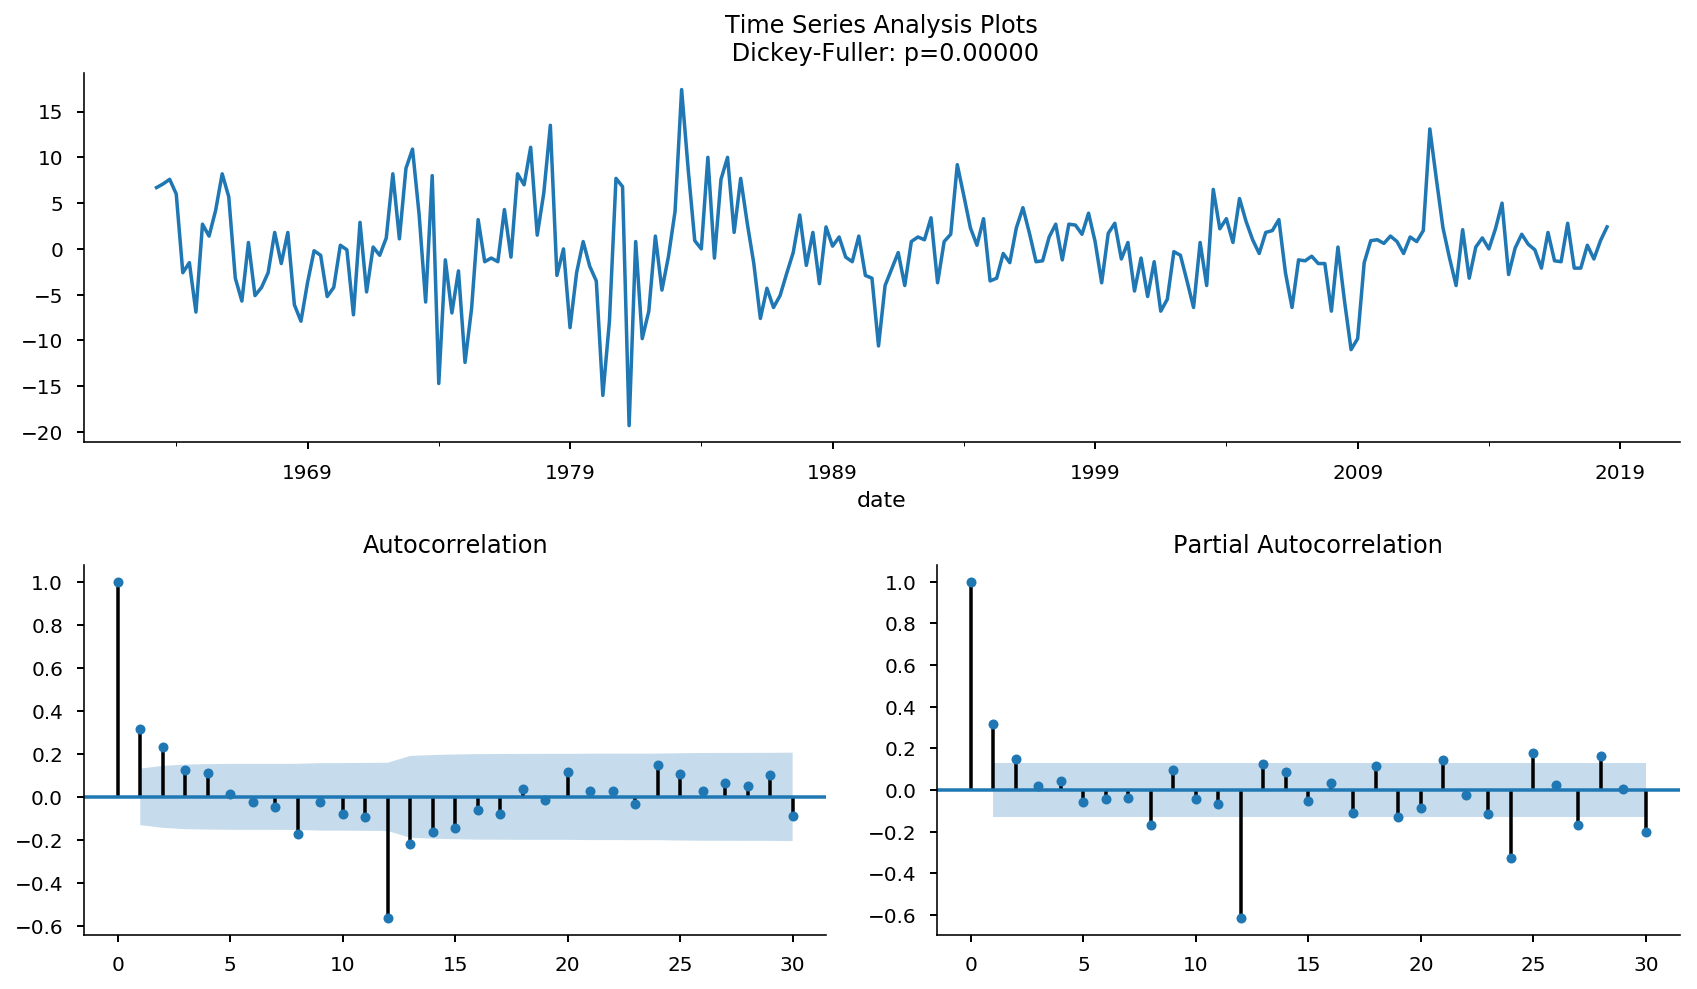

In [26]:
lag = 12
df_diff = df.gdp - df.gdp.shift(lag)
ts.tsplot(df_diff[lag + 1:],lags = 30)

## Residuals

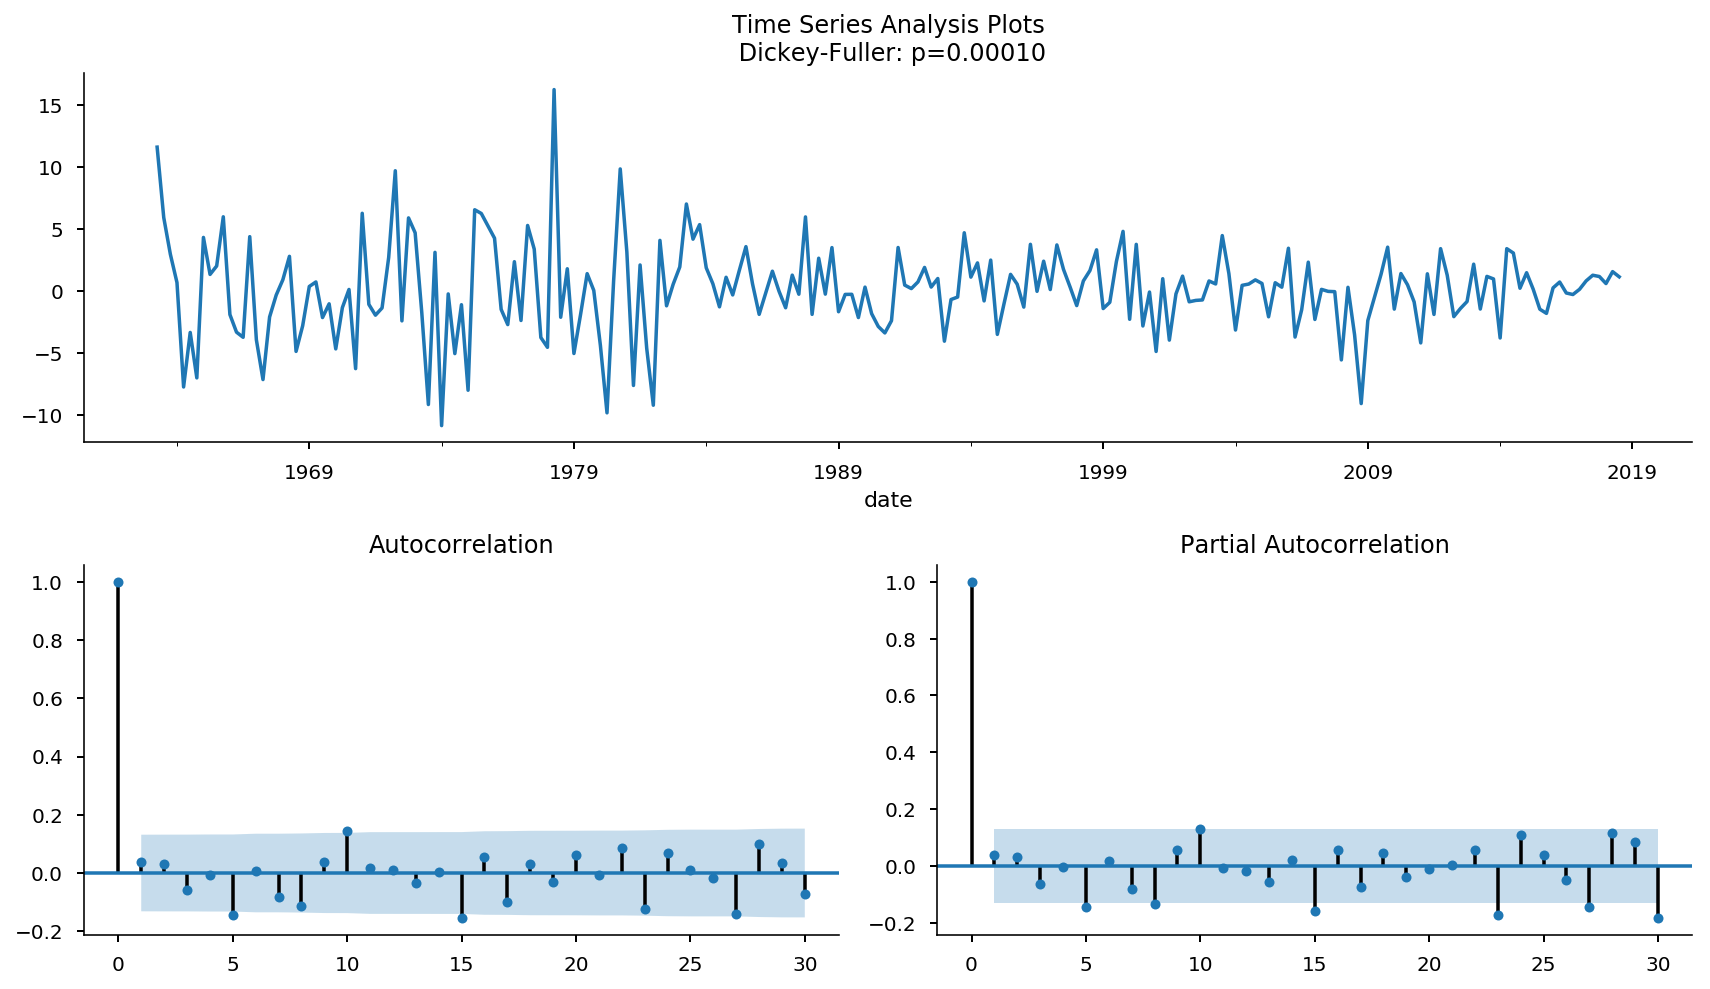

In [27]:
ts.tsplot(best_model.resid[s+1:], lags=30)

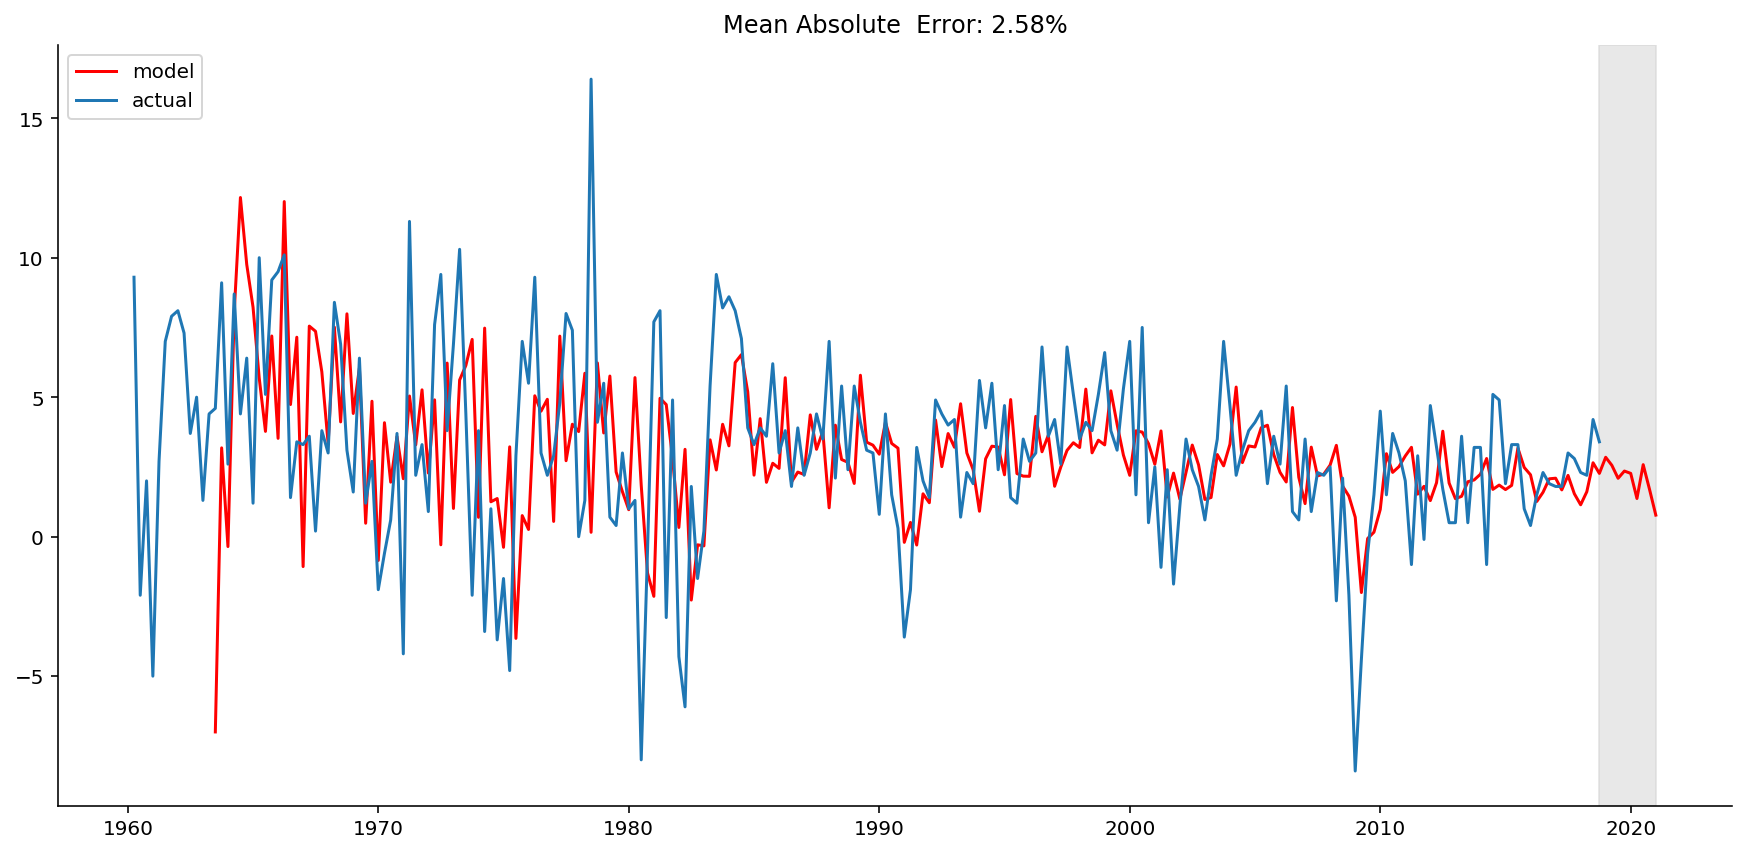

In [28]:
ts.plotSARIMA(df, best_model, 12, 1, 8)

## Forecasting using non econometric methods

### Linear Regression

In [105]:
data = pd.DataFrame(df.copy())
data.columns = ["y"]

In [106]:
for i in range(2, 16):
    data["lag_{}".format(i)] = data.y.shift(i)

In [107]:
data.tail(7)

y  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
date                                                                      
2017-03-31  1.8    1.9    2.3    1.5    0.4    1.0    3.3    3.3    1.9   
2017-06-30  3.0    1.8    1.9    2.3    1.5    0.4    1.0    3.3    3.3   
2017-09-30  2.8    1.8    1.8    1.9    2.3    1.5    0.4    1.0    3.3   
2017-12-31  2.3    3.0    1.8    1.8    1.9    2.3    1.5    0.4    1.0   
2018-03-31  2.2    2.8    3.0    1.8    1.8    1.9    2.3    1.5    0.4   
2018-06-30  4.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3    1.5   
2018-09-30  3.4    2.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3   

            lag_10  lag_11  lag_12  lag_13  lag_14  lag_15  
date                                                        
2017-03-31     4.9     5.1    -1.0     3.2     3.2     0.5  
2017-06-30     1.9     4.9     5.1    -1.0     3.2     3.2  
2017-09-30     3.3     1.9     4.9     5.1    -1.0     3.2  
2017-12-31     3.3     3.3     1.9     4.9     5.1    -1.0  
2018-03-31     1.0     3.3     3.3     1.9     4.9     5.1  
2018-06-30     0.4     1.0     3.3     3.3     1.9     4.9  
2018-09-30     1.5     0.4     1.0     3.3     3.3     1.9

In [108]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=3)

In [109]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

In [110]:
# Apply linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

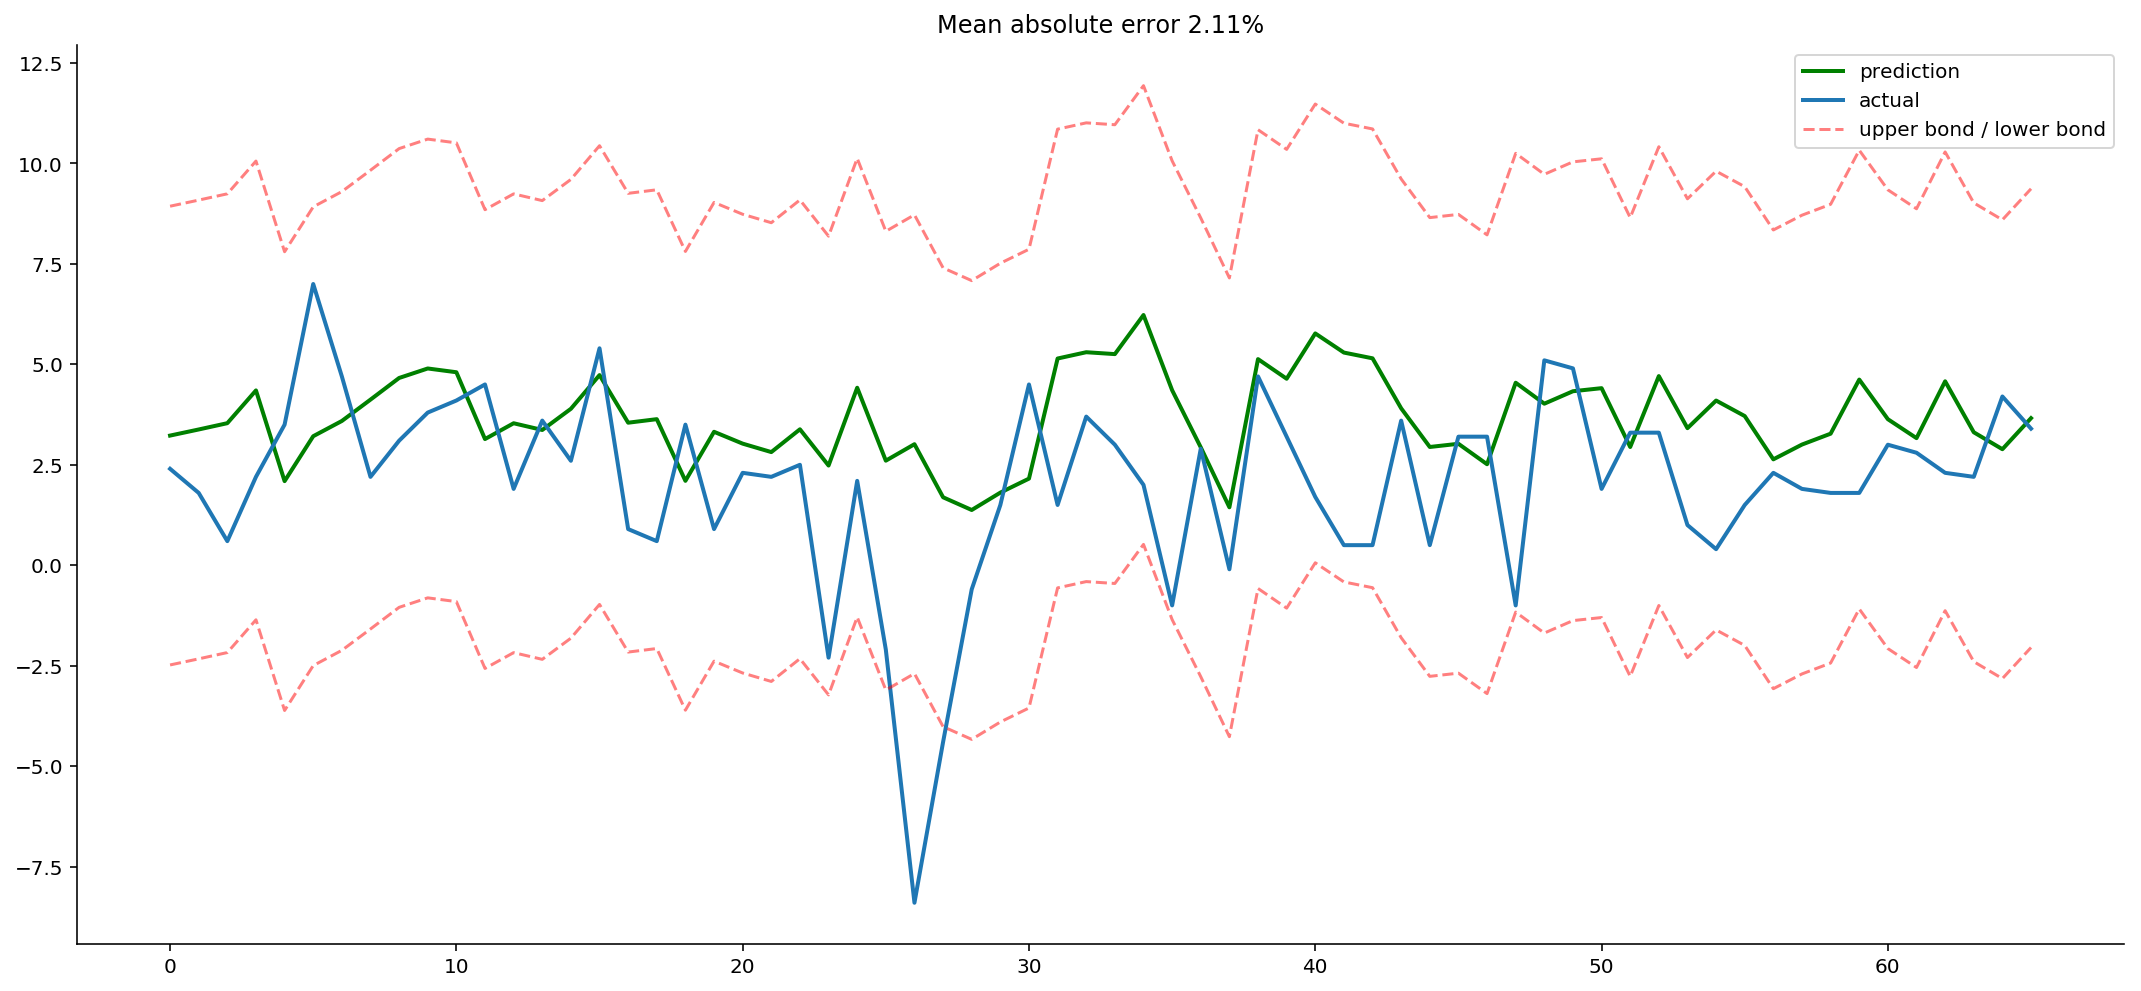

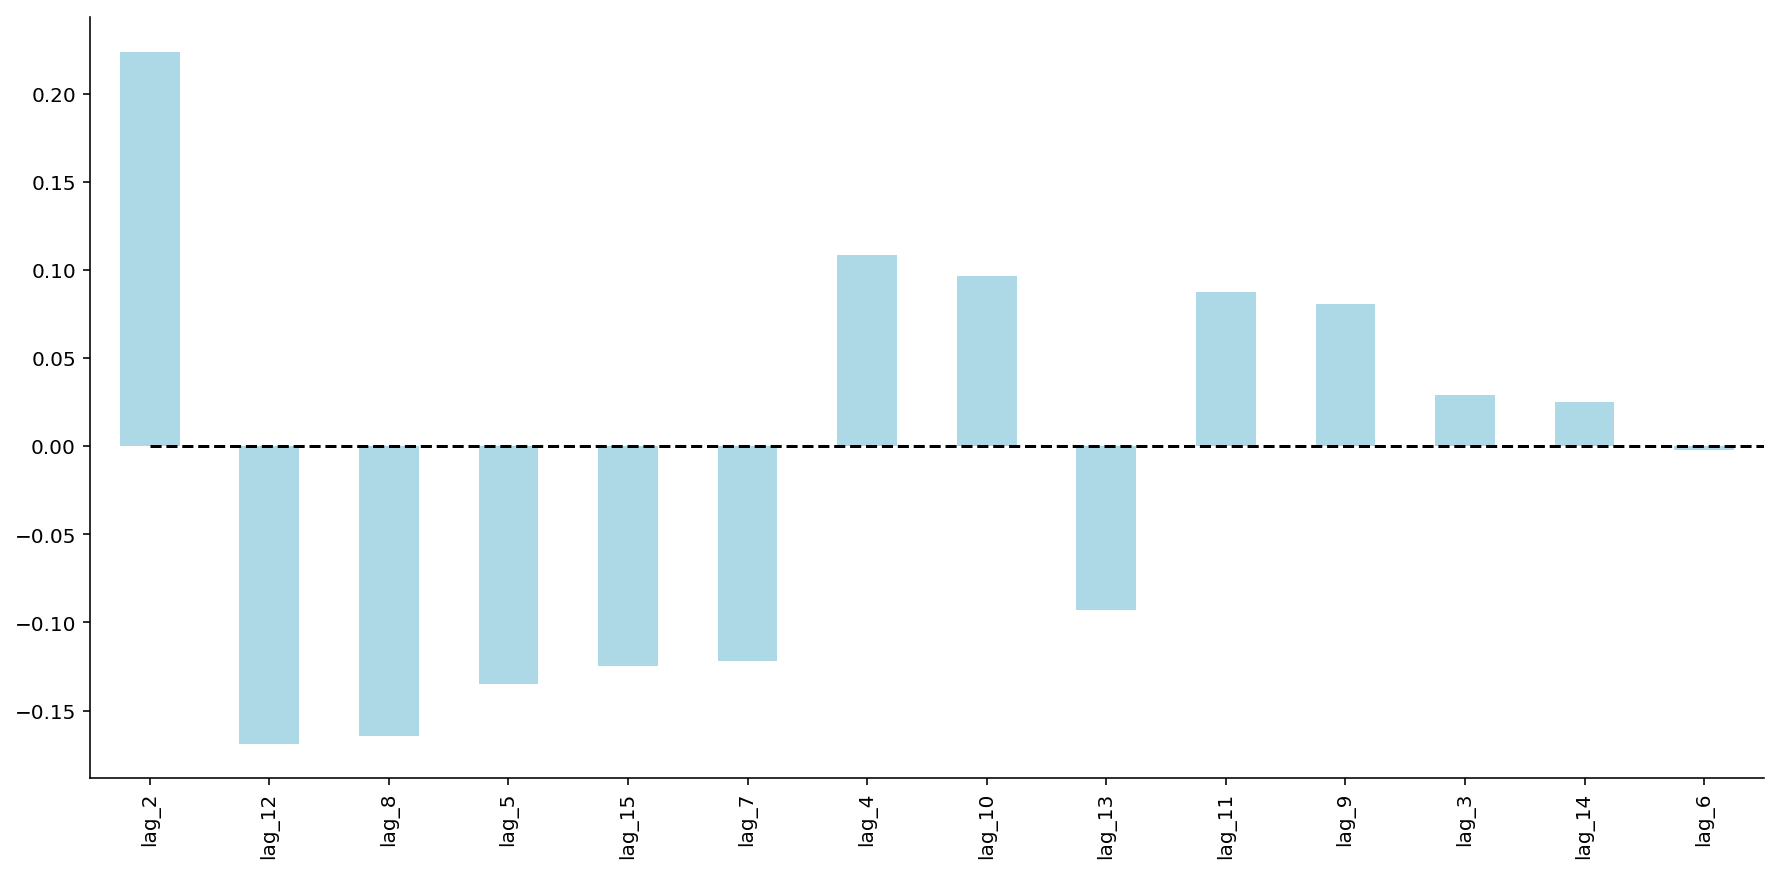

In [111]:
ts.plotModelResults(lr,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(lr,X_train)

### Regression after accounting for Quarter Number

In [112]:
data_Q = data.copy(deep=True)
data_Q['quarter'] = data_Q.index.quarter
data_Q.tail()

y  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
date                                                                      
2017-09-30  2.8    1.8    1.8    1.9    2.3    1.5    0.4    1.0    3.3   
2017-12-31  2.3    3.0    1.8    1.8    1.9    2.3    1.5    0.4    1.0   
2018-03-31  2.2    2.8    3.0    1.8    1.8    1.9    2.3    1.5    0.4   
2018-06-30  4.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3    1.5   
2018-09-30  3.4    2.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3   

            lag_10  lag_11  lag_12  lag_13  lag_14  lag_15  quarter  
date                                                                 
2017-09-30     3.3     1.9     4.9     5.1    -1.0     3.2        3  
2017-12-31     3.3     3.3     1.9     4.9     5.1    -1.0        4  
2018-03-31     1.0     3.3     3.3     1.9     4.9     5.1        1  
2018-06-30     0.4     1.0     3.3     3.3     1.9     4.9        2  
2018-09-30     1.5     0.4     1.0     3.3     3.3     1.9        3

In [113]:
quarter_dummies = pd.get_dummies(data_Q.quarter,prefix='Q')
quarter_dummies.tail()

Q_1  Q_2  Q_3  Q_4
date                          
2017-09-30    0    0    1    0
2017-12-31    0    0    0    1
2018-03-31    1    0    0    0
2018-06-30    0    1    0    0
2018-09-30    0    0    1    0

In [114]:
data_Q = pd.concat([data_Q, quarter_dummies],axis = 1)

In [116]:
data_Q.columns

Index(['y', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15',
       'quarter', 'Q_1', 'Q_2', 'Q_3', 'Q_4'],
      dtype='object')

In [117]:
data_Q = data_Q.drop(labels = ['Q_4','quarter'],axis = 1) ## Drop unnecesary variable

In [118]:
data_Q.tail()

y  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
date                                                                      
2017-09-30  2.8    1.8    1.8    1.9    2.3    1.5    0.4    1.0    3.3   
2017-12-31  2.3    3.0    1.8    1.8    1.9    2.3    1.5    0.4    1.0   
2018-03-31  2.2    2.8    3.0    1.8    1.8    1.9    2.3    1.5    0.4   
2018-06-30  4.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3    1.5   
2018-09-30  3.4    2.2    2.3    2.8    3.0    1.8    1.8    1.9    2.3   

            lag_10  lag_11  lag_12  lag_13  lag_14  lag_15  Q_1  Q_2  Q_3  
date                                                                       
2017-09-30     3.3     1.9     4.9     5.1    -1.0     3.2    0    0    1  
2017-12-31     3.3     3.3     1.9     4.9     5.1    -1.0    0    0    0  
2018-03-31     1.0     3.3     3.3     1.9     4.9     5.1    1    0    0  
2018-06-30     0.4     1.0     3.3     3.3     1.9     4.9    0    1    0  
2018-09-30     1.5     0.4     1.0     3.3     3.3     1.9    0    0    1

In [119]:
y = data_Q.dropna().y
X = data_Q.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

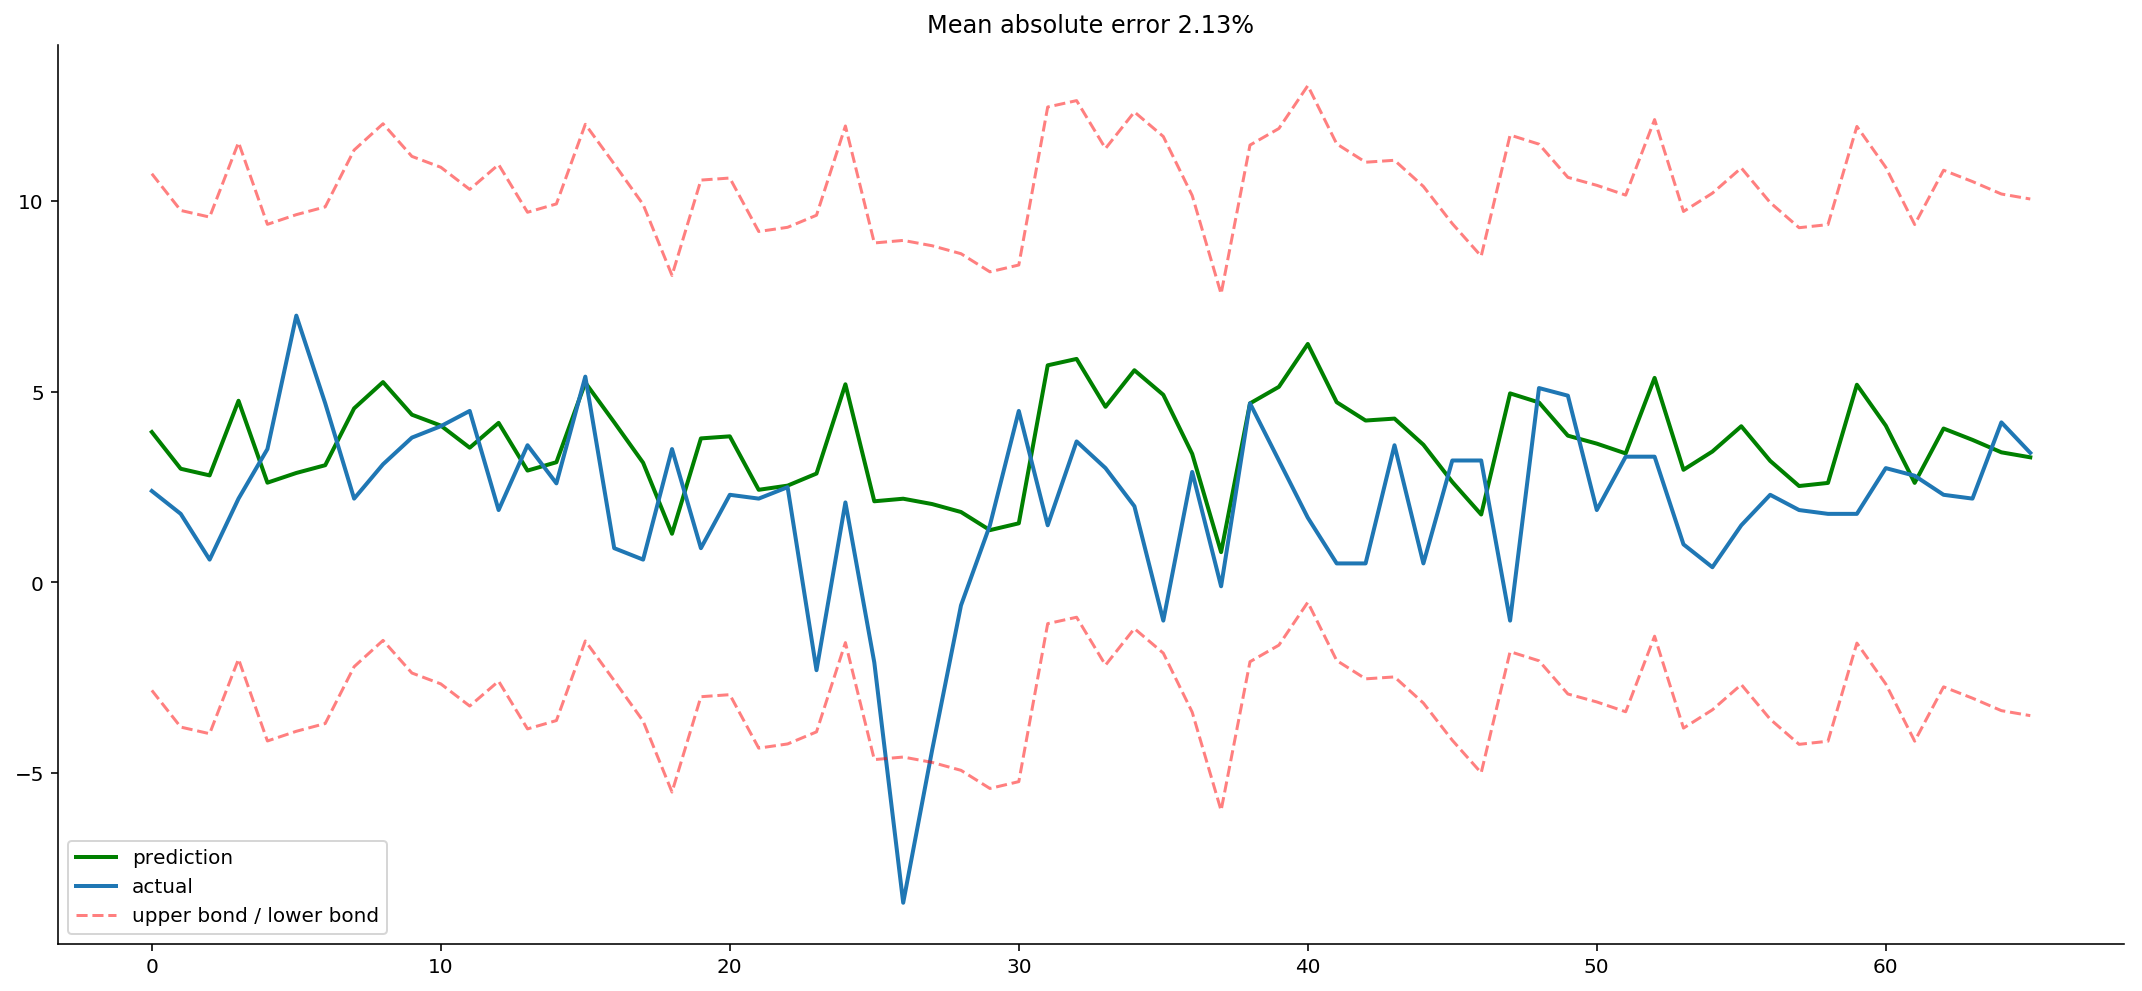

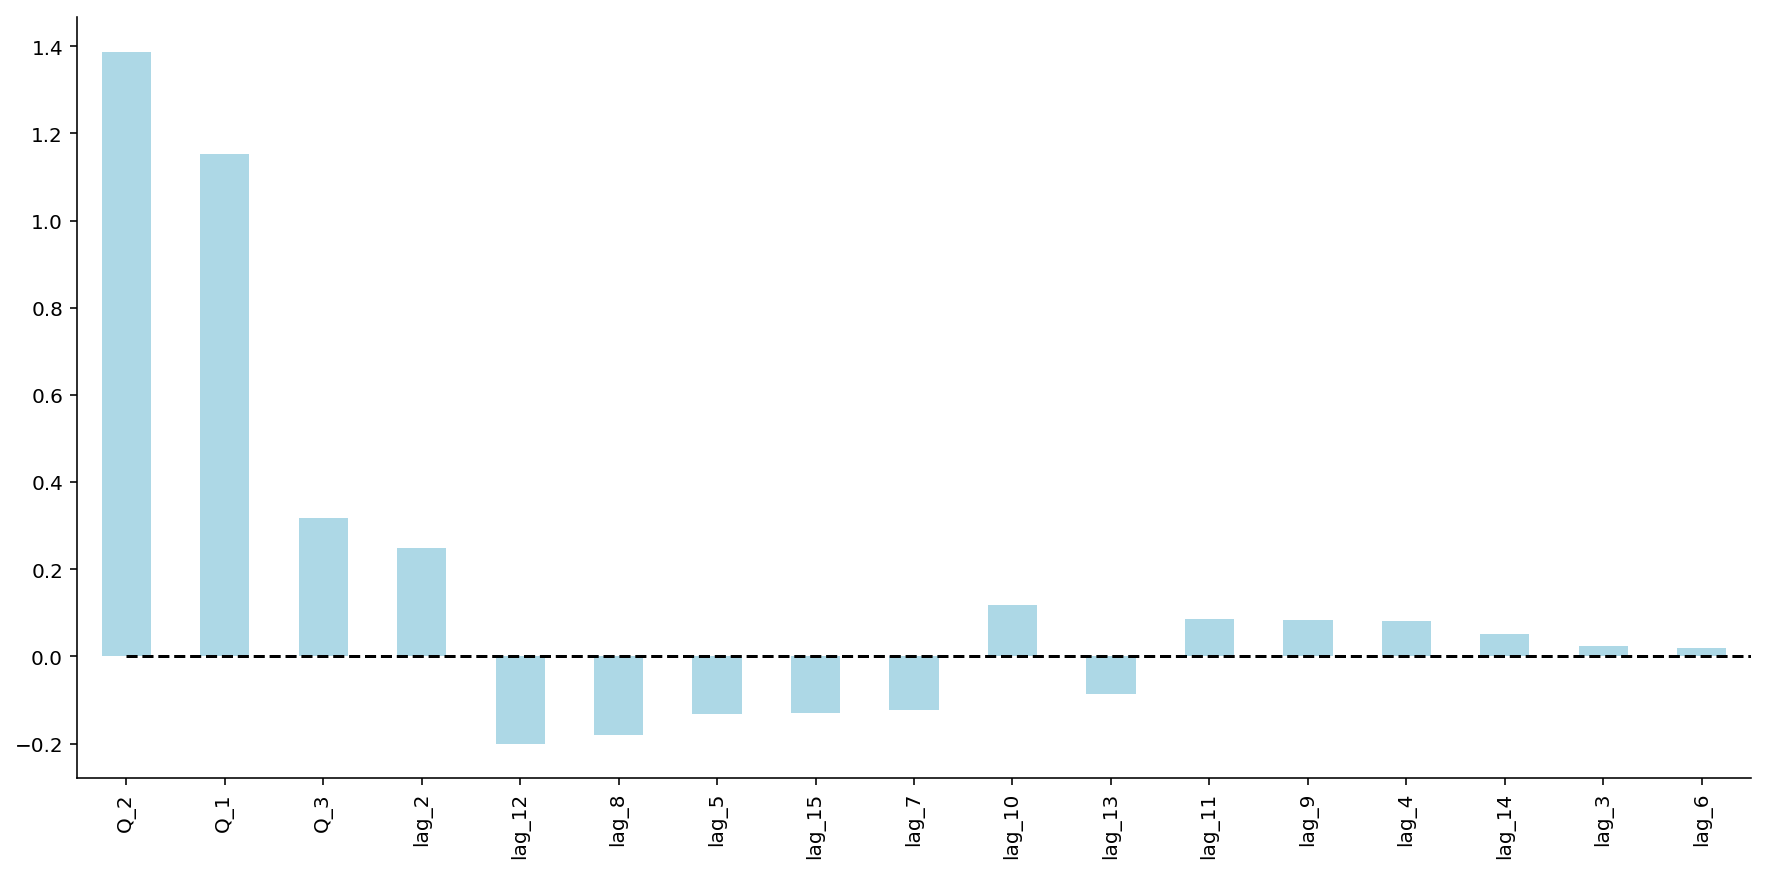

In [120]:
ts.plotModelResults(lr,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(lr,X_train)

### Regularization and feature selection

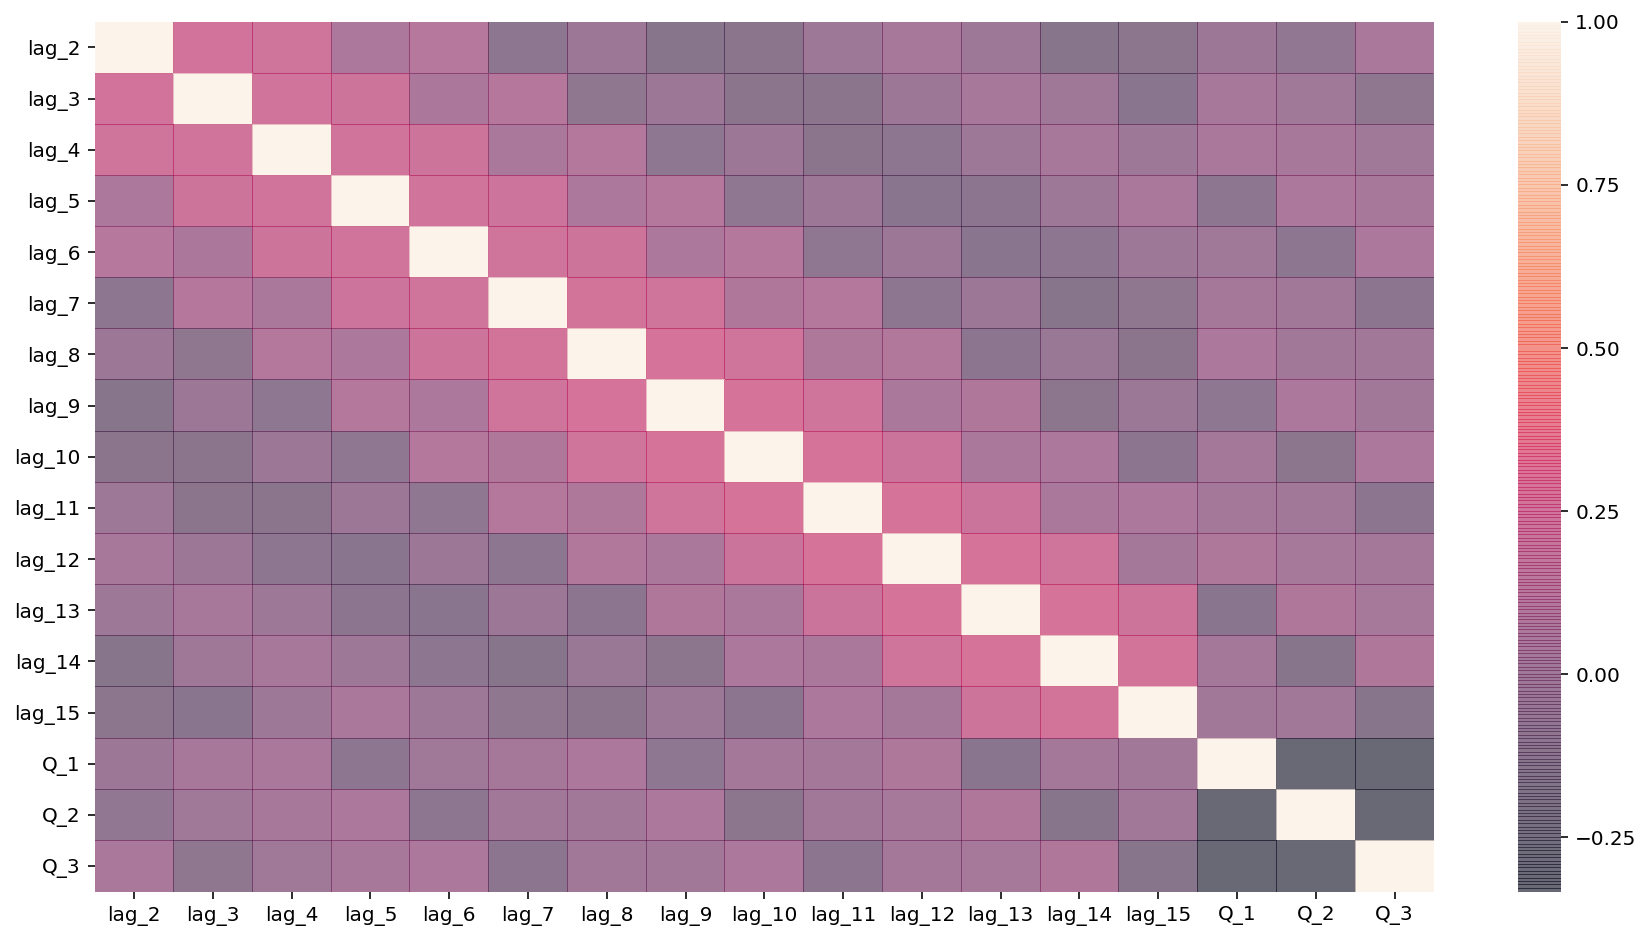

In [122]:
plt.figure(figsize=(15, 8))
sns.heatmap(X_train.corr(), alpha = 0.6);

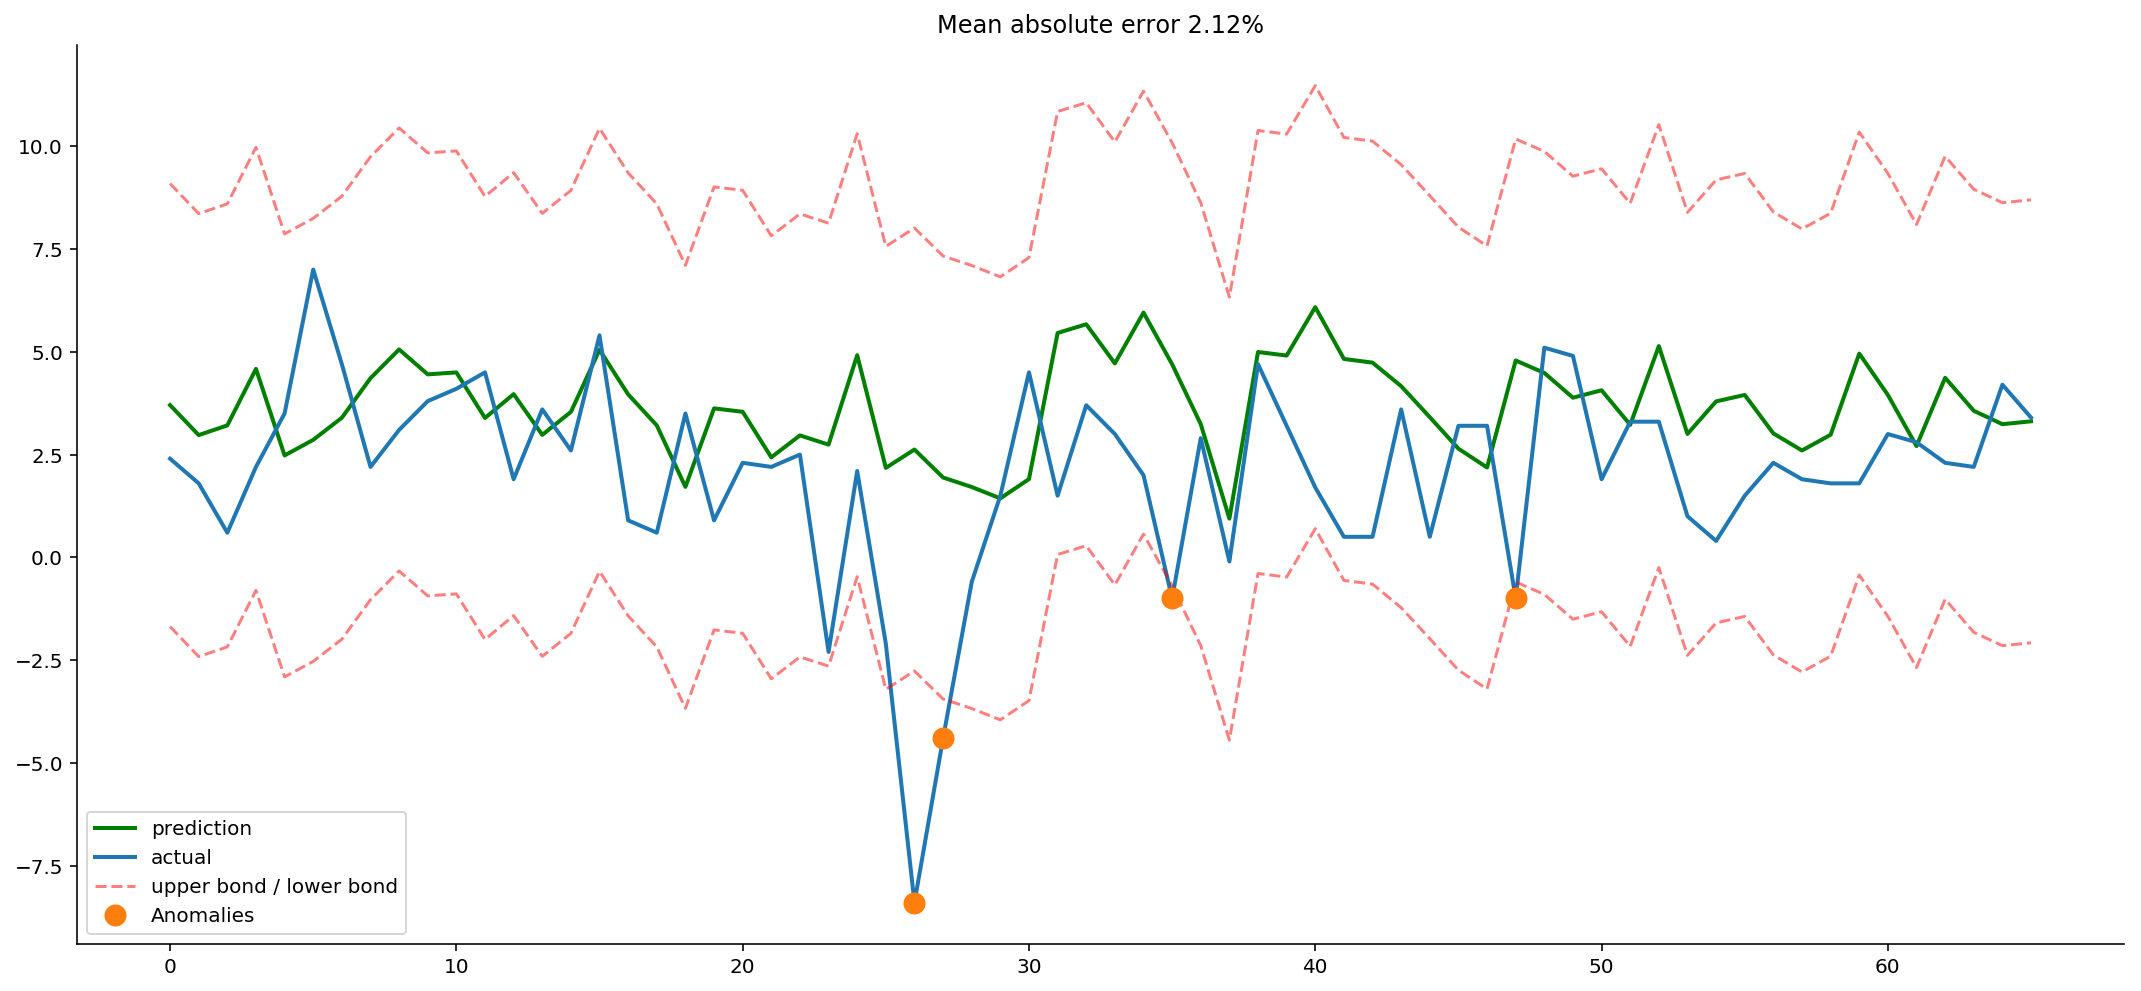

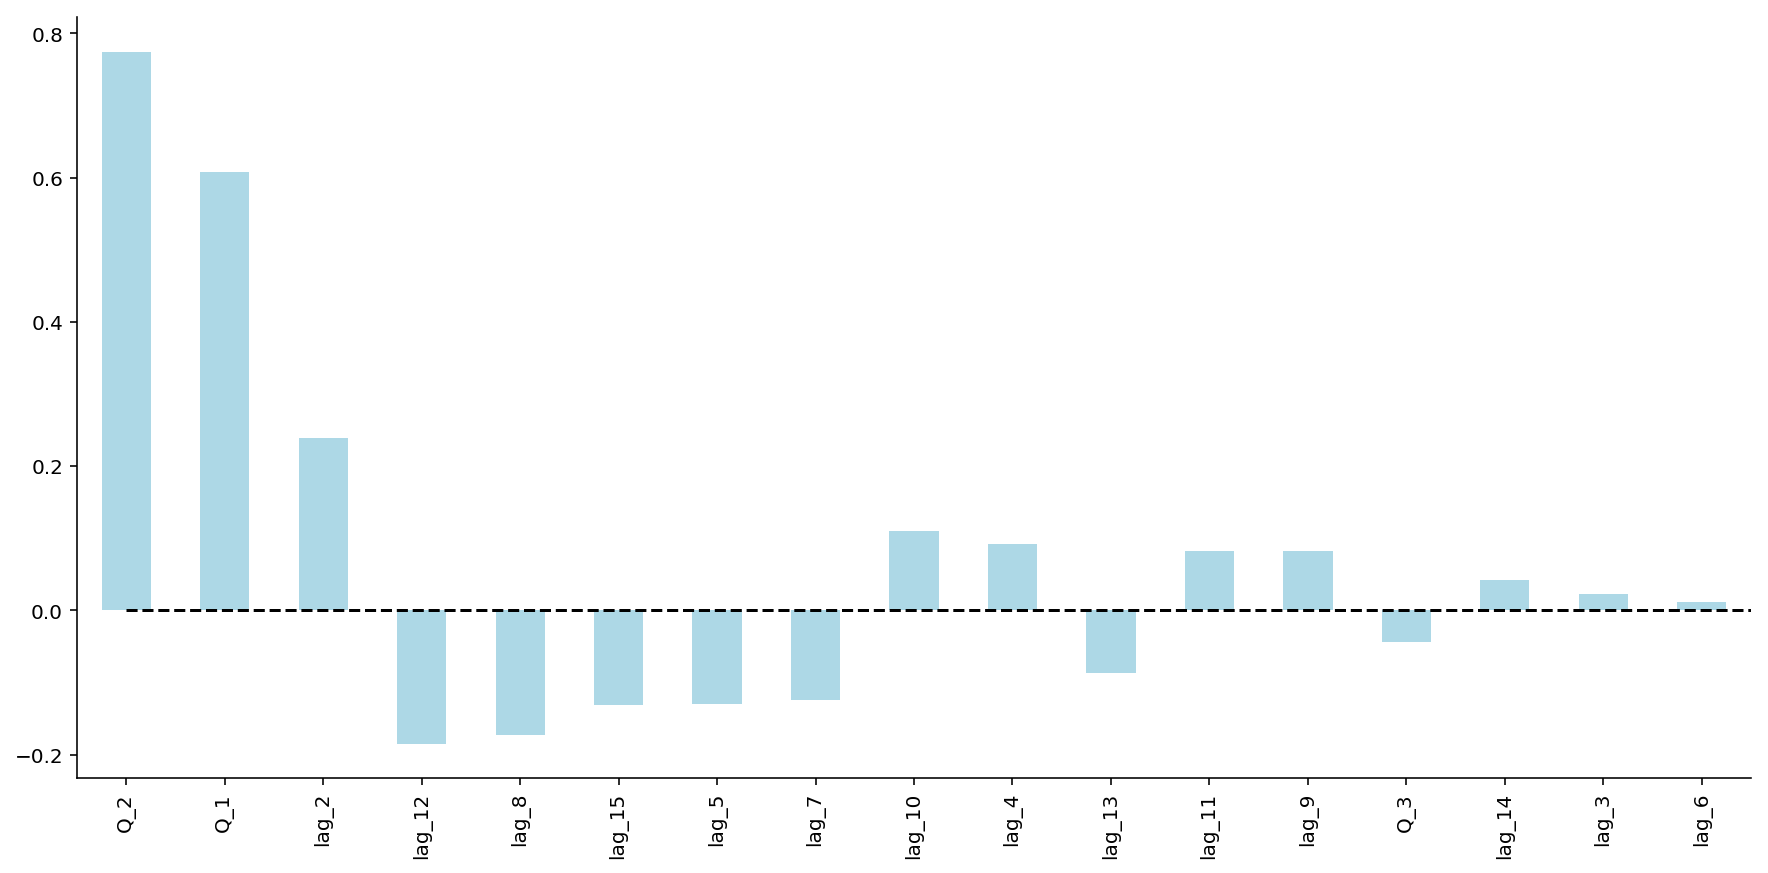

In [123]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

ts.plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 y_train = y_train, y_test = y_test, tscv = tscv,
                 plot_intervals=True, plot_anomalies=True)
ts.plotCoefficients(ridge,X_train)

## Boosting

In [124]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)
xgb = XGBRegressor(max_depth=1, n_estimators = 10, learning_rate = 0.07)
xgb.fit(X_train, y_train);

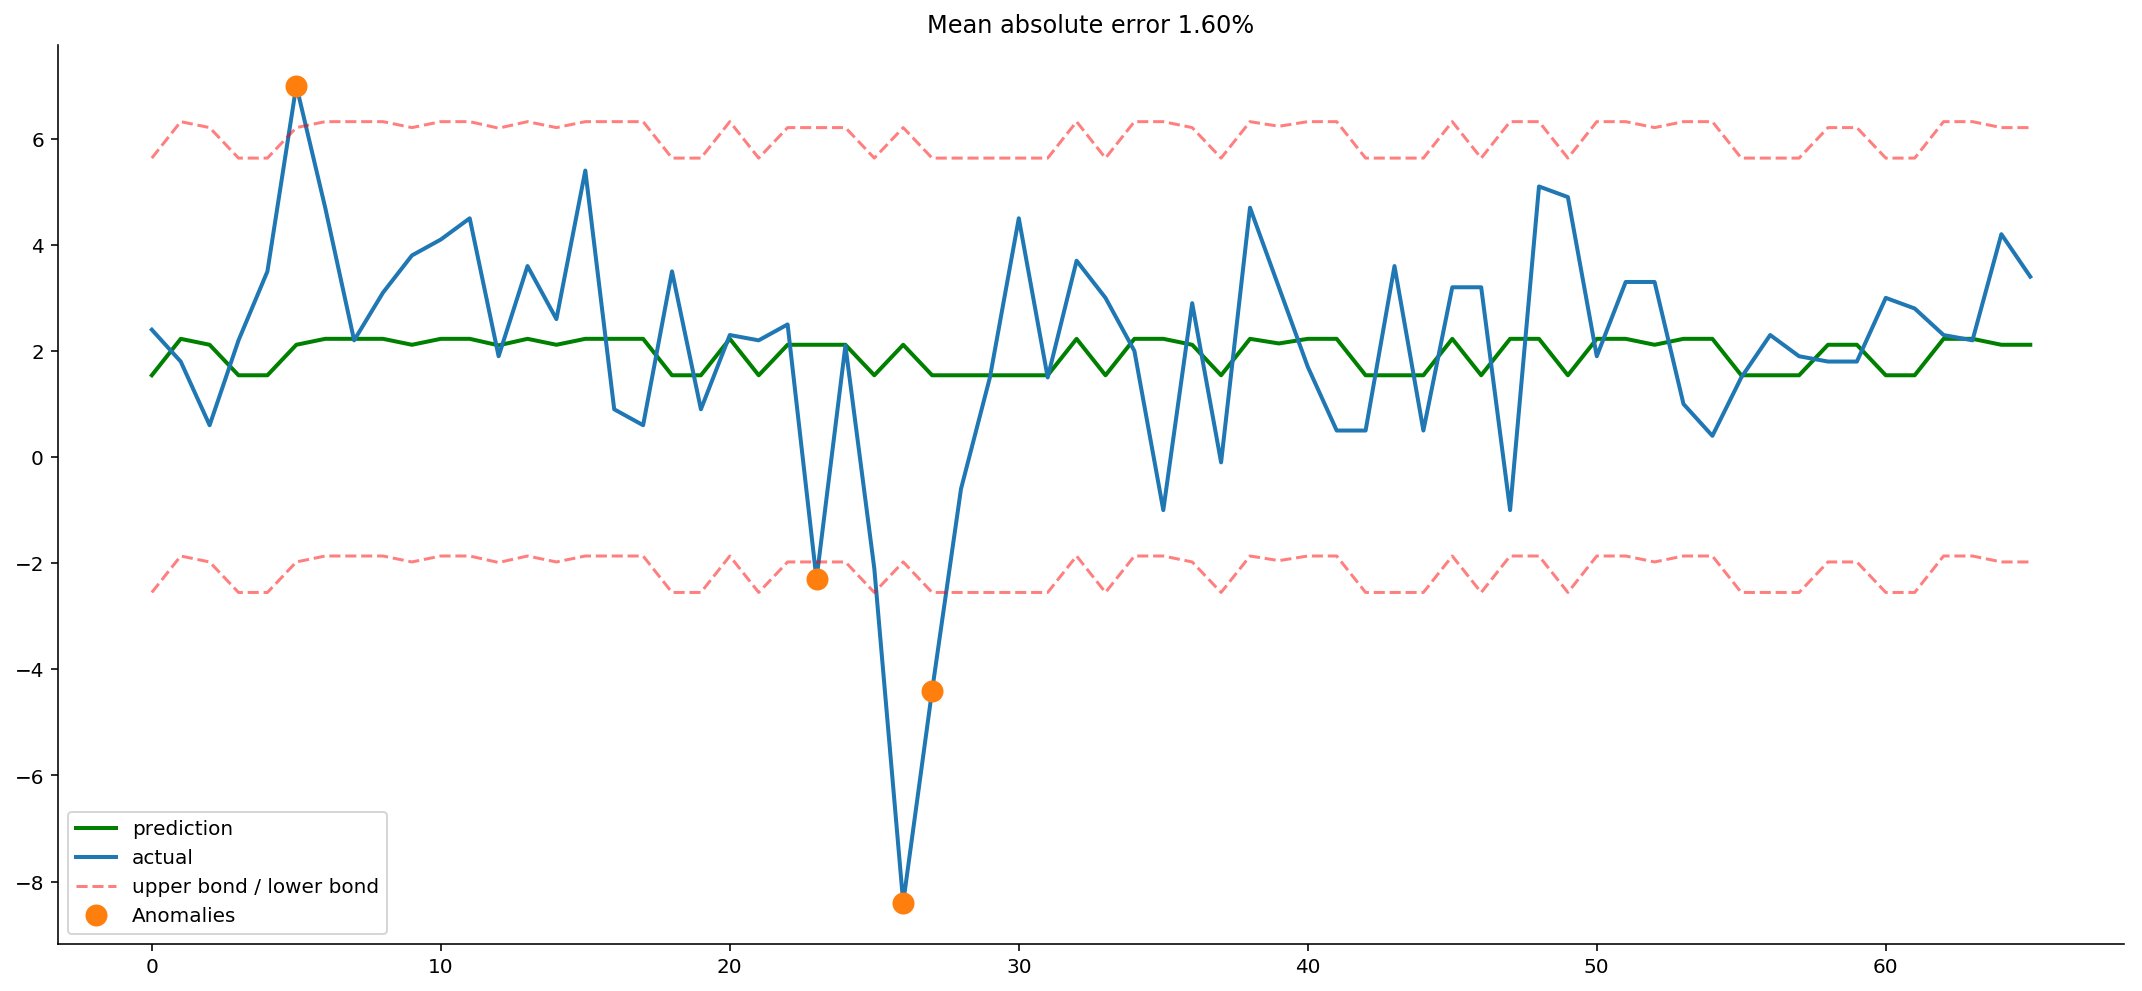

In [125]:
%timeit
ts.plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 y_train = y_train, y_test = y_test, tscv = tscv,
                 plot_intervals=True, plot_anomalies=True)

In [126]:
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

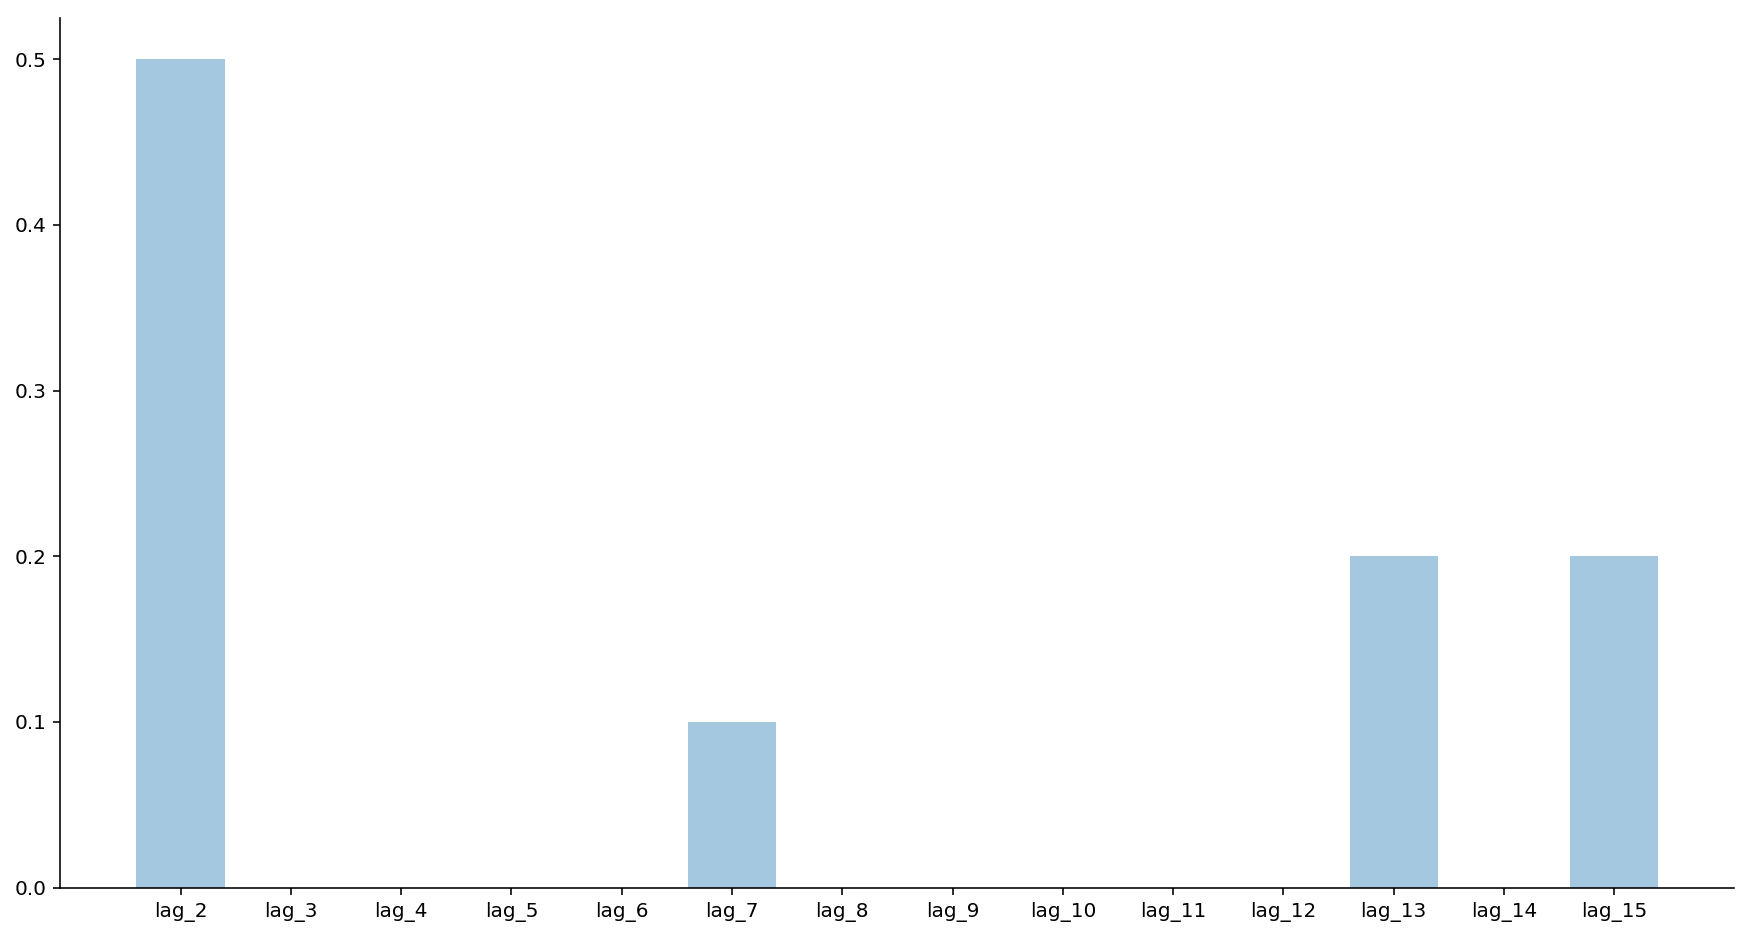

In [127]:
fig , ax = plt.subplots(figsize = [15,8])
ax.bar(x=X_train.columns,height = xgb.feature_importances_, alpha = 0.4)
sns.despine()

## Linear Regression Again after identifying important variabls

In [129]:
imp_features = X_train.columns[np.argsort(xgb.feature_importances_,)][-5:]
imp_features

Index(['lag_14', 'lag_7', 'lag_13', 'lag_15', 'lag_2'], dtype='object')

In [130]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)
X = X[imp_features]

In [131]:
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

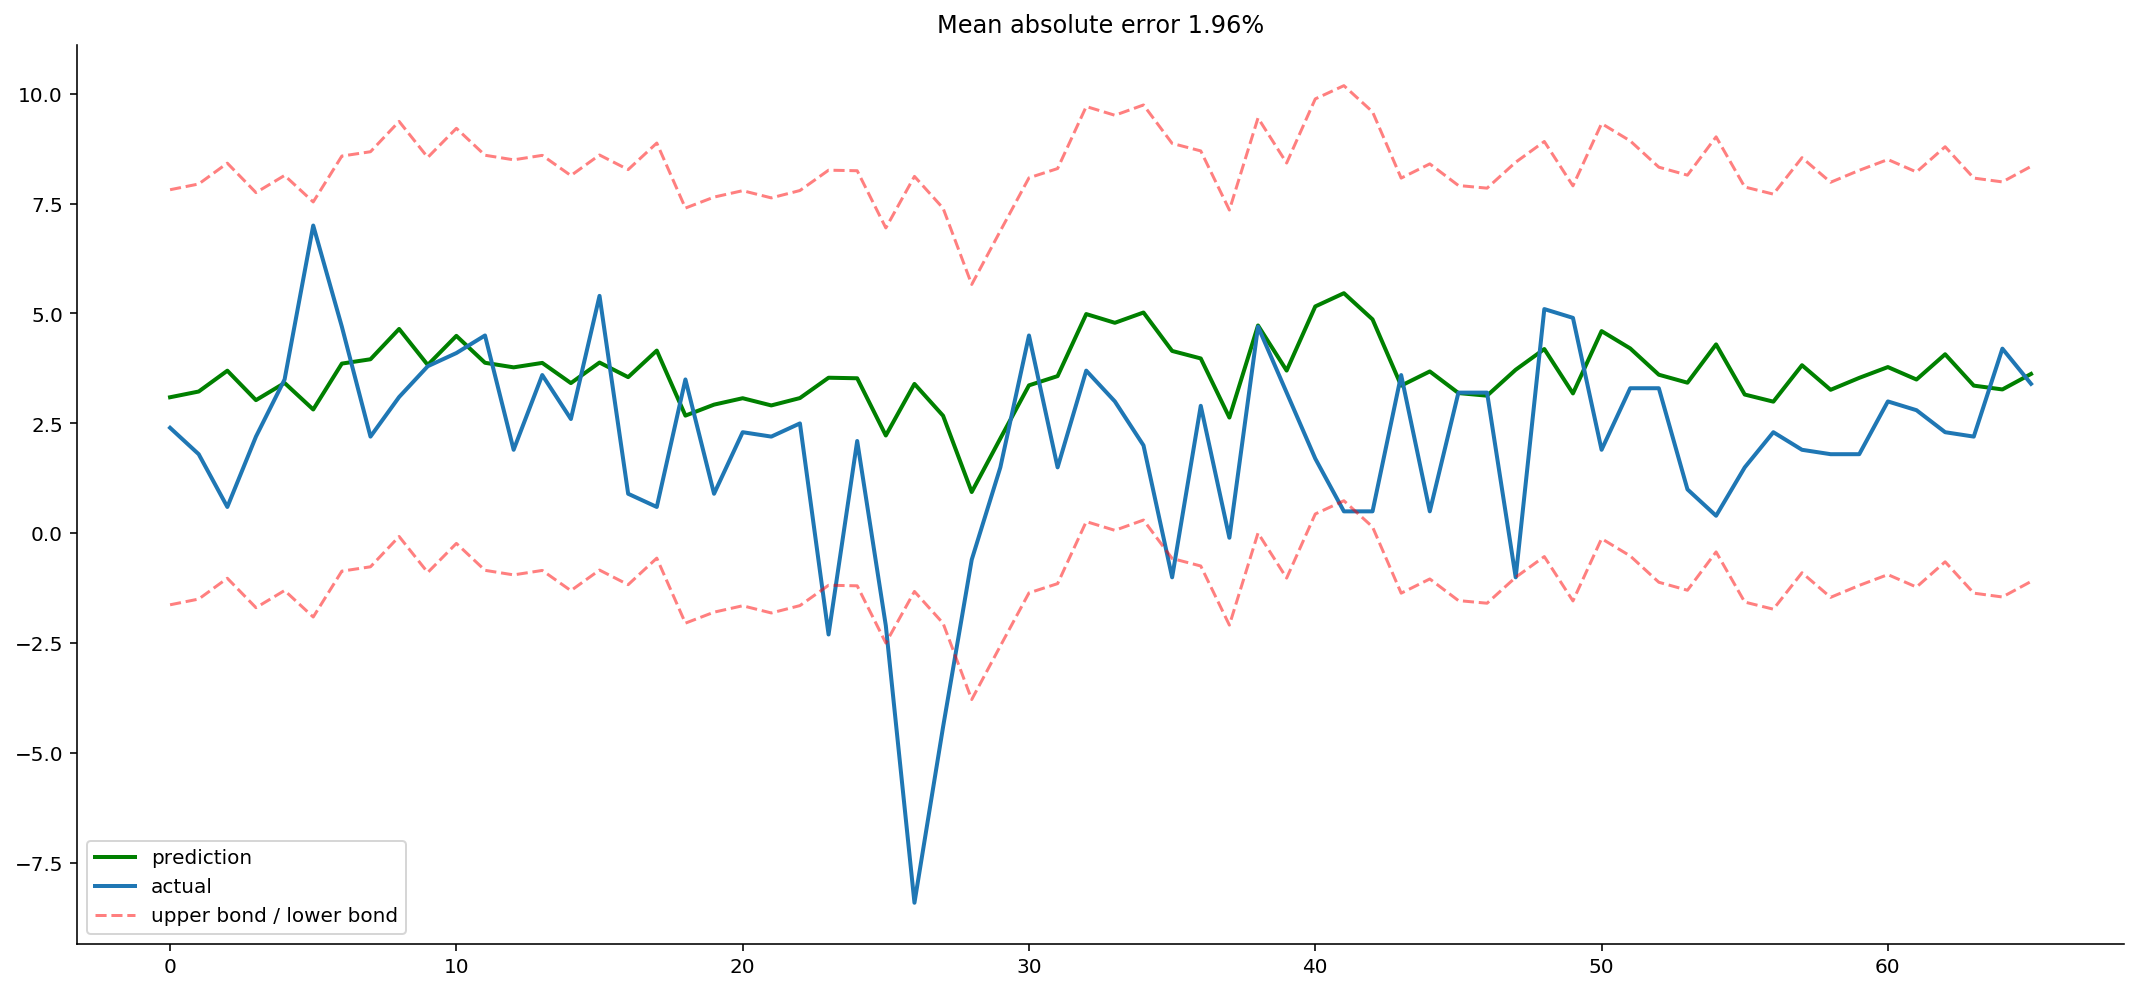

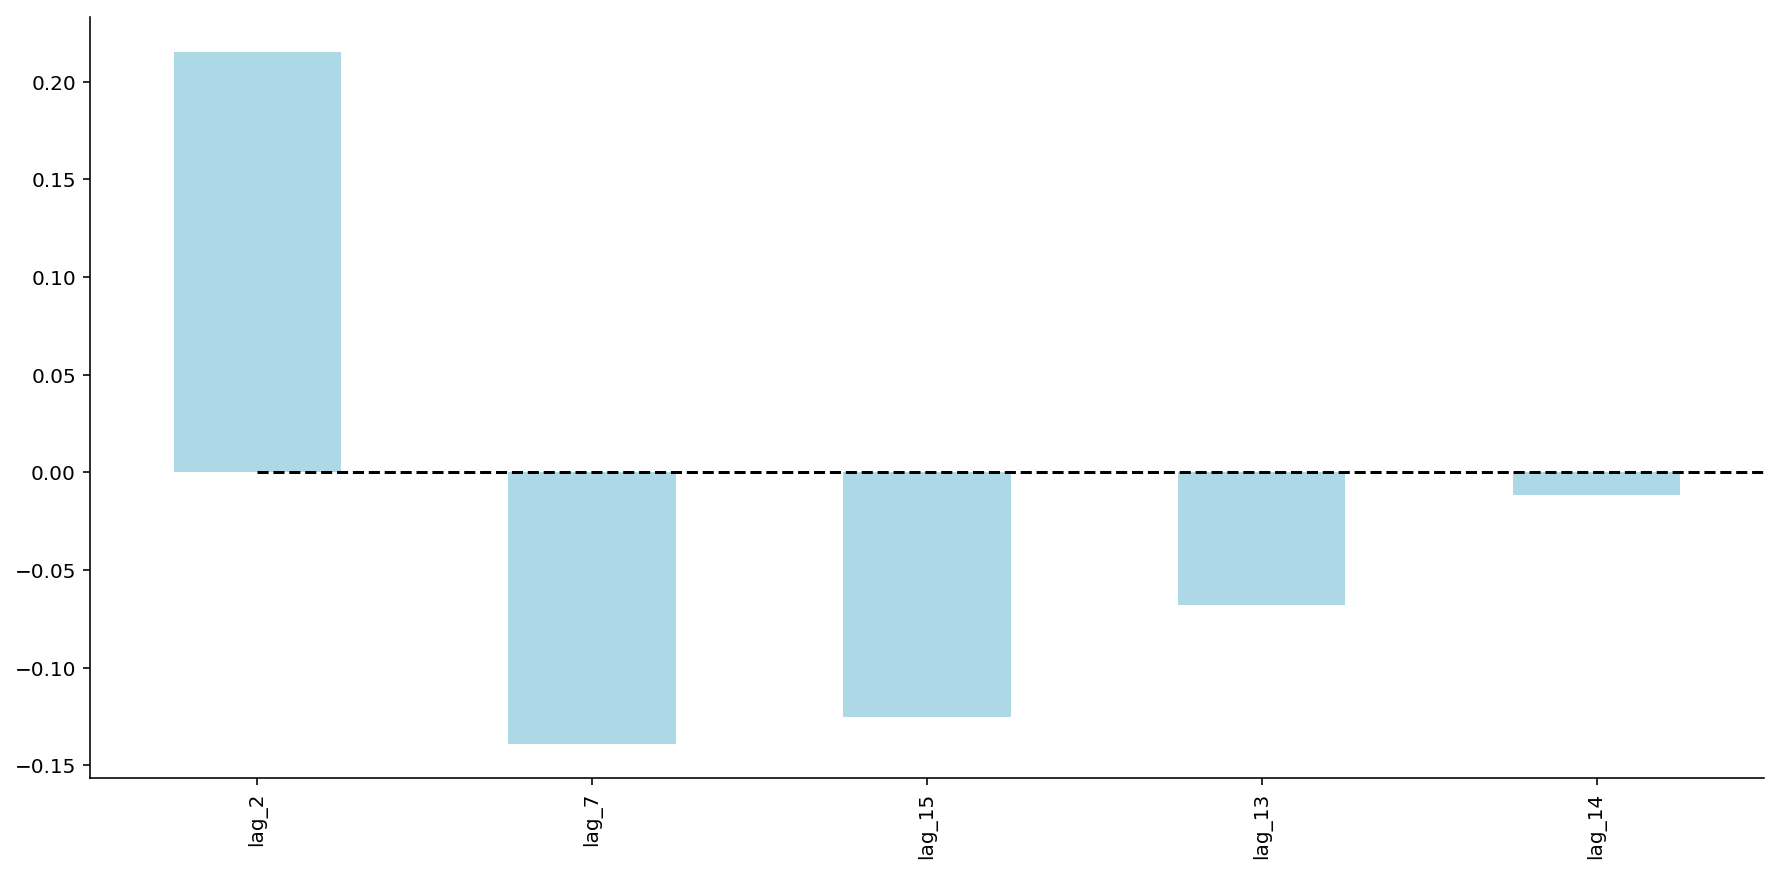

In [132]:
lr = LinearRegression()
lr.fit(X_train, y_train)
ts.plotModelResults(lr,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(lr,X_train)


# This section will investigate the rate of change of annualised gdp growth rate

# Using Machine Learning Techniques on RoC

In [367]:
gdp_roc = df.diff().dropna()

In [368]:
gdp_roc.columns = ["y"]
for i in range(2, 16):
    gdp_roc["lag_{}".format(i)] = gdp_roc.y.shift(i)
dt = gdp_roc.dropna()

In [369]:
dt = dt[-100:]

In [370]:
y = dt.y

In [371]:
X = dt.drop(['y'], axis = 1)

In [372]:
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

In [373]:
xgb =  XGBRegressor(max_depth=3,n_estimators = 3, learning_rate=0.1)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

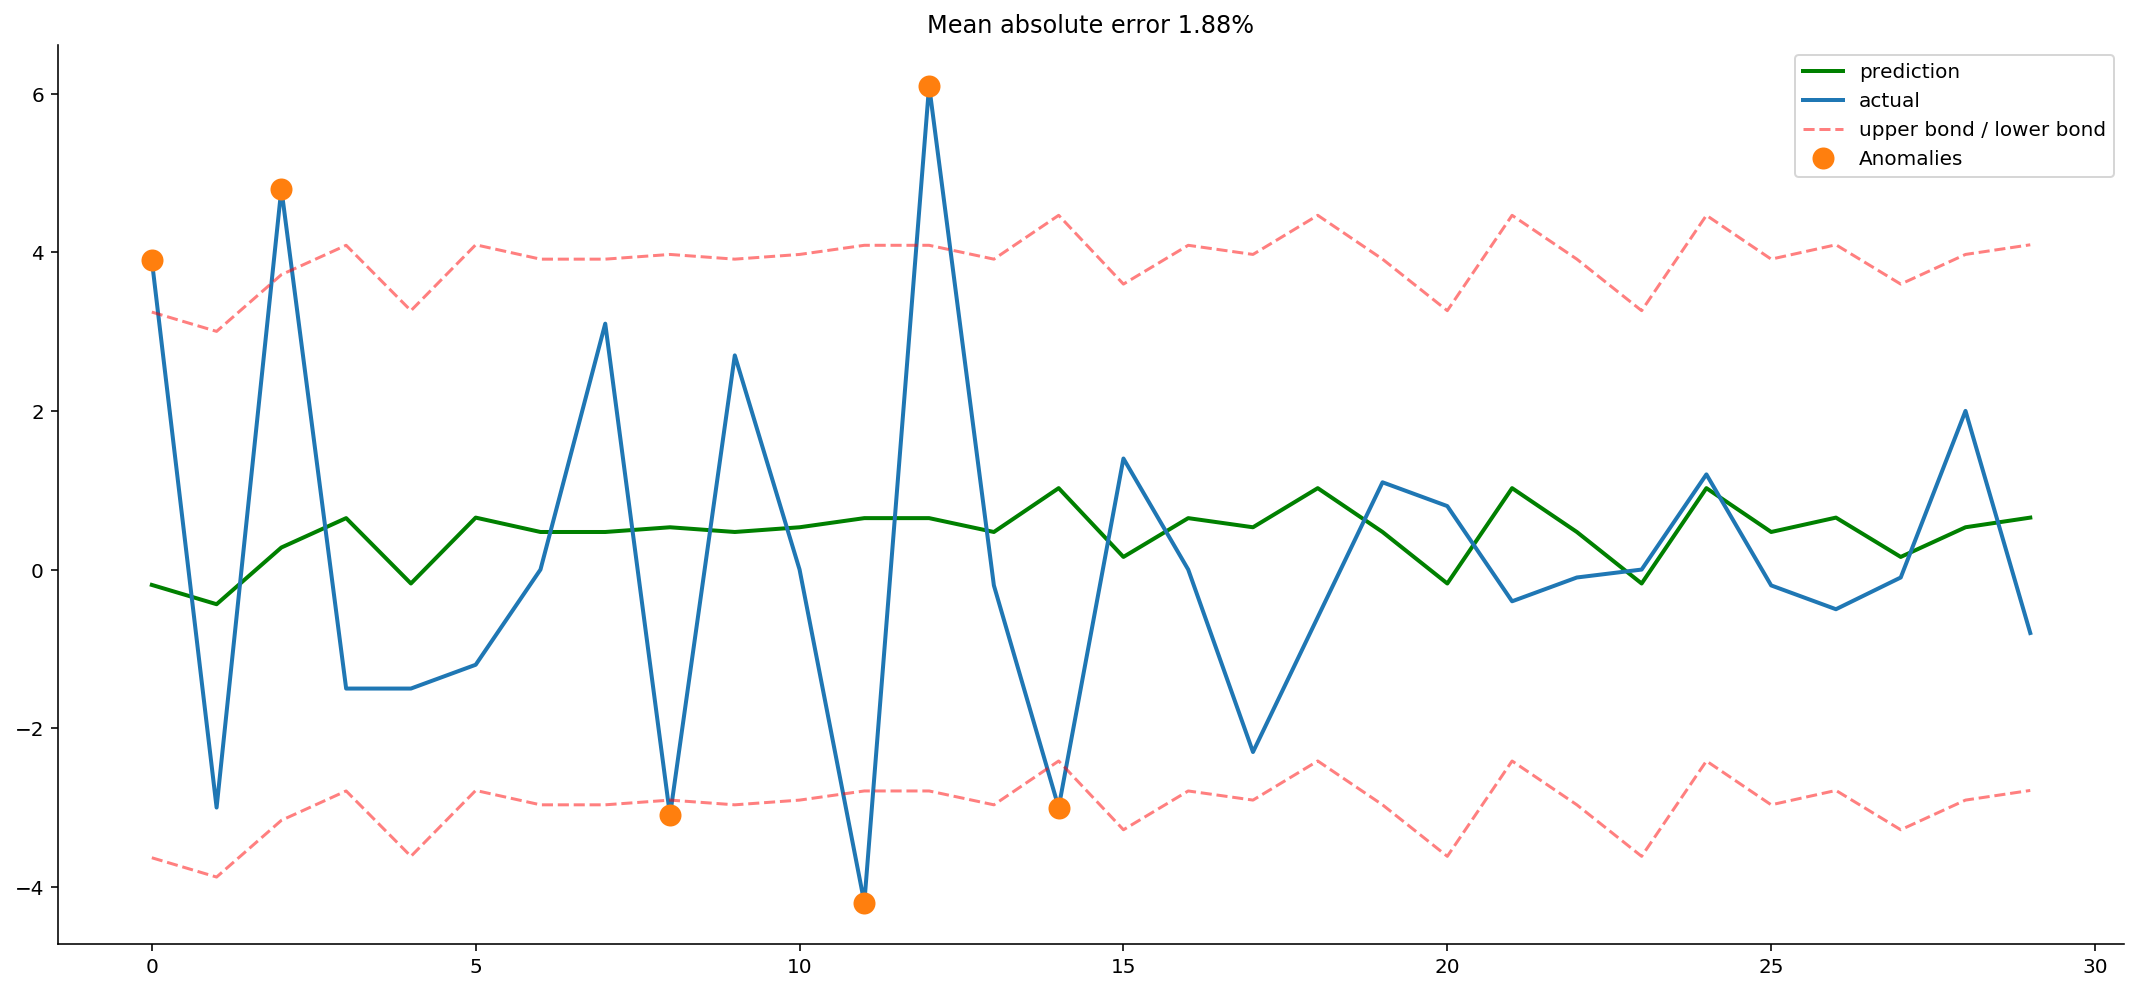

In [374]:
%timeit
ts.plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 y_train = y_train, y_test = y_test, tscv = tscv,
                 plot_intervals=True, plot_anomalies=True)

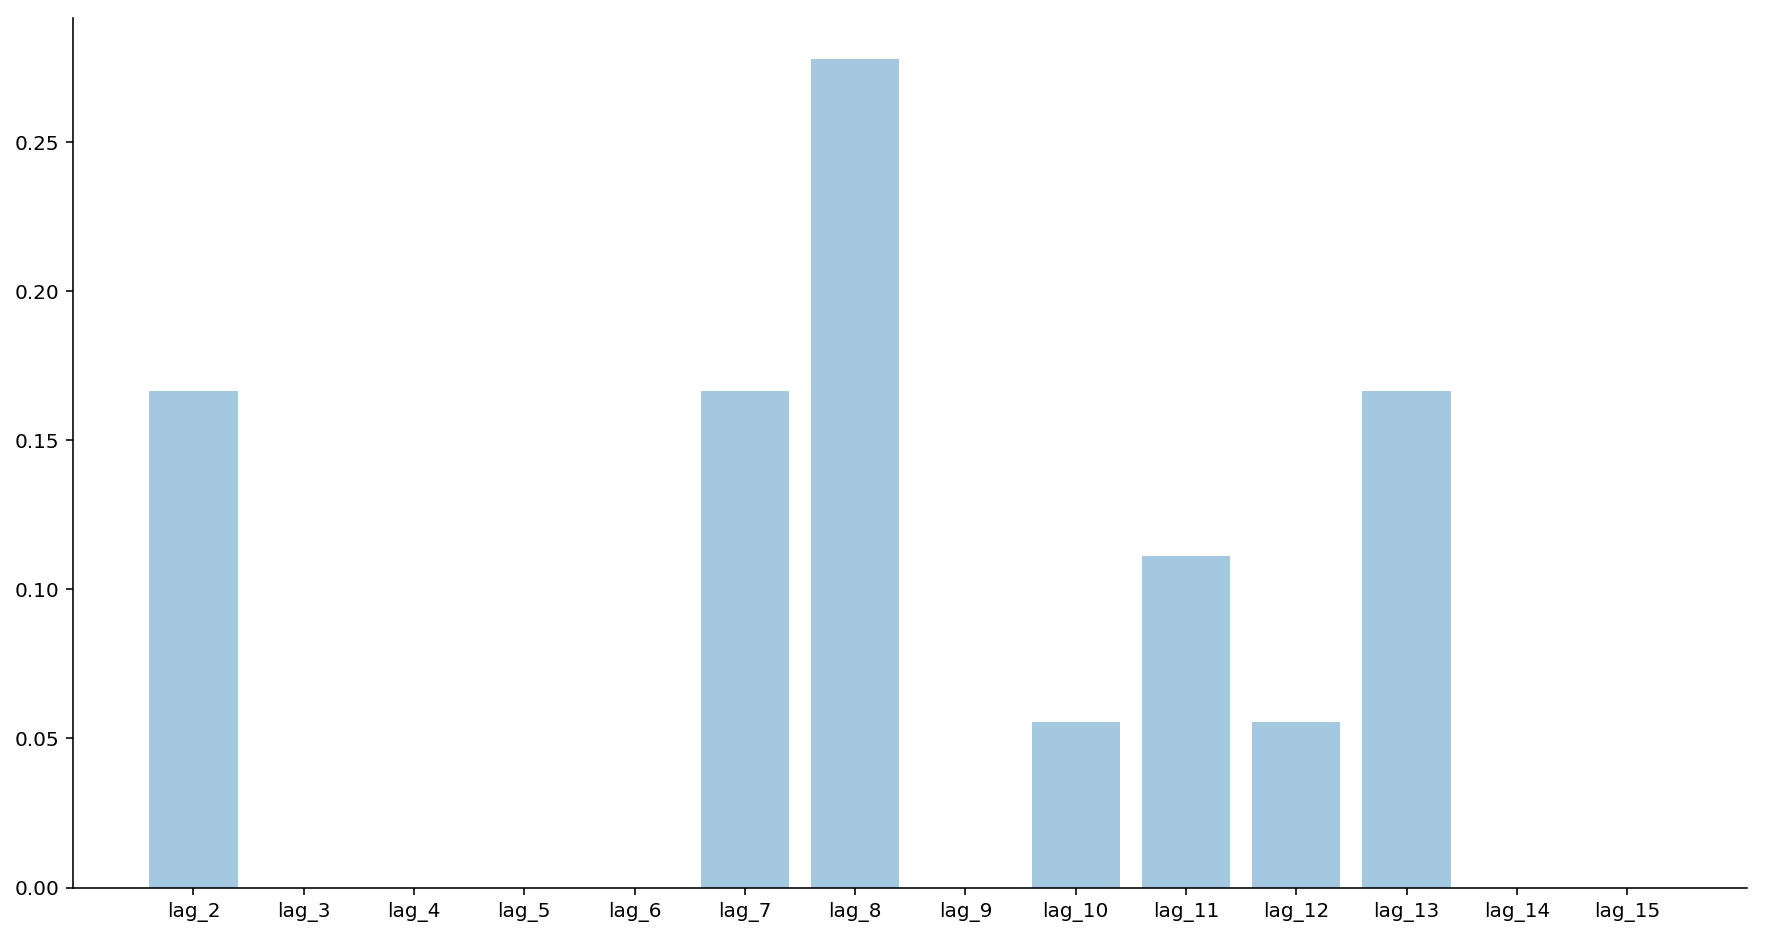

In [375]:
fig , ax = plt.subplots(figsize = [15,8])
ax.bar(x=X_train.columns,height = xgb.feature_importances_, alpha = 0.4)
sns.despine()

## Linear Regression

In [311]:
imp_features = X_train.columns[np.argsort(xgb.feature_importances_,)][-5:]
X_train = X_train[imp_features]

In [312]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

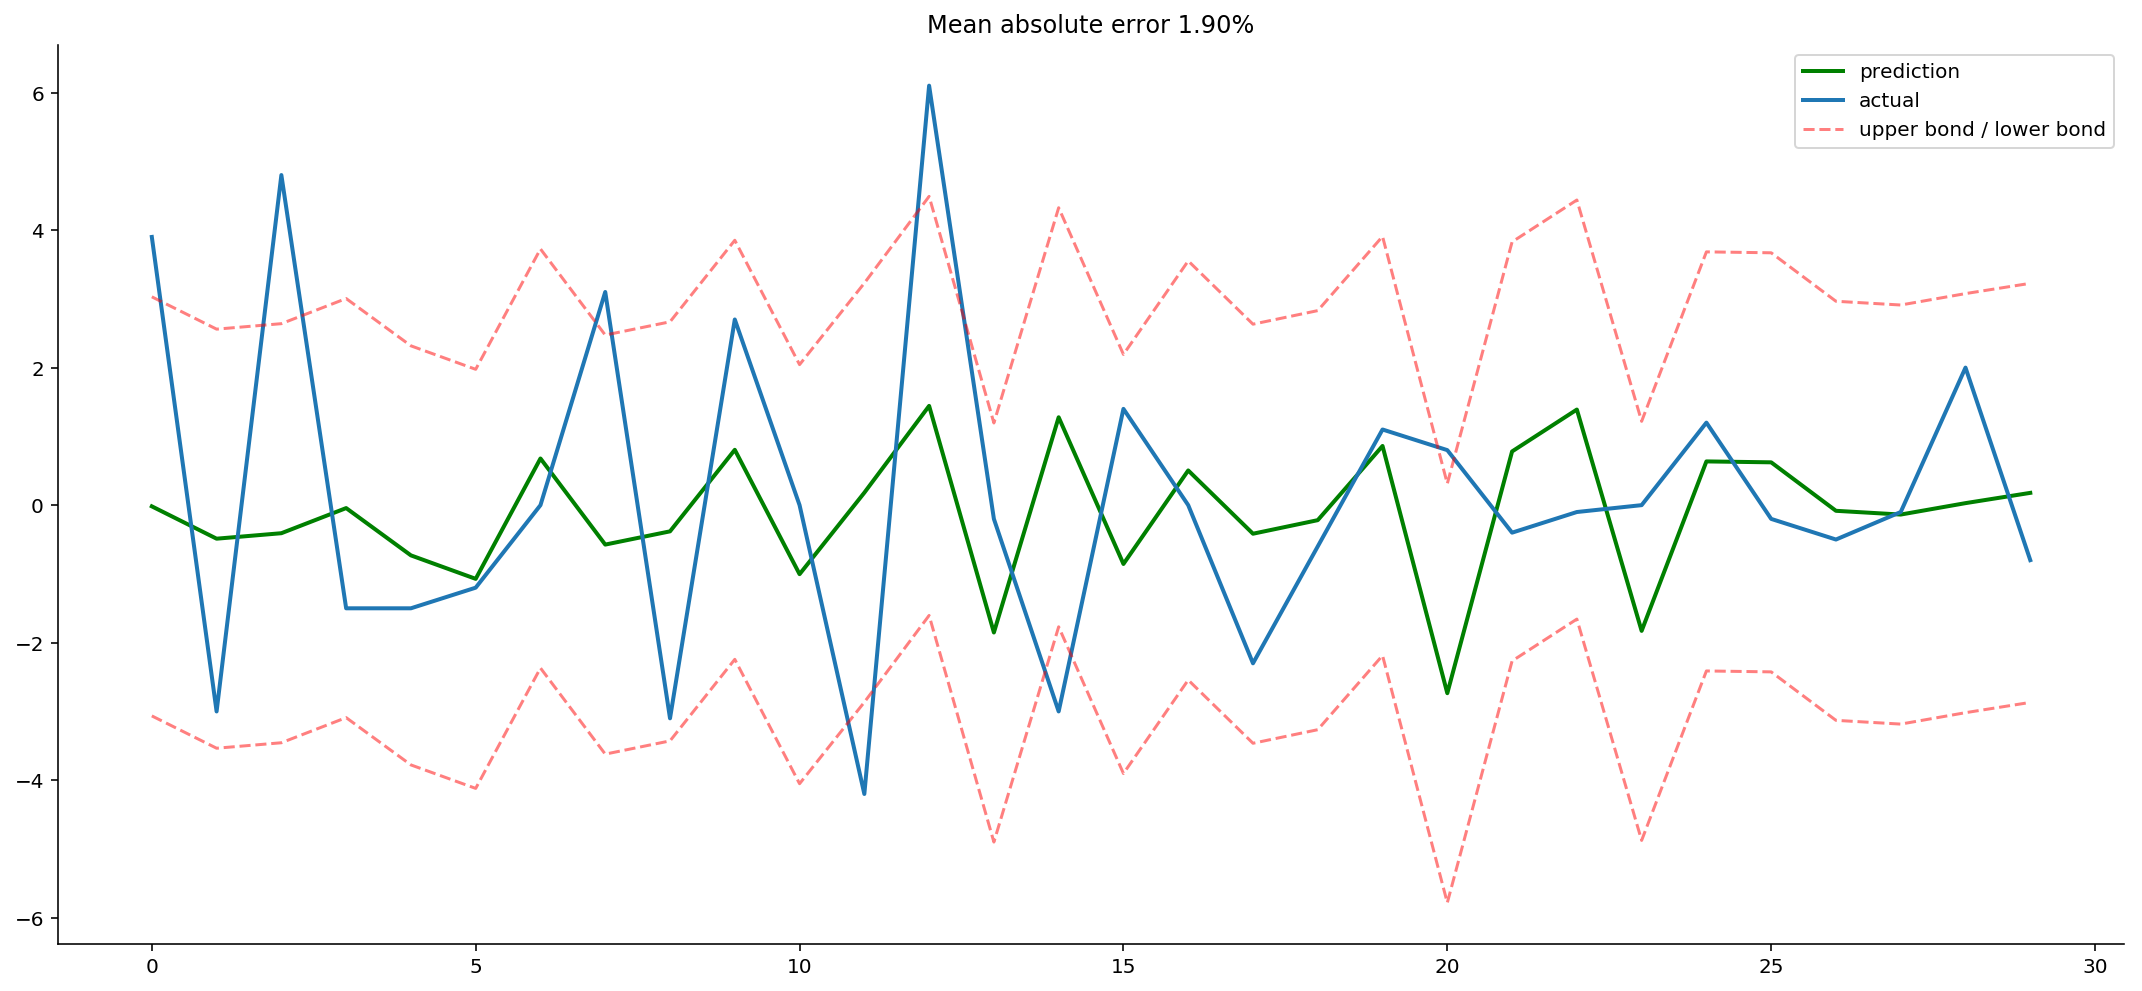

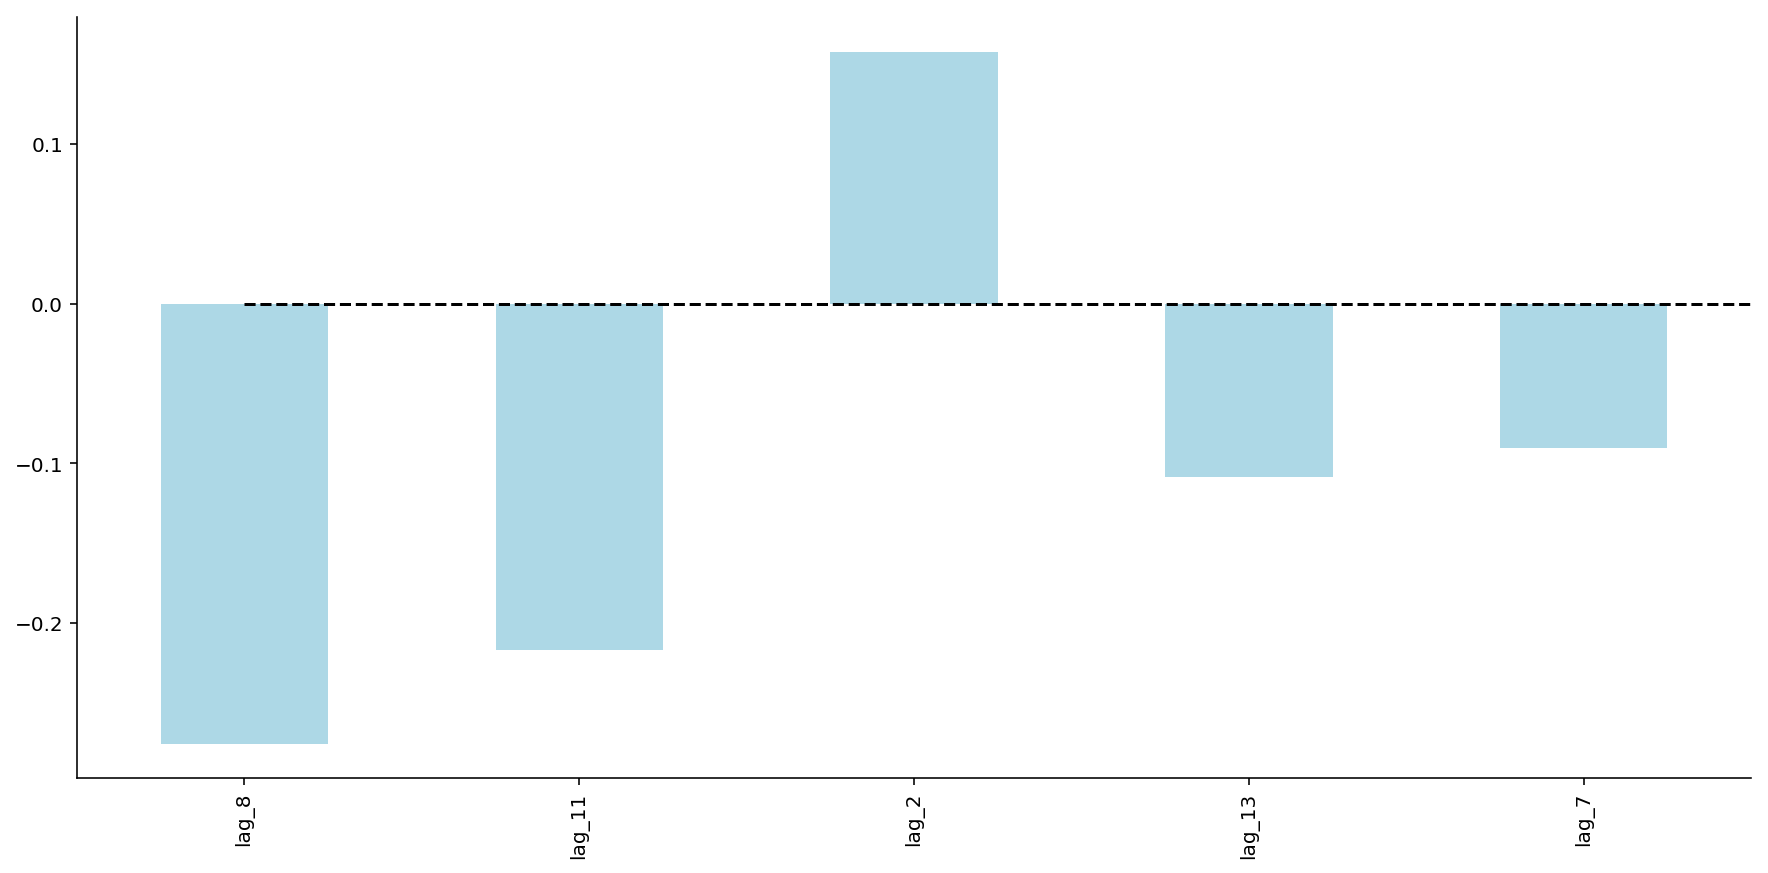

In [313]:
ts.plotModelResults(lr,X_train,X_test[imp_features],y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(lr,X_train)

## Linear Regression with lags at 4,8,12 only

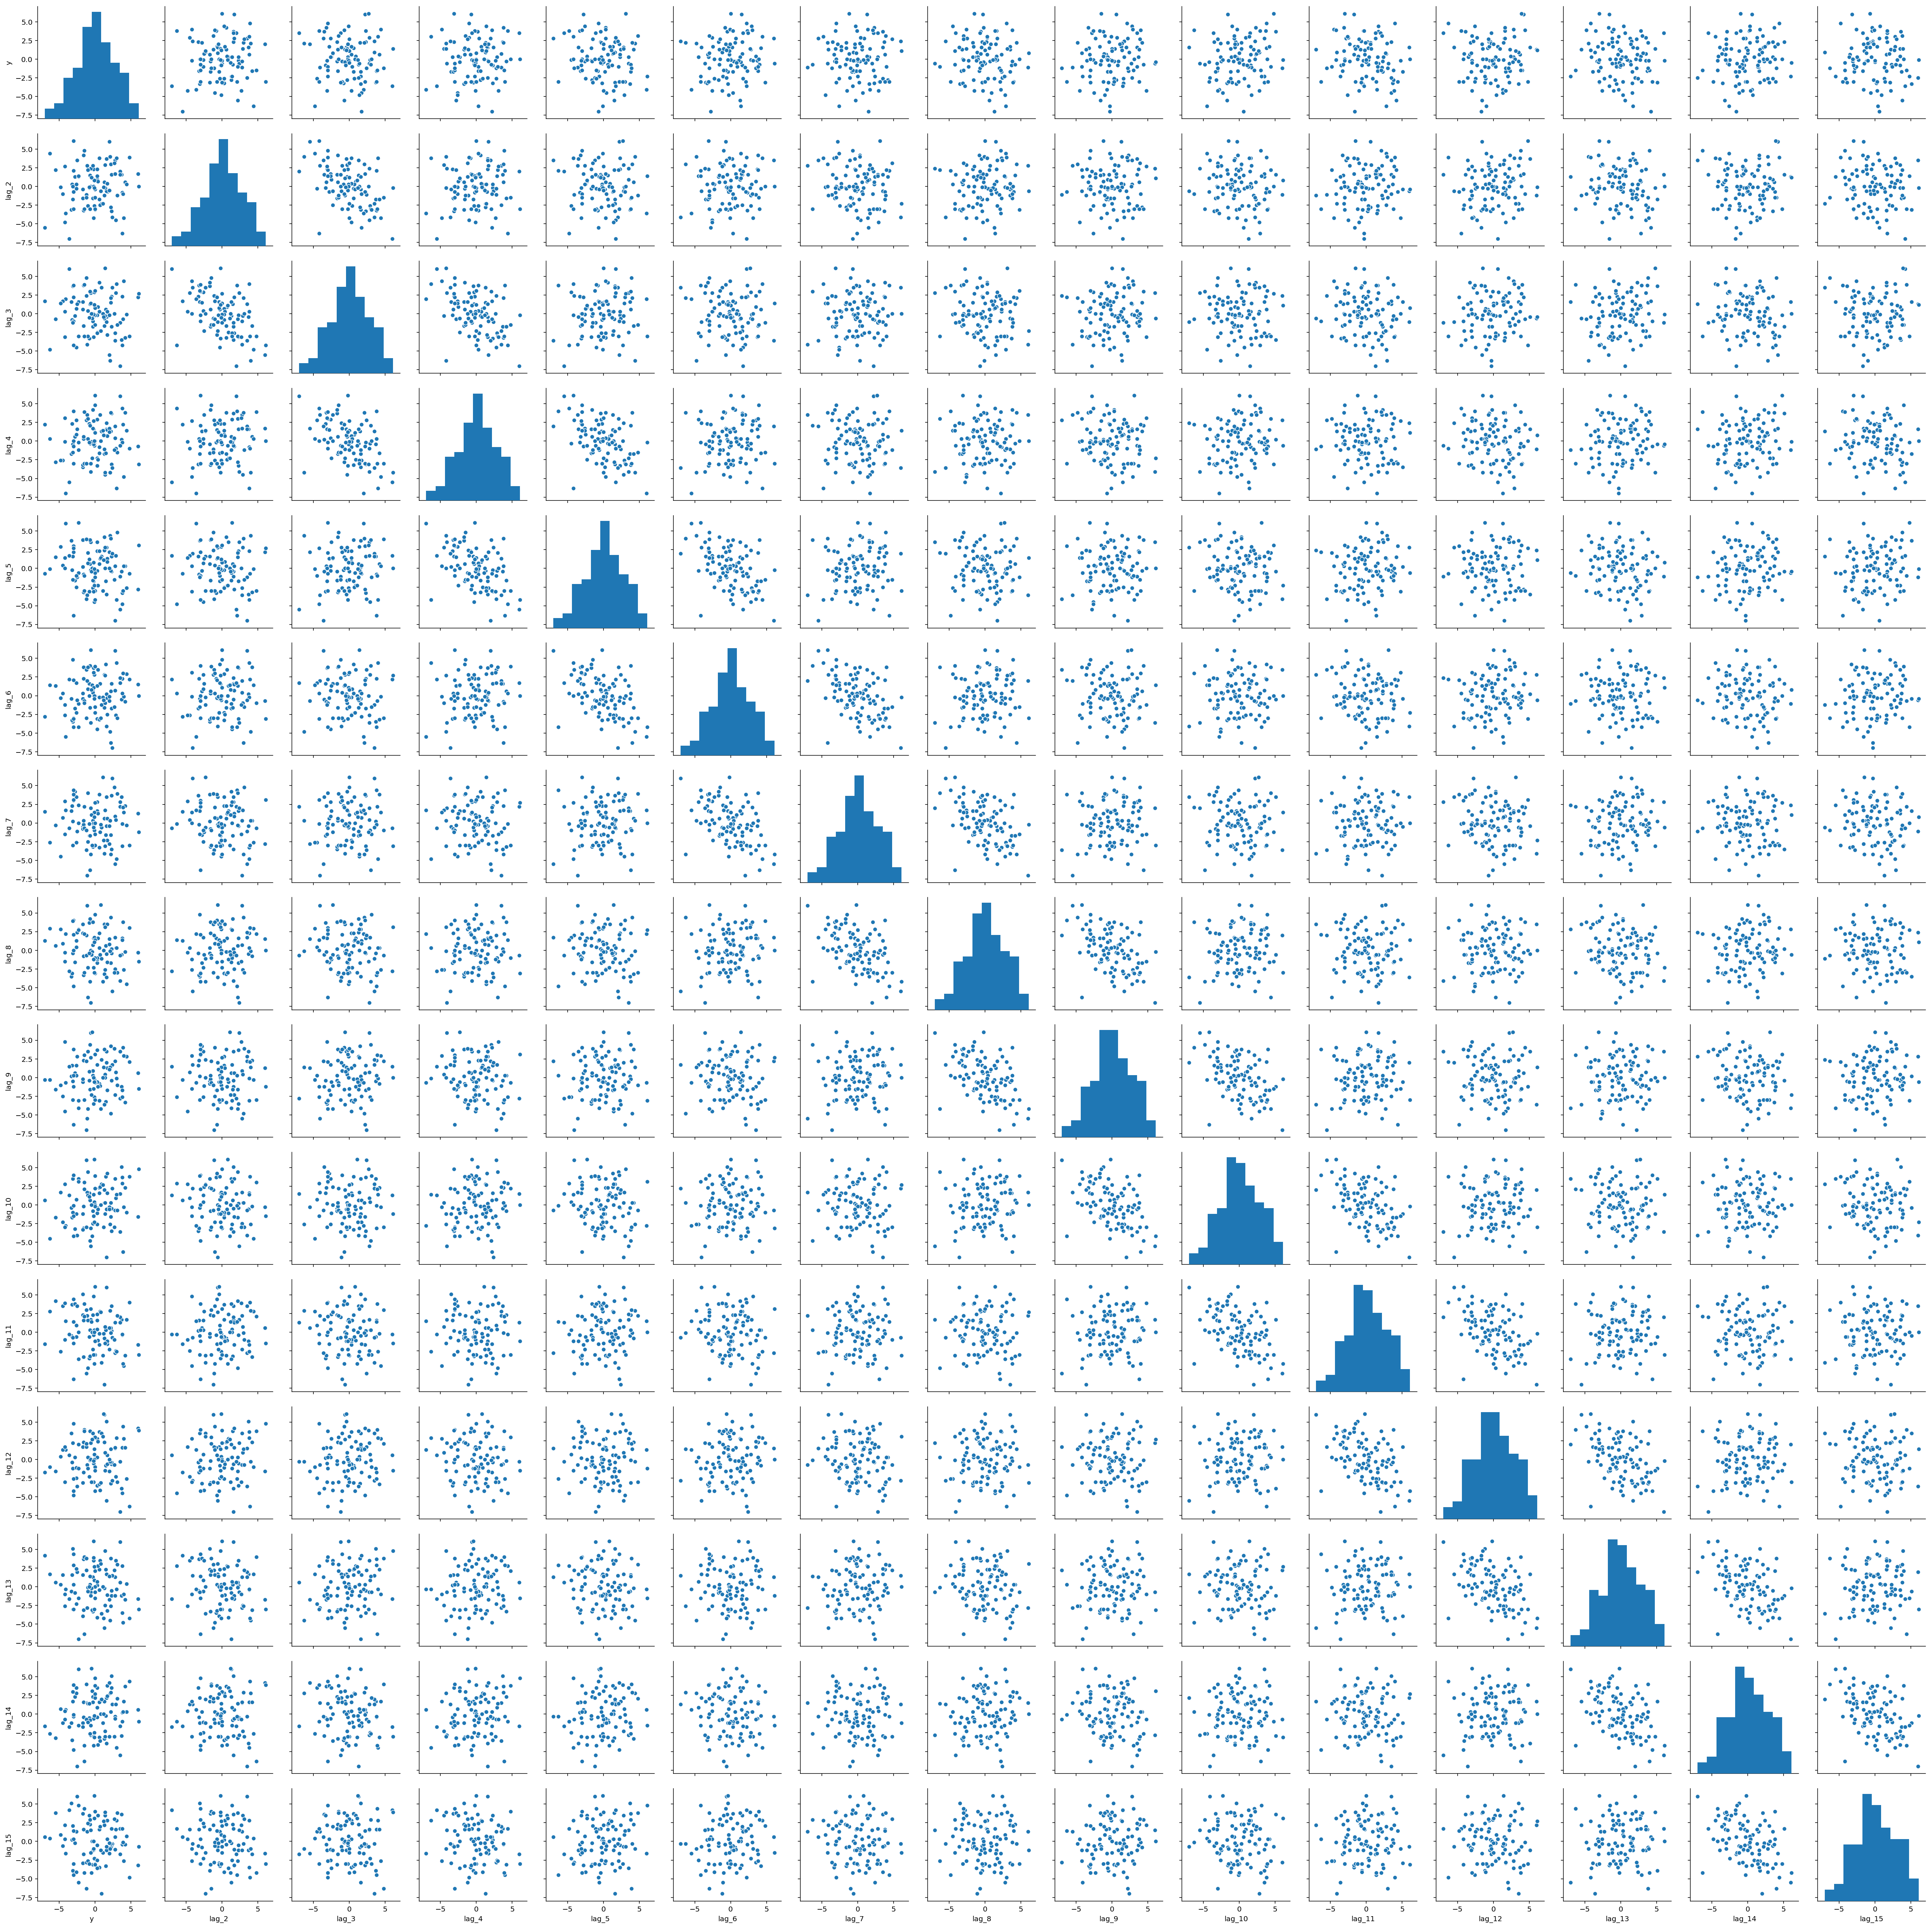

In [278]:
sns.pairplot(gdp_roc.dropna()[-100:])

In [314]:
dt = gdp_roc.dropna()[['y','lag_4','lag_8','lag_12']][-100:]

In [315]:
y = dt.y
X = dt.drop(['y'], axis = 1)

In [316]:
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

In [317]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

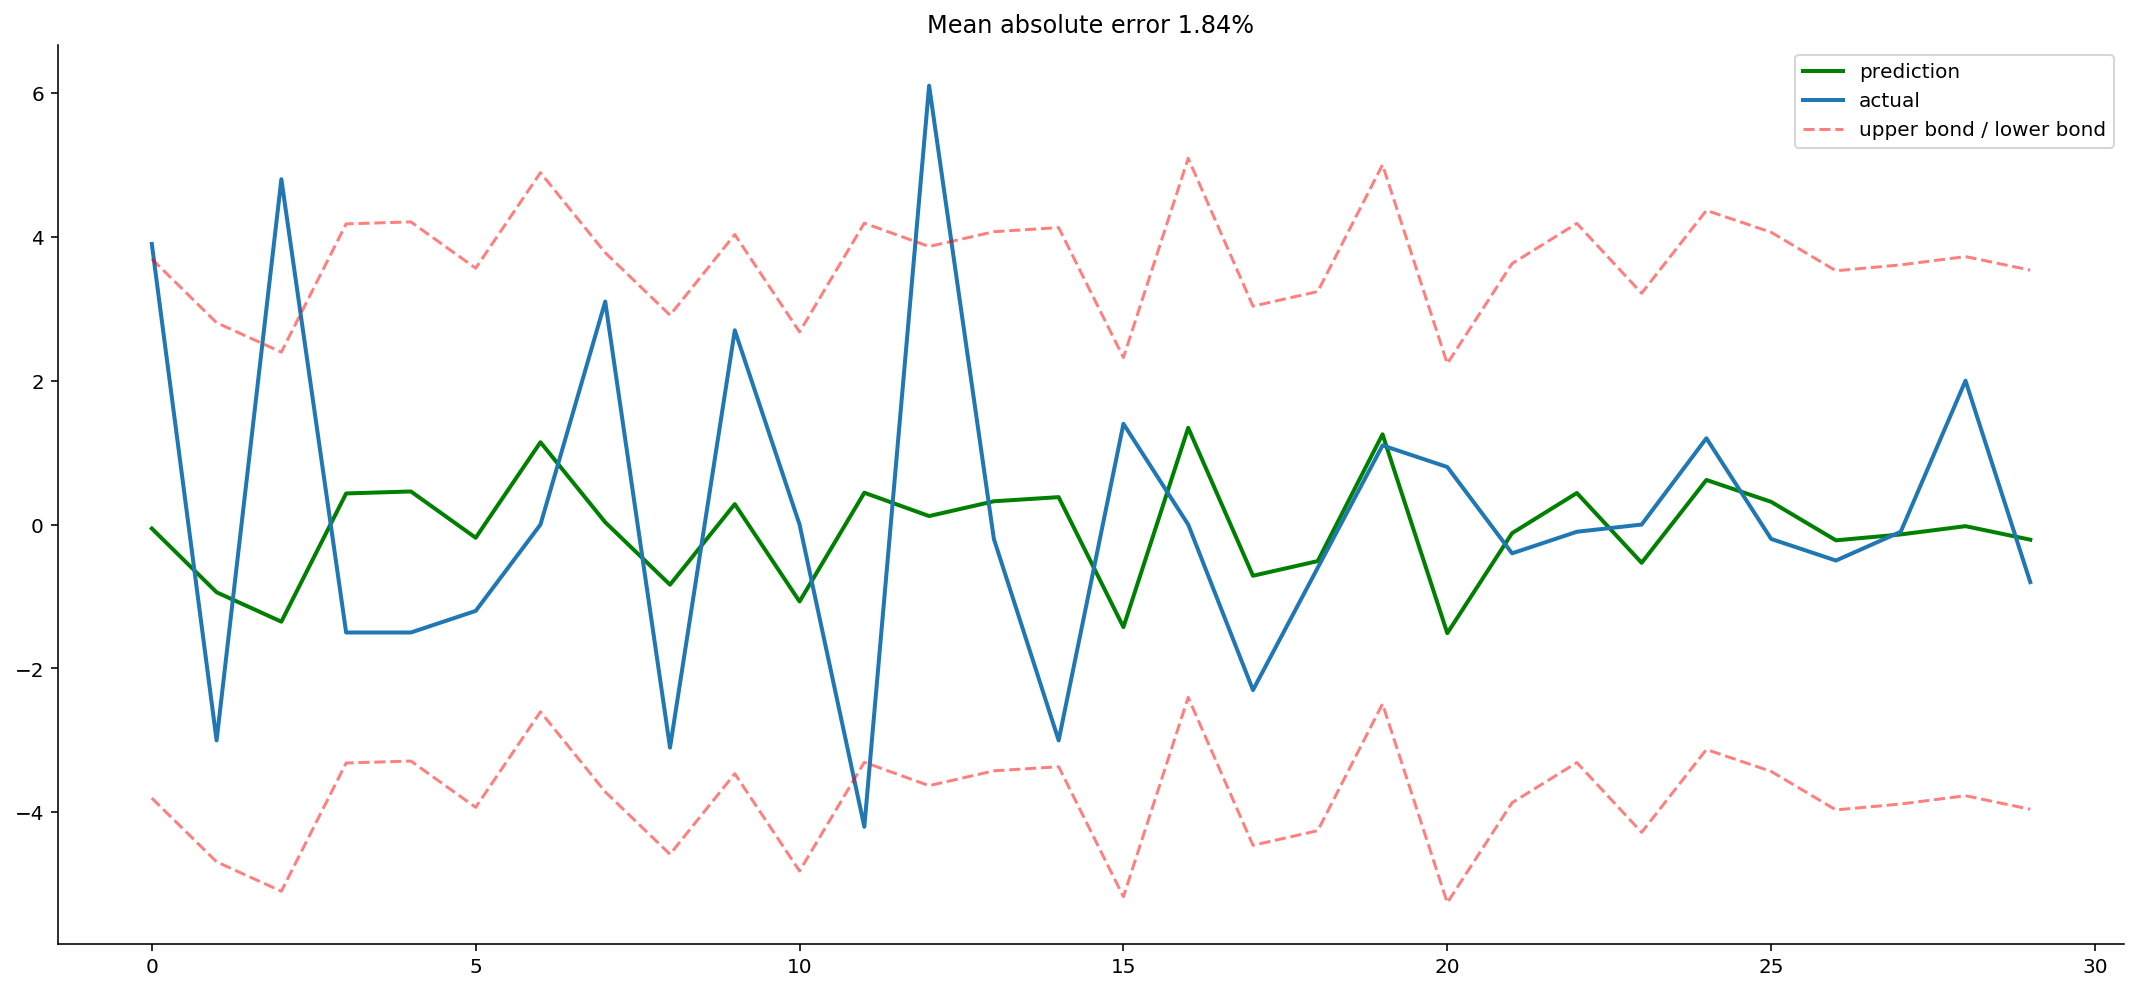

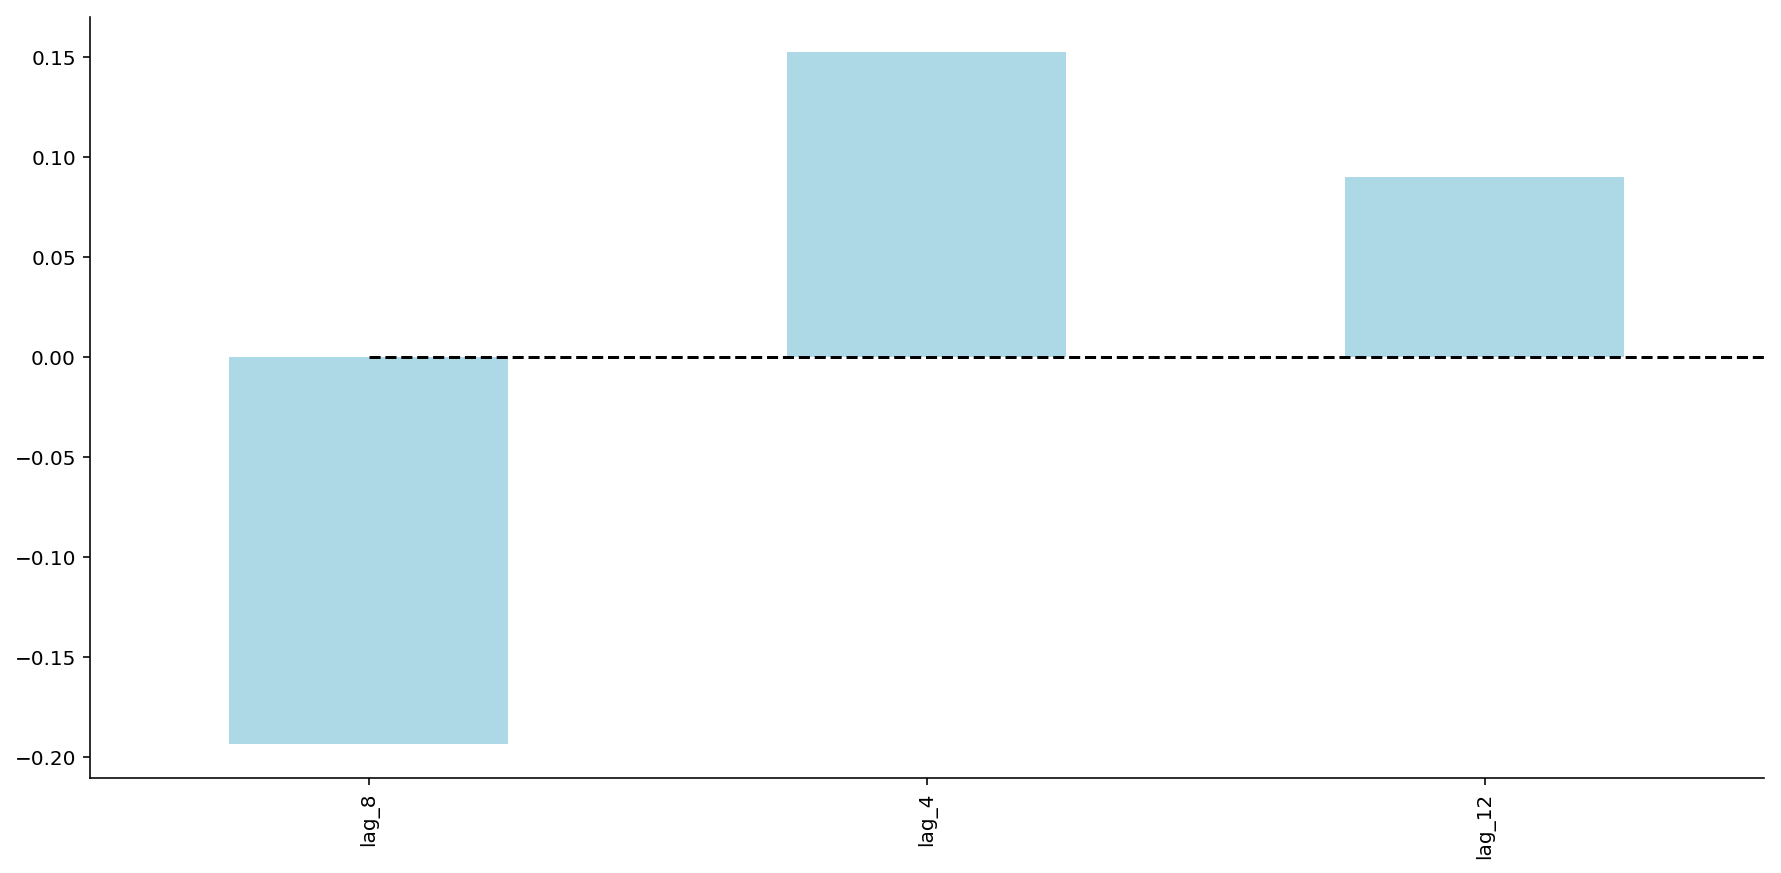

In [318]:
ts.plotModelResults(lr,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(lr,X_train)

## Bayesian Ridge

In [319]:
from sklearn.linear_model import BayesianRidge

In [320]:
dt = gdp_roc.dropna()[-100:]
y = dt.y
X = dt.drop(['y'], axis = 1)
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

In [321]:
clf = BayesianRidge(normalize=True)

In [322]:
clf.fit(X_train,y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

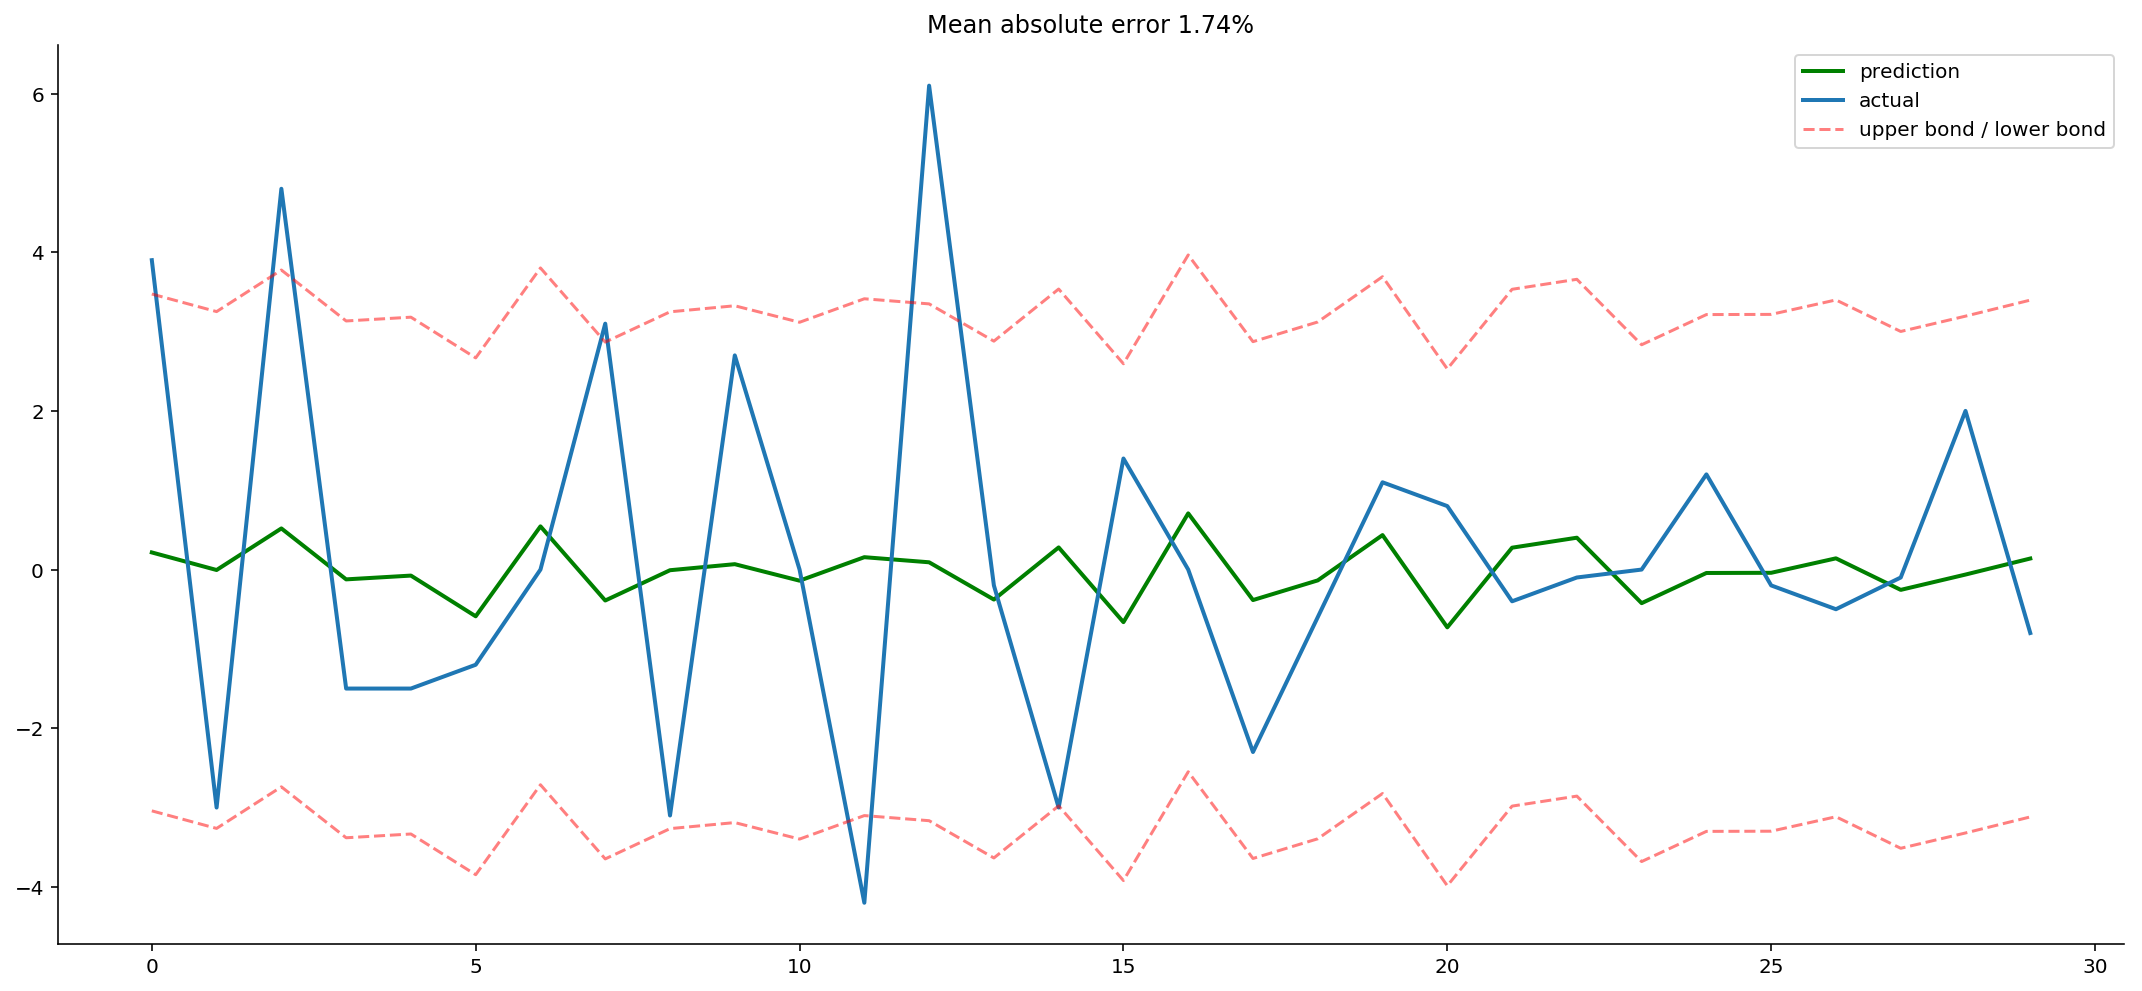

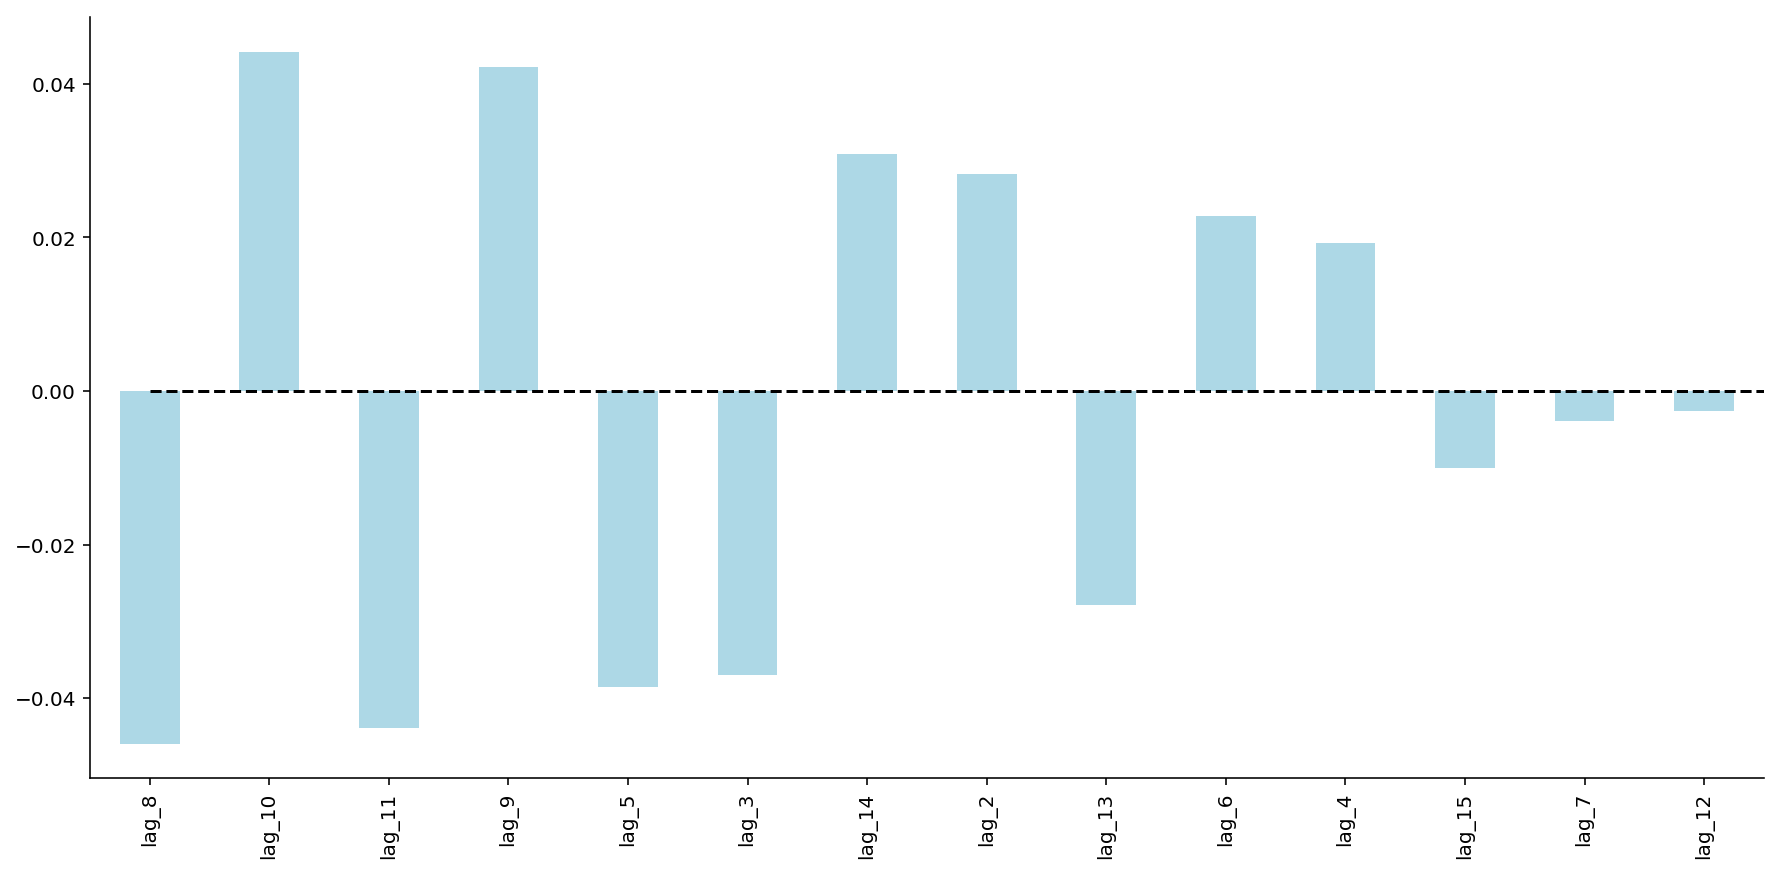

In [323]:
ts.plotModelResults(clf,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(clf,X_train)

## Lasso

In [324]:
dt = gdp_roc.dropna()[-100:]
y = dt.y
X = dt.drop(['y'], axis = 1)
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

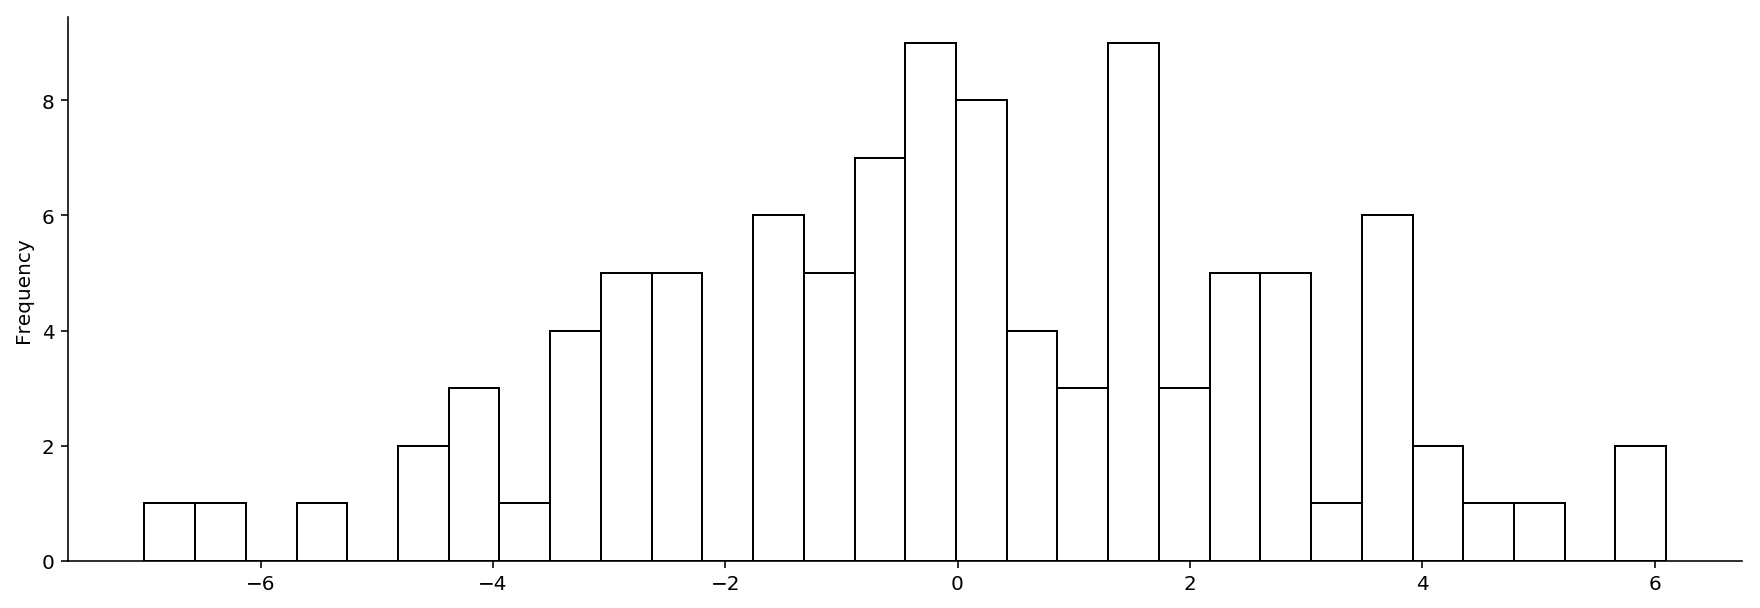

In [390]:
y.plot.hist(figsize=[15,5], fill = False, bins = 30)
sns.despine()

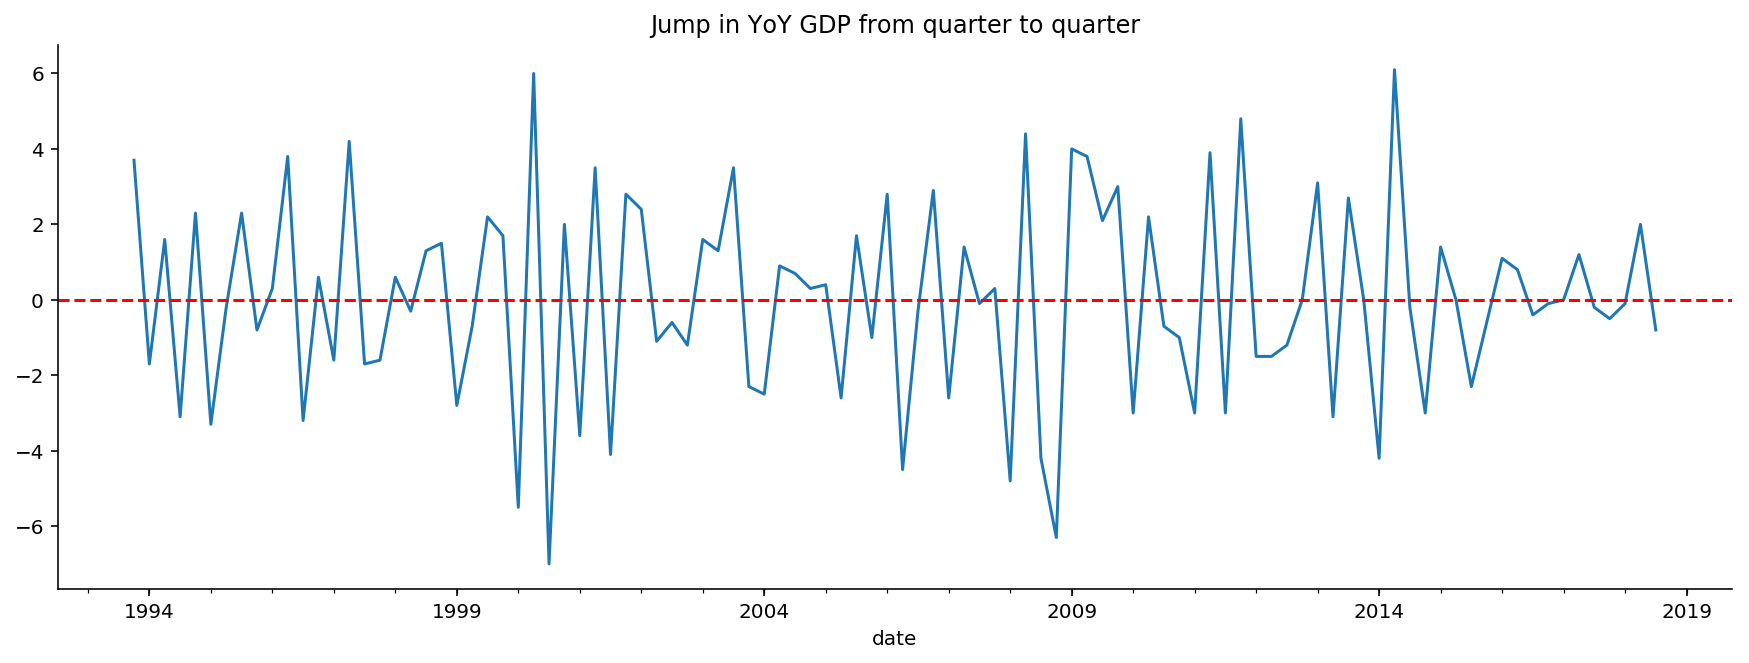

In [389]:
y.plot(figsize=[15,5],title = 'Jump in YoY GDP from quarter to quarter')
plt.axhline(y=0,linestyle='--',color='red')
sns.despine()

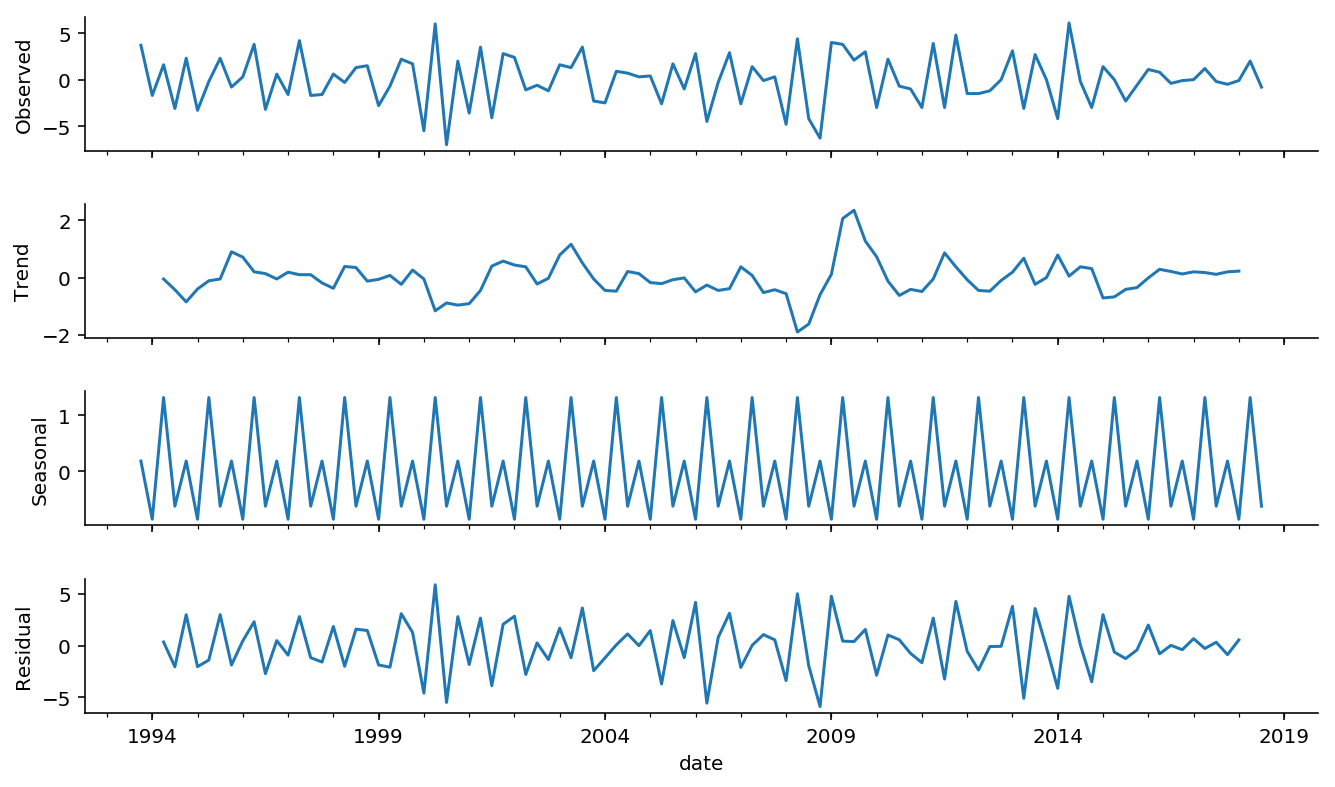

In [325]:
results = seasonal_decompose(dt['y'])
fig = results.plot()
fig.set_size_inches(10,6)
sns.despine()

In [326]:
reg = Lasso()
reg.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

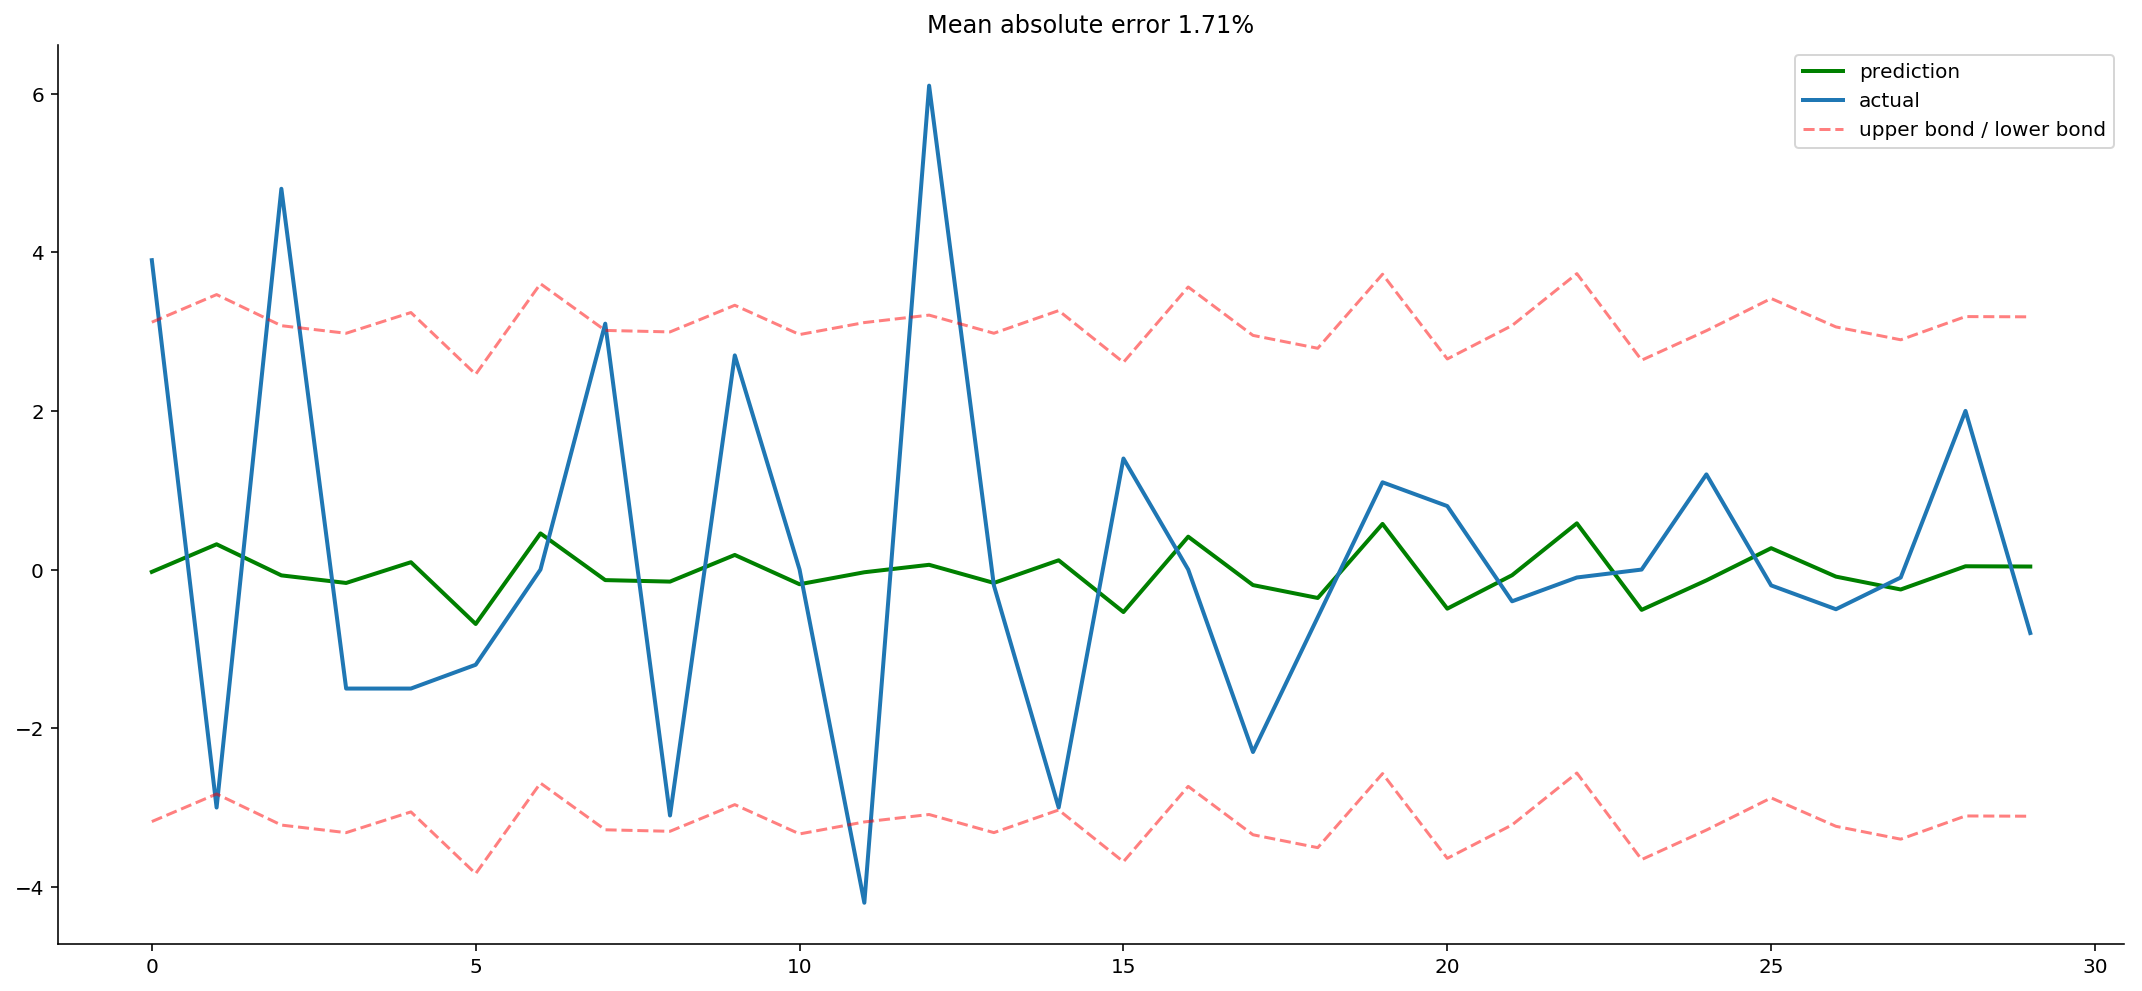

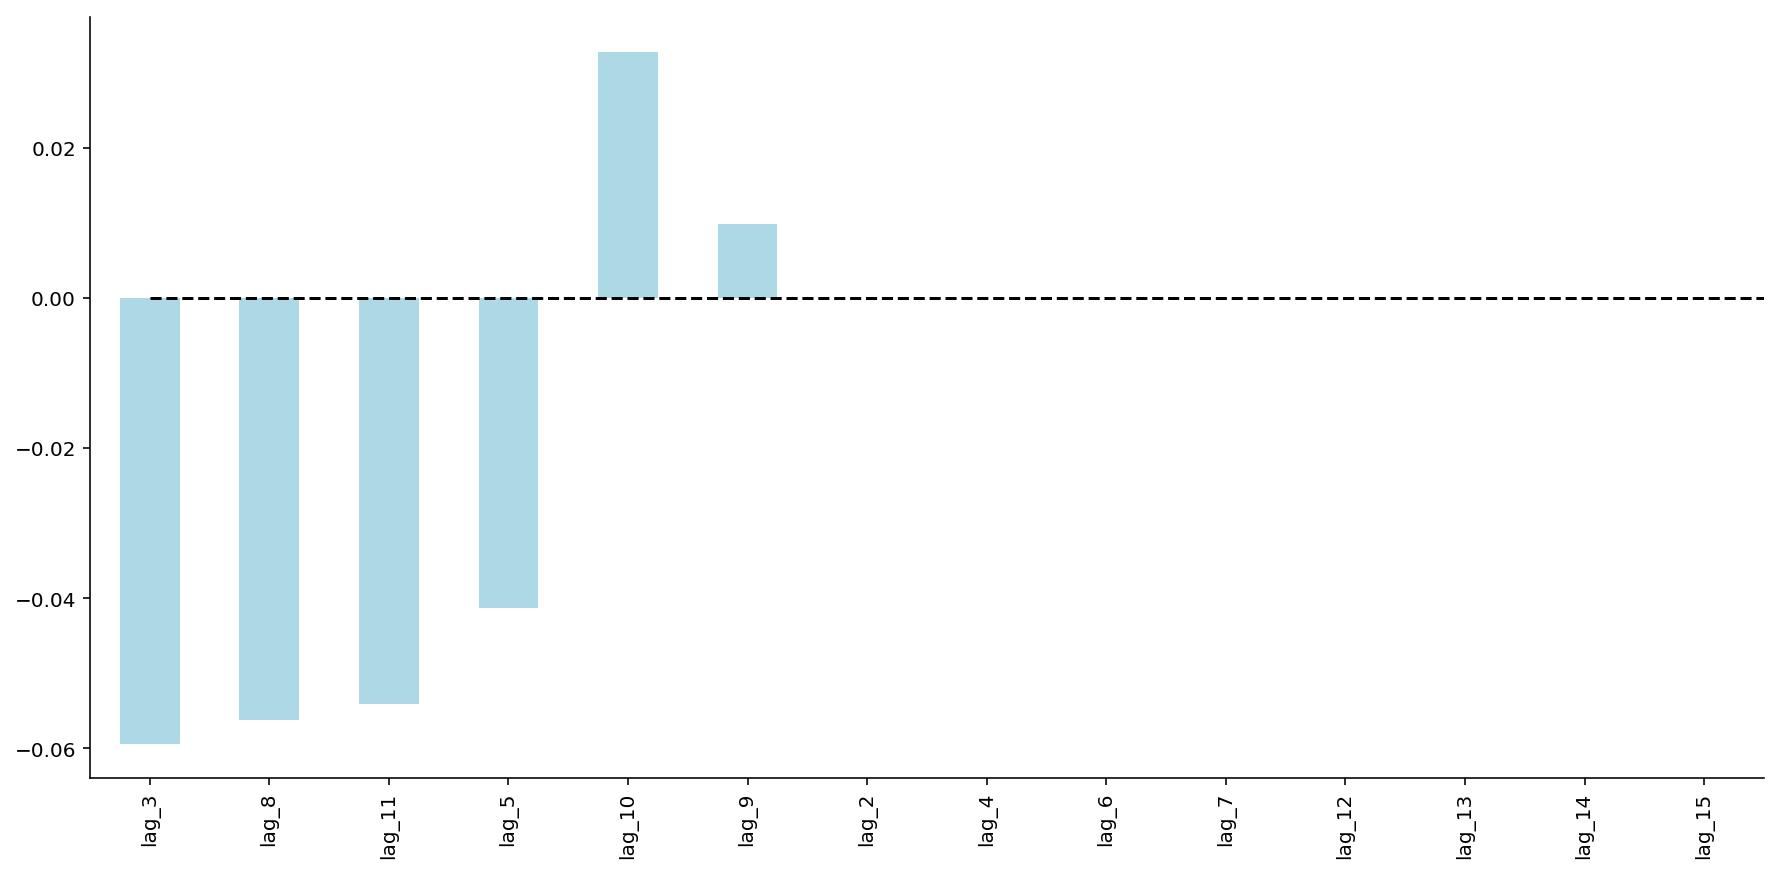

In [327]:
ts.plotModelResults(reg,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)
ts.plotCoefficients(reg,X_train)

## Support Vector Machine

In [328]:
from sklearn.svm import SVR

In [329]:
dt = gdp_roc.dropna()[-100:]
y = dt.y
X = dt.drop(['y'], axis = 1)
X_train, X_test, y_train, y_test = ts.timeseries_train_test_split(X, y, test_size=0.3)

In [342]:
clf = SVR(gamma='scale',kernel='linear')
clf.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

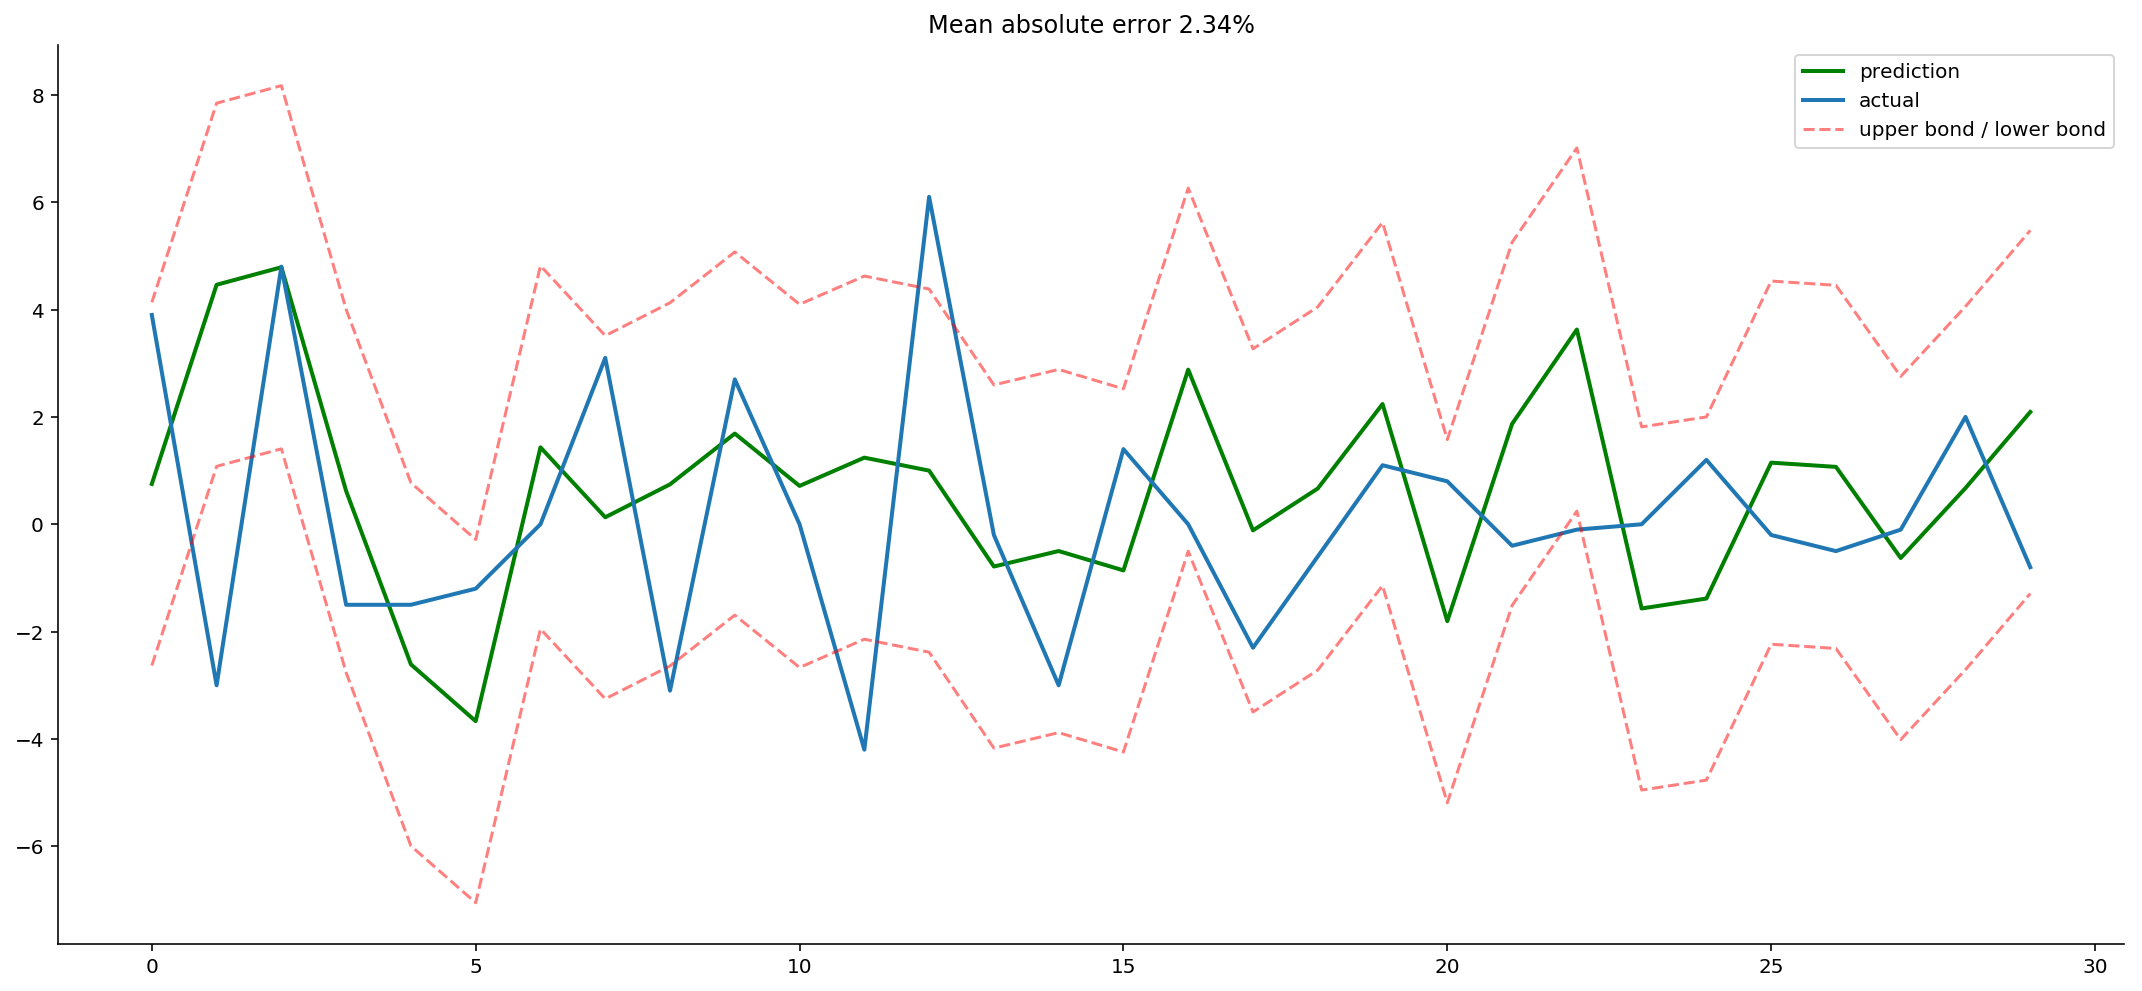

In [346]:
ts.plotModelResults(clf,X_train,X_test,y_train, y_test, tscv, plot_intervals=True)